<a href="https://colab.research.google.com/github/tushar-nebhnani/Olist-E-Commerce-Predictor-/blob/main/CaseStudyML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Brazilian E-Commerce Public Dataset by Olist
This is a Brazilian ecommerce public dataset of orders made at Olist Store. The dataset has information of 100k orders from 2016 to 2018 made at multiple marketplaces in Brazil. Its features allows viewing an order from multiple dimensions: from order status, price, payment and freight performance to customer location, product attributes and finally reviews written by customers. We also released a geolocation dataset that relates Brazilian zip codes to lat/lng coordinates.

The code in the following cell downloads the dataset from Kagglehub and lists the files in the downloaded directory.

In [ ]:
import kagglehub
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.express as px

# Download the latest version of the dataset
path = kagglehub.dataset_download("olistbr/brazilian-ecommerce")

# List the files in the downloaded directory
file_list = os.listdir(path)
for file_name in file_list:
    print(file_name)

Using Colab cache for faster access to the 'brazilian-ecommerce' dataset.
olist_customers_dataset.csv
olist_sellers_dataset.csv
olist_order_reviews_dataset.csv
olist_order_items_dataset.csv
olist_products_dataset.csv
olist_geolocation_dataset.csv
product_category_name_translation.csv
olist_orders_dataset.csv
olist_order_payments_dataset.csv


In [ ]:
def detect_and_plot_outliers_iqr(df, column, exclude_zero=False):
    """
    Detects outliers using the IQR method, prints outlier information, and plots a box plot.

    Args:
        df (pd.DataFrame): The input DataFrame.
        column (str): The name of the column to analyze for outliers.
        exclude_zero (bool): Whether to exclude zero values from outlier calculation.
                             Useful for columns where zero is a meaningful non-outlier value.
    """
    print(f"\n--- Outlier Analysis for column: {column} ---")

    # Create box plot
    plt.figure(figsize=(8, 4))
    sns.boxplot(y=df[column])
    plt.title(f'Box plot of {column}')
    plt.ylabel(column)
    plt.show()

    # Calculate IQR and identify outliers
    if exclude_zero:
        # Consider only non-zero values for IQR calculation
        data_for_iqr = df[df[column] != 0][column]
    else:
        data_for_iqr = df[column]

    if data_for_iqr.empty:
        print(f"  No non-zero data in column '{column}' to calculate outliers.")
        return

    Q1 = data_for_iqr.quantile(0.25)
    Q3 = data_for_iqr.quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify outliers in the original DataFrame
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]

    num_outliers = len(outliers)
    percentage_outliers = (num_outliers / len(df)) * 100

    print(f"  Number of outliers: {num_outliers}")
    print(f"  Percentage of outliers: {percentage_outliers:.2f}%")
    print(f"  Lower bound (IQR): {lower_bound:.2f}")
    print(f"  Upper bound (IQR): {upper_bound:.2f}")

    if num_outliers > 0 and num_outliers < 20: # Display if not too many outliers
        print("\nSample Outlier Rows:")
        display(outliers.head())

# Pre-processing of data

### The code in the following cell deals with the loading of the `olist_customers_dataset.csv` file. And cleaning of the dataset.

In [ ]:
# Load the customers dataset
customers_dataset_path = os.path.join(path, "olist_customers_dataset.csv")
customers_df = pd.read_csv(customers_dataset_path)

# Display the first few rows of the DataFrame
customers_df.head()

customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2  4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3  b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4  4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   

   customer_zip_code_prefix          customer_city customer_state  
0                     14409                 franca             SP  
1                      9790  sao bernardo do campo             SP  
2                      1151              sao paulo             SP  
3                      8775        mogi das cruzes             SP  
4                     13056               campinas             SP

In [ ]:
# Get information about the customers_df DataFrame
print(customers_df.info())

# Display missing values information
print("\nMissing values in customers_df:")
print(customers_df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB
None

Missing values in customers_df:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64


In [ ]:
# Checking for duplicated values
print(f"Duplicated values in customer_df: {customers_df.duplicated().sum()}")
print(f"Duplicated values in customer_df['customer_id']: {customers_df['customer_id'].duplicated().sum()}")
# Rest all the columns can have duplicate values.

Duplicated values in customer_df: 0
Duplicated values in customer_df['customer_id']: 0


Numerical columns in customers_df: Index(['customer_zip_code_prefix'], dtype='object')

--- Outlier Analysis for column: customer_zip_code_prefix ---


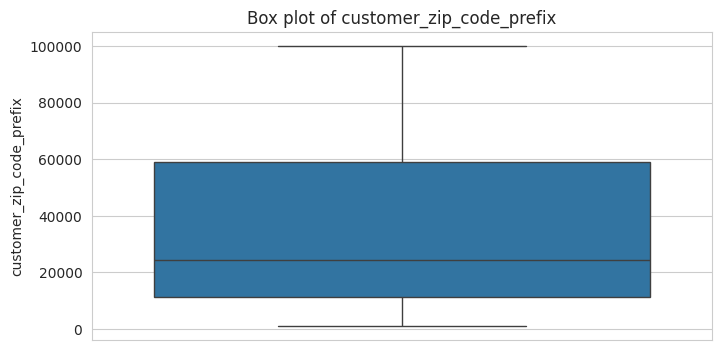

  Number of outliers: 0
  Percentage of outliers: 0.00%
  Lower bound (IQR): -59982.50
  Upper bound (IQR): 130229.50


In [ ]:
# Identify numerical columns in customers_df
numerical_cols_customers = customers_df.select_dtypes(include=np.number).columns

print("Numerical columns in customers_df:", numerical_cols_customers)

# Apply outlier detection and plotting for each numerical column
for col in numerical_cols_customers:
    detect_and_plot_outliers_iqr(customers_df, col)

Here are the key observations from the pre-processing of the `customers_df`:

*   **Missing Values:** No missing values were found in the dataset.
*   **Data Types:** All columns have been assigned appropriate data types.
*   **Duplicate Values:** There are no duplicate rows in the entire DataFrame or in the `customer_id` column. Duplicates in the `customer_unique_id` column are expected and represent repeat buyers, as explained in the dataset documentation.
*   **Row Uniqueness:** Each row represents a unique customer entry in this specific dataset instance.
*   **Key Identifiers:** `customer_id` serves as an anonymized link to orders, while `customer_unique_id` allows for tracking individual customers across multiple orders.
*   **Geographical Information:** The dataset includes `customer_city`, `customer_state`, and `customer_zip_code_prefix` for geographical analysis.
*   **Outliers:** No outliers were detected in the numerical column (`customer_zip_code_prefix`) using the IQR method.

### Exploratory Data Analysis (EDA) for `olist_customers_dataset.csv`





Stats related to customer_df:

In [ ]:
customers_df.describe()

customer_zip_code_prefix
count              99441.000000
mean               35137.474583
std                29797.938996
min                 1003.000000
25%                11347.000000
50%                24416.000000
75%                58900.000000
max                99990.000000

1. Analyze Customer Uniqueness -

* Count unique customer_unique_id values: This will tell you the true number of distinct customers in the dataset.

*   Calculate the ratio of unique customers to total records: This can reveal how many times, on average, a customer appears in the dataset.




In [ ]:
# Count unique customers
unique_customers = customers_df['customer_unique_id'].nunique()
total_records = len(customers_df)

print(f"Total unique customers: {unique_customers}")
print(f"Total customer entries: {total_records}")
print(f"Ratio of unique customers to total records: {unique_customers / total_records:.2f}")

Total unique customers: 96096
Total customer entries: 99441
Ratio of unique customers to total records: 0.97


2. Top 10 Cities and States: Find the most frequent cities and states and visualize them using a bar chart. This will show your main customer hubs.

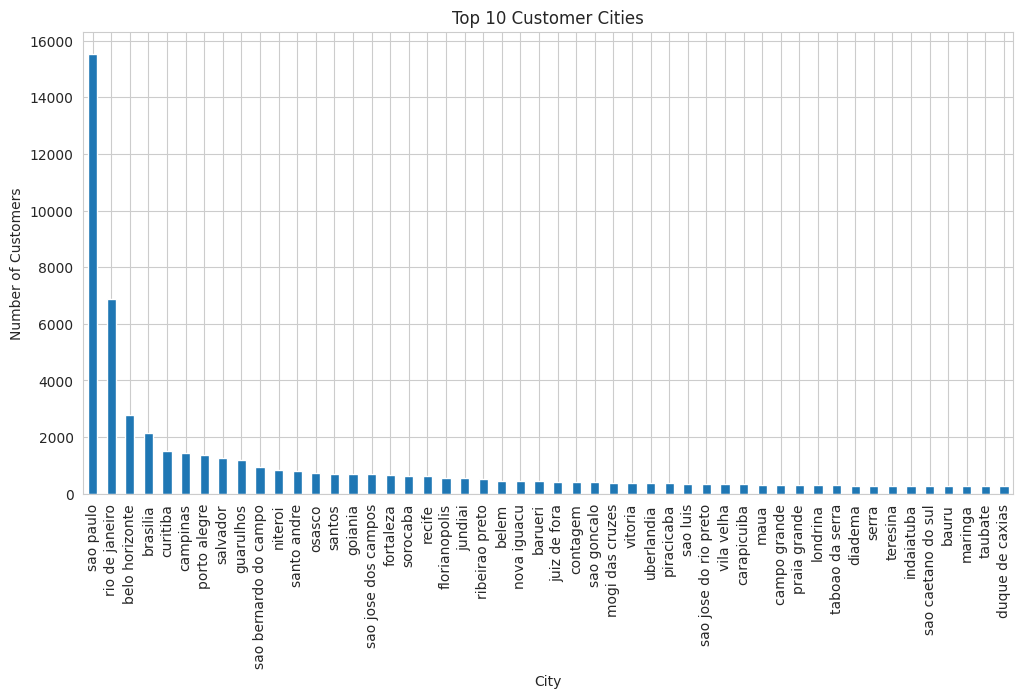

In [ ]:
top_cities = customers_df['customer_city'].value_counts().head(50)
plt.figure(figsize=(12, 6))
top_cities.plot(kind='bar')
plt.title('Top 10 Customer Cities')
plt.xlabel('City')
plt.ylabel('Number of Customers')
plt.xticks(rotation=90)
plt.show()

3. Distribution of Cities per State:


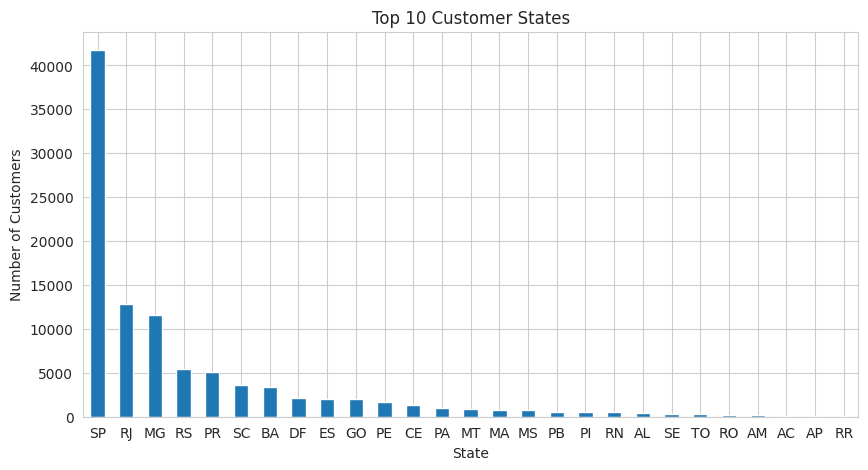

In [ ]:
# Top 50 customer states
top_states = customers_df['customer_state'].value_counts().head(50)
plt.figure(figsize=(10, 5))
top_states.plot(kind='bar')
plt.title('Top 10 Customer States')
plt.xlabel('State')
plt.ylabel('Number of Customers')
plt.xticks(rotation=0)
plt.show()


4. The customer_zip_code_prefix is a numerical value that can be analyzed to understand the geographic density of your customers.




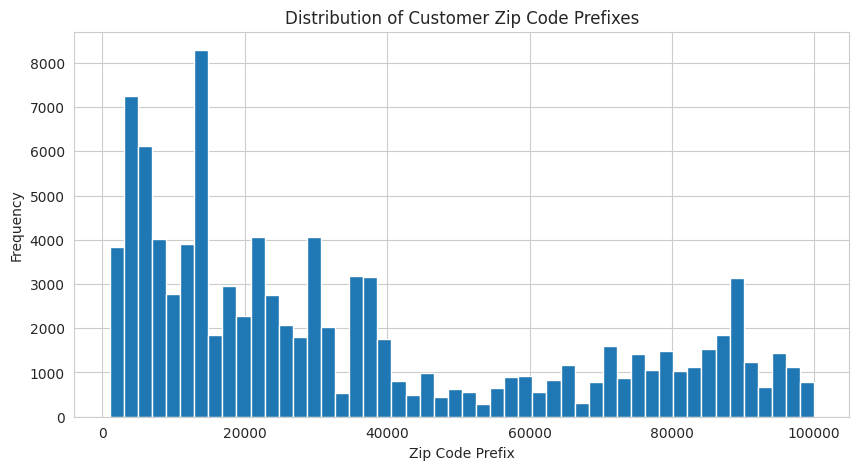

In [ ]:
# Distribution of customer zip code prefixes
plt.figure(figsize=(10, 5))
customers_df['customer_zip_code_prefix'].plot(kind='hist', bins=50)
plt.title('Distribution of Customer Zip Code Prefixes')
plt.xlabel('Zip Code Prefix')
plt.ylabel('Frequency')
plt.show()


5. You have already identified that a single customer_unique_id can have multiple customer_ids.
*   Count Repeated Unique IDs: Find the customer_unique_id values that appear more than once.

*   Calculate Repeat Rate: Calculate the percentage of total customers that are repeat customers.



In [ ]:
# Count the number of customer IDs for each unique customer
customer_counts = customers_df['customer_unique_id'].value_counts()

# Find the number of repeat customers
repeat_customers = (customer_counts[customer_counts > 1]).count()

# Calculate the percentage of repeat customers
total_unique_customers = customers_df['customer_unique_id'].nunique()
repeat_customer_rate = (repeat_customers / total_unique_customers) * 100

print(f"Number of unique customers: {total_unique_customers}")
print(f"Number of repeat customers: {repeat_customers}")
print(f"Repeat customer rate: {repeat_customer_rate:.2f}%")

Number of unique customers: 96096
Number of repeat customers: 2997
Repeat customer rate: 3.12%


6. MAXIMUM CUSTOMER CONCENTRATION and MINIMUM CUSTOMER CONCENTRATION

In [ ]:
# 1. Calculate the frequency of each city and store it in a Series, sorted descending.
city_counts = customers_df['customer_city'].value_counts()

# 2. Extract the city with the maximum customers (the first entry in the sorted series)
max_customer_city_info = city_counts.head(1)
max_city_name = max_customer_city_info.index[0]
max_city_count = max_customer_city_info.iloc[0]

# 3. Extract the city with the minimum customers (the last entry in the sorted series)
# The minimum count will always be 1. We'll identify the total number of cities that share this count.
min_count = city_counts.min()
min_cities = city_counts[city_counts == min_count]

min_city_count = min_cities.shape[0] # Total number of cities with minimum customers

# Get the name of one of the cities with the minimum count (for reporting)
one_min_city_name = min_cities.index[0]
print("\nMAXIMUM CUSTOMER CONCENTRATION")
print(f"City Name: {max_city_name.title()}")
print(f"Total Customers (Count): {max_city_count}")

print("\nMINIMUM CUSTOMER CONCENTRATION")
print(f"Minimum Customer Count Found: {min_count}")
print(f"Total Cities Sharing This Minimum Count: {min_city_count}")
print(f"Example City with Minimum Customers (one of {min_city_count}): {one_min_city_name.title()}")



MAXIMUM CUSTOMER CONCENTRATION
City Name: Sao Paulo
Total Customers (Count): 15540

MINIMUM CUSTOMER CONCENTRATION
Minimum Customer Count Found: 1
Total Cities Sharing This Minimum Count: 1144
Example City with Minimum Customers (one of 1144): Eugenio De Castro


Customer Loyalty Analysis: Analyzing the number of orders per unique customer to understand customer loyalty.

Summary Statistics for Order Counts per Unique Customer:
count    96096.000000
mean         1.034809
std          0.214384
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         17.000000
Name: order_count, dtype: float64


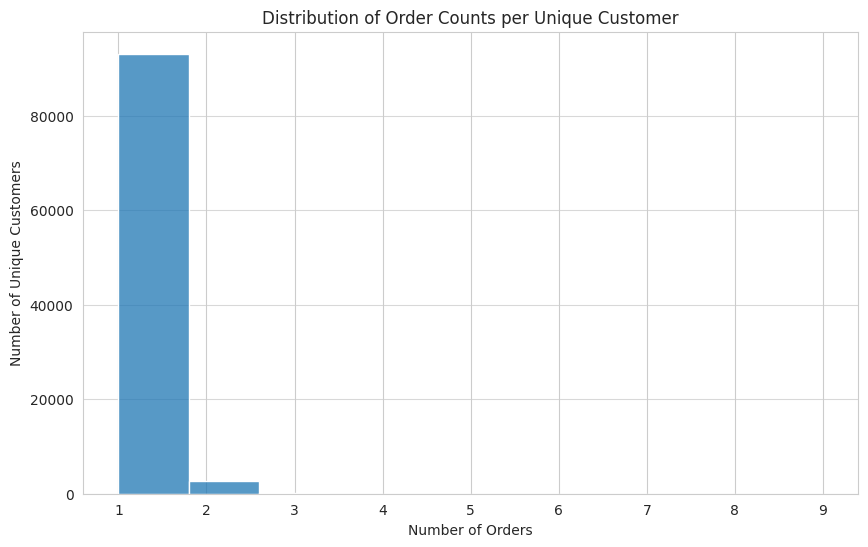


Total Unique Customers: 96096
Customers with 1 Order (One-time buyers): 93099
Customers with > 1 Order (Repeat buyers): 2997
Percentage of Repeat Buyers (out of Total Unique Customers): 3.12%


In [ ]:
customer_order_counts = customers_df['customer_unique_id'].value_counts().reset_index()
customer_order_counts.columns = ['customer_unique_id', 'order_count']

# Display summary statistics for order counts
print("Summary Statistics for Order Counts per Unique Customer:")
print(customer_order_counts['order_count'].describe())

# Visualize the distribution of order counts
plt.figure(figsize=(10, 6))
sns.histplot(customer_order_counts[customer_order_counts['order_count'] < 10]['order_count'], bins=10, kde=False) # Focus on counts less than 10 for better visibility
plt.title('Distribution of Order Counts per Unique Customer')
plt.xlabel('Number of Orders')
plt.ylabel('Number of Unique Customers')
plt.xticks(np.arange(1, 10)) # Show integer ticks
plt.grid(axis='y', alpha=0.75)
plt.show()

# Count customers with more than one order (repeat customers)
repeat_customers = customer_order_counts[customer_order_counts['order_count'] > 1]
num_repeat_customers = len(repeat_customers)
num_one_time_buyers = len(customer_order_counts[customer_order_counts['order_count'] == 1])
total_unique_customers = len(customer_order_counts)


print(f"\nTotal Unique Customers: {total_unique_customers}")
print(f"Customers with 1 Order (One-time buyers): {num_one_time_buyers}")
print(f"Customers with > 1 Order (Repeat buyers): {num_repeat_customers}")
print(f"Percentage of Repeat Buyers (out of Total Unique Customers): {(num_repeat_customers / total_unique_customers) * 100:.2f}%")

Number of customers by map.

Attempting to load data from: /kaggle/input/brazilian-ecommerce/olist_customers_dataset.csv
File loaded successfully!

--- Success! ---
The map has been saved as 'brazil_customer_map.png' in your current folder.


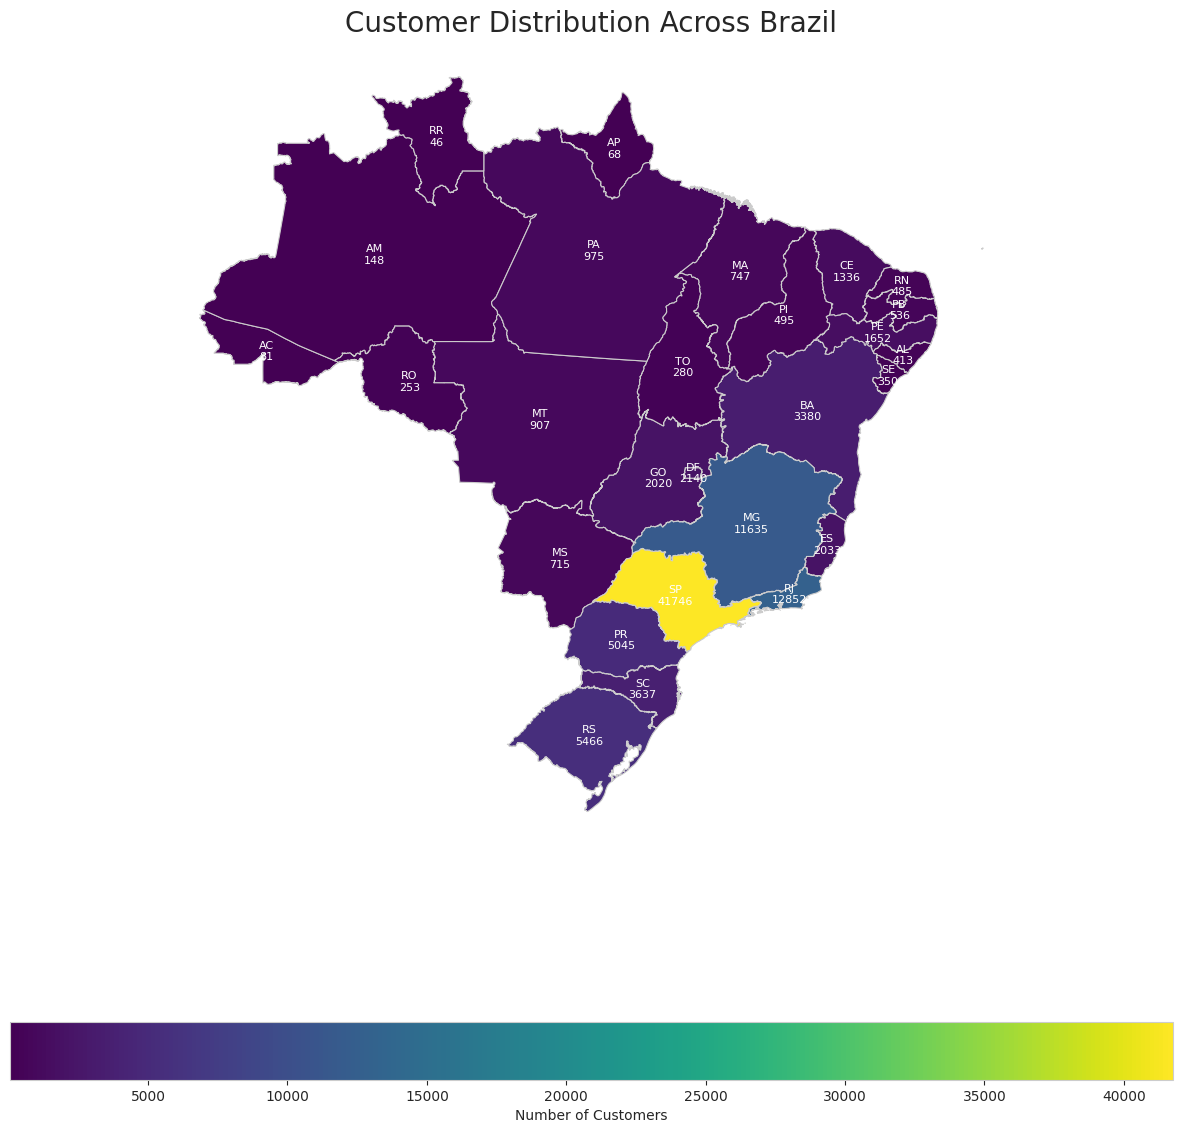

In [ ]:
import geopandas as gpd

def create_customer_map(customers_df):
    """
    Generates and displays a choropleth map of customer distribution in Brazil.

    Args:
        customers_df (pd.DataFrame): The dataframe containing customer data with a 'customer_state' column.
    """
    # --- Step 1: Prepare the Customer Data ---
    customer_counts_by_state = customers_df['customer_state'].value_counts().reset_index()
    customer_counts_by_state.columns = ['state_abbr', 'customer_count']

    # --- Step 2: Get Brazil's Geographic Data (with a new, working URL) ---
    geojson_url = "https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/brazil-states.geojson"

    try:
        gdf_states = gpd.read_file(geojson_url)
        gdf_states.rename(columns={'sigla': 'state_abbr'}, inplace=True)
    except Exception as e:
        print(f"Could not load geographic data from URL. Check your internet connection. Error: {e}")
        return

    customer_counts_by_state['state_abbr'] = customer_counts_by_state['state_abbr'].astype(str)
    gdf_states['state_abbr'] = gdf_states['state_abbr'].astype(str)

    # --- Step 3: Merge Geographic and Customer Data ---
    merged_gdf = gdf_states.merge(customer_counts_by_state, on='state_abbr', how='left')
    merged_gdf['customer_count'] = merged_gdf['customer_count'].fillna(0)

    # --- Step 4 & 5: Plot the Map and Annotate ---
    fig, ax = plt.subplots(1, 1, figsize=(15, 15))

    merged_gdf.plot(column='customer_count',
                    cmap='viridis',
                    linewidth=0.8,
                    ax=ax,
                    edgecolor='0.8',
                    legend=True,
                    legend_kwds={'label': "Number of Customers", 'orientation': "horizontal"})

    for idx, row in merged_gdf.iterrows():
        try:
            centroid = row.geometry.centroid
            state_name = row['state_abbr']
            count = int(row['customer_count'])
            ax.text(centroid.x, centroid.y, f"{state_name}\n{count}", ha='center', va='center', fontsize=8, color='white')
        except AttributeError:
            continue

    ax.set_title('Customer Distribution Across Brazil', fontdict={'fontsize': '20', 'fontweight': '3'})
    ax.set_axis_off()
    ax.set_aspect('equal')

    # This will save the map as an image in the same folder where you run the script.
    try:
        plt.savefig('brazil_customer_map.png', dpi=300, bbox_inches='tight')
        print("\n--- Success! ---")
        print("The map has been saved as 'brazil_customer_map.png' in your current folder.")
    except Exception as e:
        print(f"\nCould not save the file. Error: {e}")

    plt.show()
file_path = customers_dataset_path

# 2. LOAD THE DATA AND RUN THE FUNCTION
try:
    print(f"Attempting to load data from: {file_path}")
    customers_df = pd.read_csv(file_path)
    print("File loaded successfully!")
    create_customer_map(customers_df)
except FileNotFoundError:
    print(f"ERROR: FileNotFoundError")
    print(f"The file was not found at the specified path.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")




### The code in the following cell deals with the loading of the `olist_sellers_dataset.csv` file. Add cleaning of the file.

In [ ]:
# Load the sellers dataset
seller_dataset_path = os.path.join(path, "olist_sellers_dataset.csv")
seller_df = pd.read_csv(seller_dataset_path)

# Display the first few rows of the DataFrame
seller_df.head()

seller_id  seller_zip_code_prefix  \
0  3442f8959a84dea7ee197c632cb2df15                   13023   
1  d1b65fc7debc3361ea86b5f14c68d2e2                   13844   
2  ce3ad9de960102d0677a81f5d0bb7b2d                   20031   
3  c0f3eea2e14555b6faeea3dd58c1b1c3                    4195   
4  51a04a8a6bdcb23deccc82b0b80742cf                   12914   

         seller_city seller_state  
0           campinas           SP  
1         mogi guacu           SP  
2     rio de janeiro           RJ  
3          sao paulo           SP  
4  braganca paulista           SP

In [ ]:
# Get information about the seller_df DataFrame
print(seller_df.info())

# Display missing values information
print("\nMissing values in seller_df:")
print(seller_df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   seller_id               3095 non-null   object
 1   seller_zip_code_prefix  3095 non-null   int64 
 2   seller_city             3095 non-null   object
 3   seller_state            3095 non-null   object
dtypes: int64(1), object(3)
memory usage: 96.8+ KB
None

Missing values in seller_df:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64


In [ ]:
# Checking for duplicated values
print(f"Duplicated values in seller_df: {seller_df.duplicated().sum()}")
print(f"Duplicated values in sellerer_df['seller_id']: {seller_df['seller_id'].duplicated().sum()}")
# Rest all the columns can have duplicated values but that works.

Duplicated values in seller_df: 0
Duplicated values in sellerer_df['seller_id']: 0


Numerical columns in seller_df: Index(['seller_zip_code_prefix'], dtype='object')

--- Outlier Analysis for column: seller_zip_code_prefix ---


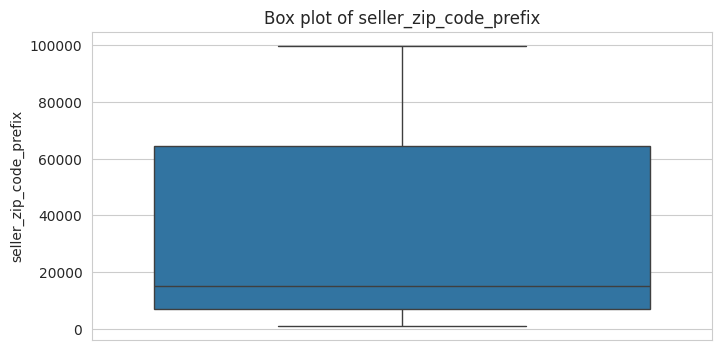

  Number of outliers: 0
  Percentage of outliers: 0.00%
  Lower bound (IQR): -79095.00
  Upper bound (IQR): 150741.00


In [ ]:
# Identify numerical columns in seller_df
numerical_cols_sellers = seller_df.select_dtypes(include=np.number).columns

print("Numerical columns in seller_df:", numerical_cols_sellers)

# Apply outlier detection and plotting for each numerical column
for col in numerical_cols_sellers:
    detect_and_plot_outliers_iqr(seller_df, col)

Here are the key observations from the pre-processing of the `seller_df`:

*   **Missing Values and Data Types:** No missing values were detected, and all columns have appropriate data types.
*   **Duplicate Values:** There are no duplicate values present in the DataFrame, ensuring each entry is unique per seller.
*   **Row Uniqueness:** Each row corresponds to a unique seller identified by `seller_id`.
*   **Geographical Information:** The dataset includes `seller_zip_code_prefix`, `seller_city`, and `seller_state`, allowing for geographical analysis of seller distribution.
*   **Geographical Distribution:** The `seller_state` column indicates the Brazilian state where each seller is located, which is important for analyzing logistics and regional presence.
*   **Outliers:** No outliers were detected in the numerical column (`seller_zip_code_prefix`) using the IQR method.

## Exploratory Data Analysis (EDA) for `olist_sellers_dataset.csv`

Stats for seller_df:

In [ ]:
seller_df.describe()

seller_zip_code_prefix
count             3095.000000
mean             32291.059451
std              32713.453830
min               1001.000000
25%               7093.500000
50%              14940.000000
75%              64552.500000
max              99730.000000

1. Seller Dataset Integrity and Uniqueness

In [ ]:
print("--- 1. Seller Dataset Integrity and Uniqueness ---")
print(f"Total Unique Sellers (Rows): {seller_df.shape[0]}")
print(f"Total Unique Seller IDs: {seller_df['seller_id'].nunique()}")
print("\nMissing Values per Column:")
print(seller_df.isnull().sum())


--- 1. Seller Dataset Integrity and Uniqueness ---
Total Unique Sellers (Rows): 3095
Total Unique Seller IDs: 3095

Missing Values per Column:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64


2. Geographical EDA: State Distribution

In [ ]:
print("\n--- 2. Geographical EDA: State Distribution ---")
state_counts = seller_df['seller_state'].value_counts()
print(f"Total Unique States with Sellers: {state_counts.shape[0]}")

# Absolute counts for top/bottom 5
print("\nTop 5 States by Seller Count (Absolute):")
print(state_counts.head(5))

print("\nBottom 5 States by Seller Count (Absolute):")
print(state_counts.tail(5))

# Concentration Metrics (SP dominance)
sp_count = state_counts.get('SP', 0)
total_sellers = seller_df.shape[0]
sp_percentage = (sp_count / total_sellers) * 100 if total_sellers > 0 else 0
print(f"\nSão Paulo (SP) Seller Count: {sp_count}")
print(f"São Paulo (SP) Percentage of Total Sellers: {sp_percentage:.2f}%")




--- 2. Geographical EDA: State Distribution ---
Total Unique States with Sellers: 23

Top 5 States by Seller Count (Absolute):
seller_state
SP    1849
PR     349
MG     244
SC     190
RJ     171
Name: count, dtype: int64

Bottom 5 States by Seller Count (Absolute):
seller_state
AC    1
PI    1
MA    1
AM    1
PA    1
Name: count, dtype: int64

São Paulo (SP) Seller Count: 1849
São Paulo (SP) Percentage of Total Sellers: 59.74%


3. Geographical EDA: City Distribution

In [ ]:
# --- 3. Geographical EDA: City Distribution ---
print("\n--- 3. Geographical EDA: City Distribution ---")
city_counts = seller_df['seller_city'].value_counts()
print(f"Total Unique Cities with Sellers: {city_counts.shape[0]}")

# Max Seller City
max_city_info = city_counts.head(1)
max_city_name = max_city_info.index[0]
max_city_count = max_city_info.iloc[0]
print(f"\nCity with MAX Sellers: {max_city_name.title()} ({max_city_count} sellers)")

# Min Seller City Analysis (Count of 1 sellers)
min_count = city_counts.min()
min_cities_count = (city_counts == min_count).sum()
print(f"Total Cities with MIN Sellers (Count of {min_count}): {min_cities_count}")
print(f"Percentage of Cities with MIN Sellers (Long Tail): {min_cities_count / city_counts.shape[0] * 100:.2f}%")
print(f"Example Min Seller City (one of {min_cities_count}): {city_counts[city_counts == 1].index[0].title()}")


--- 3. Geographical EDA: City Distribution ---
Total Unique Cities with Sellers: 611

City with MAX Sellers: Sao Paulo (694 sellers)
Total Cities with MIN Sellers (Count of 1): 342
Percentage of Cities with MIN Sellers (Long Tail): 55.97%
Example Min Seller City (one of 342): Leme


4. Zip Code Prefix Distribution

In [ ]:
# --- 4. Zip Code Prefix Distribution ---
print("\n--- 4. Zip Code Prefix Distribution ---")
zip_counts = seller_df['seller_zip_code_prefix'].value_counts()
print(f"Total Unique Seller Zip Code Prefixes: {zip_counts.shape[0]}")
print("\nTop 5 Most Frequent Seller Zip Code Prefixes (Highest Seller Density):")
print(zip_counts.head(5))



--- 4. Zip Code Prefix Distribution ---
Total Unique Seller Zip Code Prefixes: 2246

Top 5 Most Frequent Seller Zip Code Prefixes (Highest Seller Density):
seller_zip_code_prefix
14940    49
13660    10
16200     9
13920     9
1026      8
Name: count, dtype: int64


5. Bar Chart: Top 10 Seller States

/tmp/ipython-input-1365954823.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


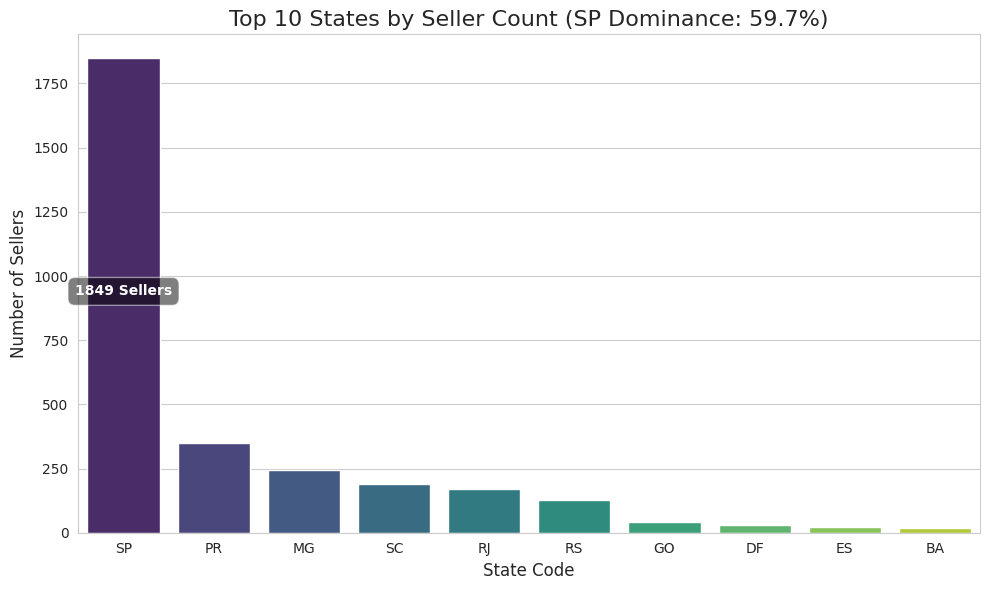

In [ ]:
state_counts = seller_df['seller_state'].value_counts().head(10)
plt.figure(figsize=(10, 6))
sns.barplot(
 x=state_counts.index,
 y=state_counts.values,
 palette="viridis"
)

# Calculate SP percentage for the title
sp_percent = (state_counts.iloc[0] / seller_df.shape[0]) * 100

plt.title(f'Top 10 States by Seller Count (SP Dominance: {sp_percent:.1f}%)', fontsize=16)
plt.xlabel('State Code', fontsize=12)
plt.ylabel('Number of Sellers', fontsize=12)
plt.xticks(rotation=0)

# Add annotation for the dominant state
plt.text(
    x=0,
    y=state_counts.values[0] / 2,
    s=f'{state_counts.values[0]} Sellers',
    ha='center',
    color='white',
    fontweight='bold',
    bbox=dict(facecolor='black', alpha=0.5, boxstyle="round,pad=0.5")
)
plt.tight_layout()
plt.show()

2. Histogram: Seller Zip Code Prefix Distribution

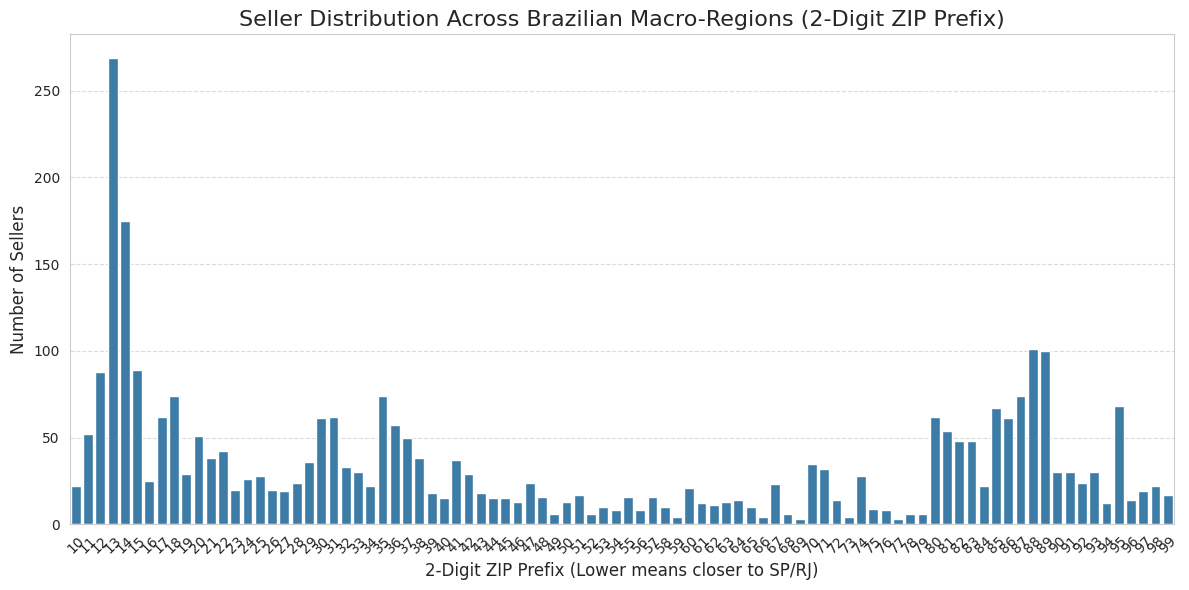

In [ ]:
# Extract the first two digits to represent macro-regions
seller_df['zip_prefix_2_digit'] = seller_df['seller_zip_code_prefix'].astype(str).str.slice(0, 2)

# Calculate counts and sort by prefix for chronological plotting
zip_counts = seller_df['zip_prefix_2_digit'].value_counts().sort_index()

plt.figure(figsize=(12, 6))

# Plotting the distribution of the 2-digit prefixes
sns.barplot(
    x=zip_counts.index,
    y=zip_counts.values,
    color="#2c7fb8"
)

plt.title('Seller Distribution Across Brazilian Macro-Regions (2-Digit ZIP Prefix)', fontsize=16)
plt.xlabel('2-Digit ZIP Prefix (Lower means closer to SP/RJ)', fontsize=12)
plt.ylabel('Number of Sellers', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

3. Pareto Analysis of Seller Cities (Concentration Curve)

Generating Pareto Chart for Seller Cities...


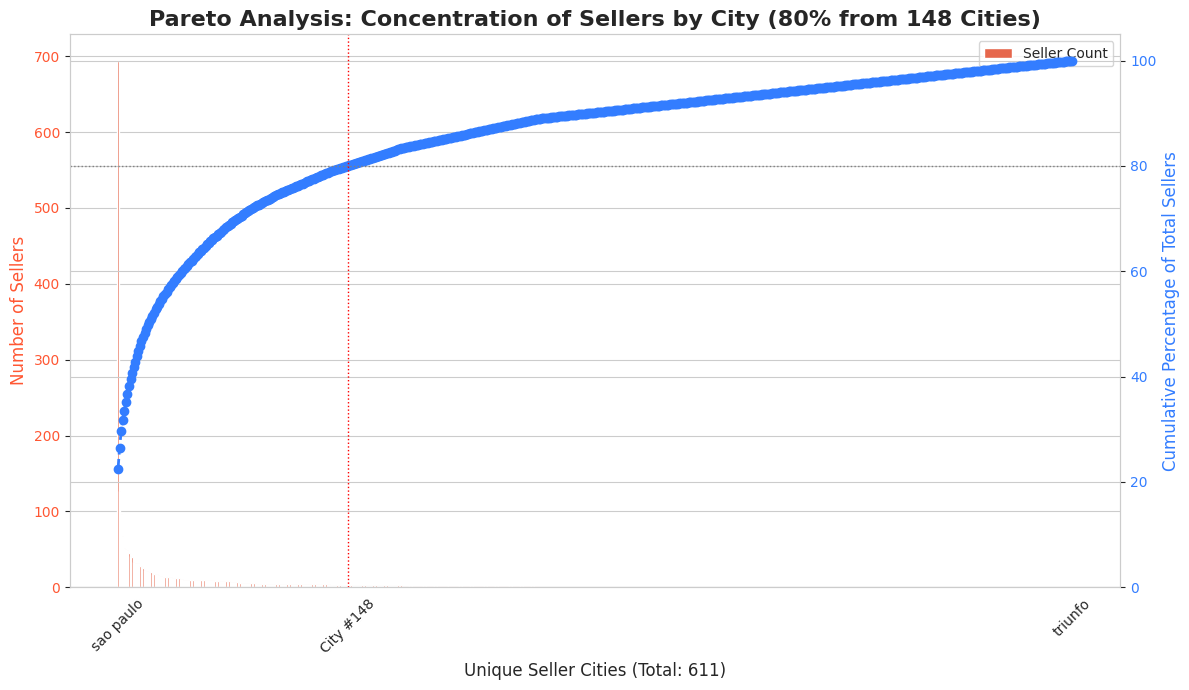

In [ ]:
PRIMARY_COLOR = "#FF5733" # Vibrant Coral
SECONDARY_COLOR = "#337DFF" # Bright Blue
print("Generating Pareto Chart for Seller Cities...")
city_counts = seller_df['seller_city'].value_counts().sort_values(ascending=False)

# Calculate cumulative percentage
cumulative_percent = (city_counts.cumsum() / city_counts.sum()) * 100
city_indices = np.arange(len(city_counts))

# Determine the 80% cutoff point
cutoff_index = np.where(cumulative_percent >= 80)[0][0] + 1

fig, ax1 = plt.subplots(figsize=(12, 7))

# Bar Plot (Counts)
sns.barplot(x=city_indices, y=city_counts.values, color=PRIMARY_COLOR, ax=ax1, label='Seller Count')
ax1.set_xlabel(f'Unique Seller Cities (Total: {len(city_counts)})', fontsize=12)
ax1.set_ylabel('Number of Sellers', color=PRIMARY_COLOR, fontsize=12)
ax1.tick_params(axis='y', labelcolor=PRIMARY_COLOR)
ax1.set_xticks([0, cutoff_index - 1, len(city_counts) - 1])
ax1.set_xticklabels([city_counts.index[0], f'City #{cutoff_index}', city_counts.index[-1]])
ax1.tick_params(axis='x', rotation=45)

# Line Plot (Cumulative Percentage)
ax2 = ax1.twinx()
ax2.plot(city_indices, cumulative_percent.values, color=SECONDARY_COLOR, marker='o', linestyle='--', linewidth=2, label='Cumulative %')
ax2.set_ylabel('Cumulative Percentage of Total Sellers', color=SECONDARY_COLOR, fontsize=12)
ax2.tick_params(axis='y', labelcolor=SECONDARY_COLOR)
ax2.set_ylim(0, 105)
ax2.axhline(80, color='gray', linestyle=':', linewidth=1)
ax2.axvline(cutoff_index - 1, color='red', linestyle=':', linewidth=1)

plt.title(f'Pareto Analysis: Concentration of Sellers by City (80% from {cutoff_index} Cities)',
              fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

4. State-by-State Diversity (Unique Cities per State)


Generating State Diversity Chart...


/tmp/ipython-input-3937898739.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


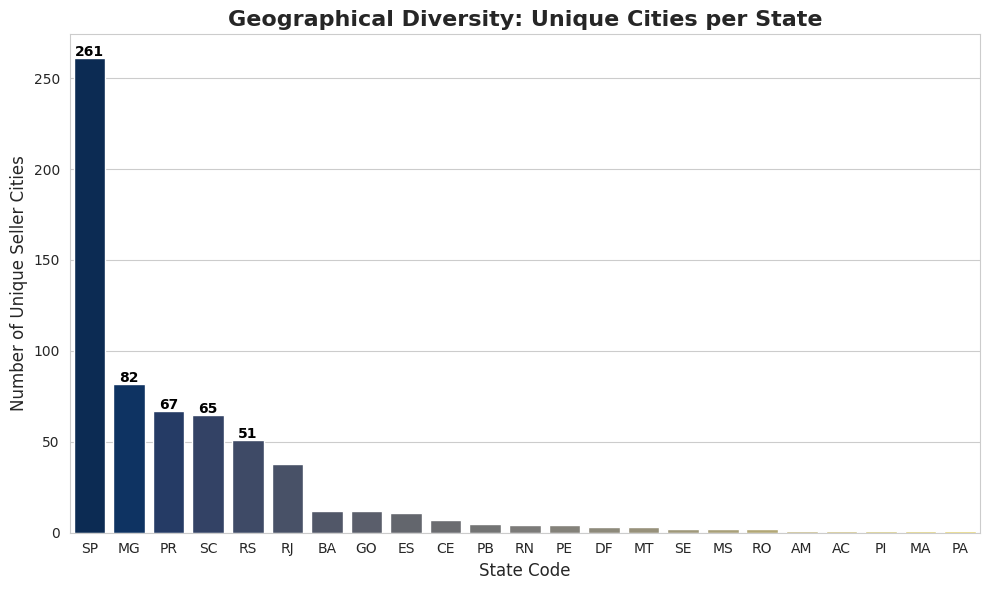

In [ ]:
print("\nGenerating State Diversity Chart...")

  # Group by state and count the number of unique cities within that state
state_diversity = seller_df.groupby('seller_state')['seller_city'].nunique().sort_values(ascending=False)

plt.figure(figsize=(10, 6))

sns.barplot(
      x=state_diversity.index,
      y=state_diversity.values,
      palette=sns.color_palette("cividis", n_colors=len(state_diversity)) # Use a professional, diverse palette
)

plt.title('Geographical Diversity: Unique Cities per State', fontsize=16, fontweight='bold')  
plt.xlabel('State Code', fontsize=12)
plt.ylabel('Number of Unique Seller Cities', fontsize=12)
plt.xticks(rotation=0)

  # Annotate the number of cities on top of each bar for the top 5
for i in range(5):
  plt.text(i, state_diversity.values[i] + 1, str(state_diversity.values[i]), ha='center', fontsize=10, color='black', fontweight='bold')

plt.tight_layout()
plt.show()

5. Box Plot: Distribution of Seller ZIP Code Prefixes


Generating ZIP Code Prefix Box Plot...


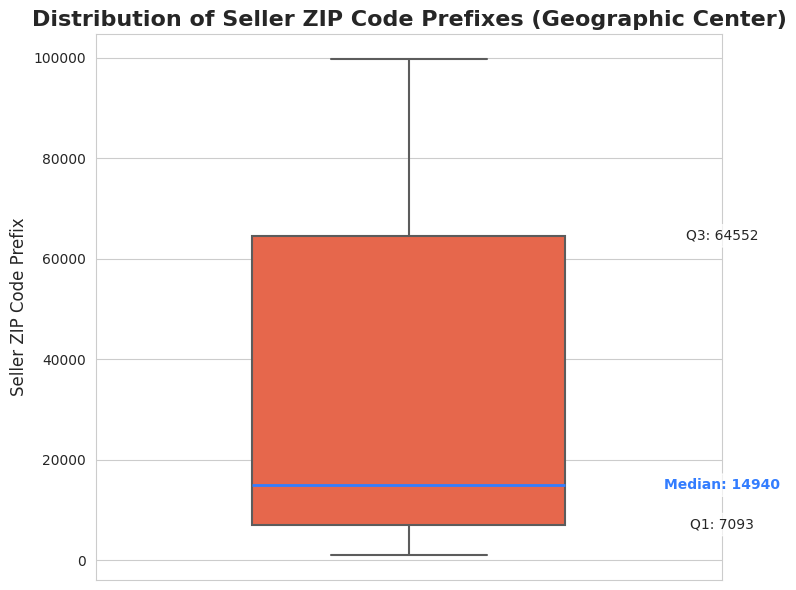

In [ ]:
print("\nGenerating ZIP Code Prefix Box Plot...")

# Ensure prefix is treated as a numeric value for distribution analysis
zip_prefix_numeric = pd.to_numeric(seller_df['seller_zip_code_prefix'], errors='coerce')

plt.figure(figsize=(8, 6))

# Generate the box plot
sns.boxplot(y=zip_prefix_numeric, color=PRIMARY_COLOR, width=0.5,
          fliersize=5, linewidth=1.5, medianprops={'color': SECONDARY_COLOR, 'linewidth': 2})

plt.title('Distribution of Seller ZIP Code Prefixes (Geographic Center)',
          fontsize=16, fontweight='bold')
plt.ylabel('Seller ZIP Code Prefix', fontsize=12)
plt.tick_params(axis='x', labelbottom=False)

# Add key statistical values as text annotations
median = zip_prefix_numeric.median()
q1 = zip_prefix_numeric.quantile(0.25)
q3 = zip_prefix_numeric.quantile(0.75)

plt.text(0.5, median, f'Median: {int(median)}', ha='center', va='center',
          bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.7), color=SECONDARY_COLOR, fontweight='bold')

plt.text(0.5, q1, f'Q1: {int(q1)}', ha='center', va='center',
          bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.7))

plt.text(0.5, q3, f'Q3: {int(q3)}', ha='center', va='center',
          bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.7))

plt.tight_layout()
plt.show()

6. NEW: Heatmap of State vs. Macro-Region Density


Generating State vs. Macro-Region Heatmap...


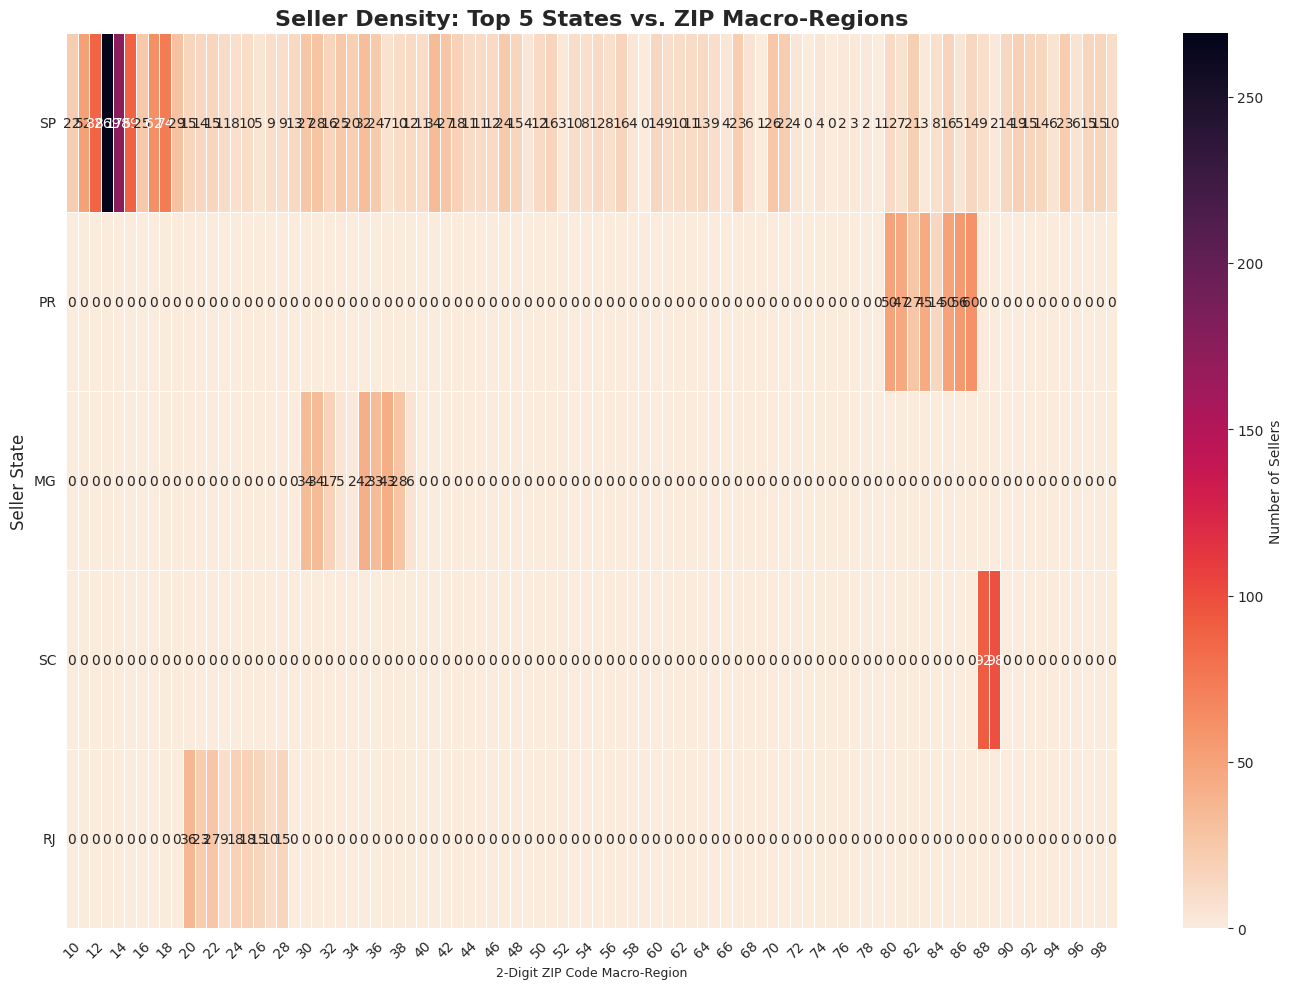

In [ ]:
top_5_states = seller_df['seller_state'].value_counts().head(5).index
print("\nGenerating State vs. Macro-Region Heatmap...")

# Create the contingency table (cross-tabulation)
density_table = seller_df.groupby(['seller_state', 'zip_prefix_2_digit']).size().unstack(fill_value=0)

# Filter for the top 5 states and transpose for better visualization
density_table_top_states = density_table.loc[top_5_states]

plt.figure(figsize=(14, 10))

# Create the heatmap
sns.heatmap(
    density_table_top_states,
    annot=True,        # Show the actual numbers on the map
    fmt='d',           # Format as integer
    cmap='rocket_r',   # Attractive, intense color scheme (light-to-dark gradient)
    linewidths=0.5,    # Lines between cells
    cbar_kws={'label': 'Number of Sellers'}
)

plt.title('Seller Density: Top 5 States vs. ZIP Macro-Regions', fontsize=16, fontweight='bold')
plt.xlabel('2-Digit ZIP Code Macro-Region', fontsize=9)
plt.ylabel('Seller State', fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


## The code in the following cell loads the `olist_order_reviews_dataset.csv` file into a pandas DataFrame and displays the first few rows.

In [ ]:
# Load the order reviews dataset
order_reviews_dataset_path = os.path.join(path, "olist_order_reviews_dataset.csv")
order_reviews_df = pd.read_csv(order_reviews_dataset_path)

# Display the first few rows of the DataFrame
order_reviews_df.head()

review_id                          order_id  \
0  7bc2406110b926393aa56f80a40eba40  73fc7af87114b39712e6da79b0a377eb   
1  80e641a11e56f04c1ad469d5645fdfde  a548910a1c6147796b98fdf73dbeba33   
2  228ce5500dc1d8e020d8d1322874b6f0  f9e4b658b201a9f2ecdecbb34bed034b   
3  e64fb393e7b32834bb789ff8bb30750e  658677c97b385a9be170737859d3511b   
4  f7c4243c7fe1938f181bec41a392bdeb  8e6bfb81e283fa7e4f11123a3fb894f1   

   review_score review_comment_title  \
0             4                  NaN   
1             5                  NaN   
2             5                  NaN   
3             5                  NaN   
4             5                  NaN   

                              review_comment_message review_creation_date  \
0                                                NaN  2018-01-18 00:00:00   
1                                                NaN  2018-03-10 00:00:00   
2                                                NaN  2018-02-17 00:00:00   
3              Recebi bem antes do prazo estipulado.  2017-04-21 00:00:00   
4  Parabéns lojas lannister adorei comprar pela I...  2018-03-01 00:00:00   

  review_answer_timestamp  
0     2018-01-18 21:46:59  
1     2018-03-11 03:05:13  
2     2018-02-18 14:36:24  
3     2017-04-21 22:02:06  
4     2018-03-02 10:26:53

In [ ]:
# Get information about the order_reviews_df DataFrame
print(order_reviews_df.info())

# Display missing values information
print("\nMissing values in order_reviews_df:")
print(order_reviews_df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   review_id                99224 non-null  object
 1   order_id                 99224 non-null  object
 2   review_score             99224 non-null  int64 
 3   review_comment_title     11568 non-null  object
 4   review_comment_message   40977 non-null  object
 5   review_creation_date     99224 non-null  object
 6   review_answer_timestamp  99224 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB
None

Missing values in order_reviews_df:
review_id                      0
order_id                       0
review_score                   0
review_comment_title       87656
review_comment_message     58247
review_creation_date           0
review_answer_timestamp        0
dtype: int64


In [ ]:
# Fill missing values in 'review_comment_title' and 'review_comment_message' with 'no comment'
order_reviews_df['review_comment_title'] = order_reviews_df['review_comment_title'].fillna('no comment')
order_reviews_df['review_comment_message'] = order_reviews_df['review_comment_message'].fillna('no comment')

# Verify that missing values have been handled
print("\nMissing values in order_reviews_df after filling:")
print(order_reviews_df.isnull().sum())


Missing values in order_reviews_df after filling:
review_id                  0
order_id                   0
review_score               0
review_comment_title       0
review_comment_message     0
review_creation_date       0
review_answer_timestamp    0
dtype: int64


In [ ]:
# Datatype mismatch
order_reviews_df['review_answer_timestamp'] = pd.to_datetime(order_reviews_df['review_answer_timestamp'])
order_reviews_df['review_creation_date'] = pd.to_datetime(order_reviews_df['review_creation_date'])

print(f"Datatype after being handled carefully: \n{order_reviews_df.dtypes}")

Datatype after being handled carefully: 
review_id                          object
order_id                           object
review_score                        int64
review_comment_title               object
review_comment_message             object
review_creation_date       datetime64[ns]
review_answer_timestamp    datetime64[ns]
dtype: object


In [ ]:
# Duplicated Values
print(f"Duplicated values in order_reviews_df: {order_reviews_df.duplicated().sum()}")
print(f"Duplicated values in order_reviews_df['review_id']: {order_reviews_df['review_id'].duplicated().sum()}")

Duplicated values in order_reviews_df: 0
Duplicated values in order_reviews_df['review_id']: 814


In [ ]:
# Remove duplicate review_id values from order_reviews_df
order_reviews_df.drop_duplicates(subset='review_id', inplace=True)

# Verify that duplicates have been removed
print(f"Duplicated values in order_reviews_df['review_id'] after removing duplicates: {order_reviews_df['review_id'].duplicated().sum()}")

Duplicated values in order_reviews_df['review_id'] after removing duplicates: 0


## Exploratory Data Analysis (EDA) for `olist_order_reviews_dataset.csv`
`

In [ ]:
order_reviews_df.describe()

review_score           review_creation_date  \
count  98410.000000                          98410   
mean       4.088802  2018-01-13 06:50:35.984148480   
min        1.000000            2016-10-02 00:00:00   
25%        4.000000            2017-09-24 00:00:00   
50%        5.000000            2018-02-02 00:00:00   
75%        5.000000            2018-05-16 00:00:00   
max        5.000000            2018-08-31 00:00:00   
std        1.345758                            NaN   

             review_answer_timestamp  
count                          98410  
mean   2018-01-16 10:26:43.416786944  
min              2016-10-07 18:32:28  
25%       2017-09-27 19:43:43.500000  
50%              2018-02-05 11:08:52  
75%    2018-05-20 14:08:15.750000128  
max              2018-10-29 12:27:35  
std                              NaN

/tmp/ipython-input-4106456646.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


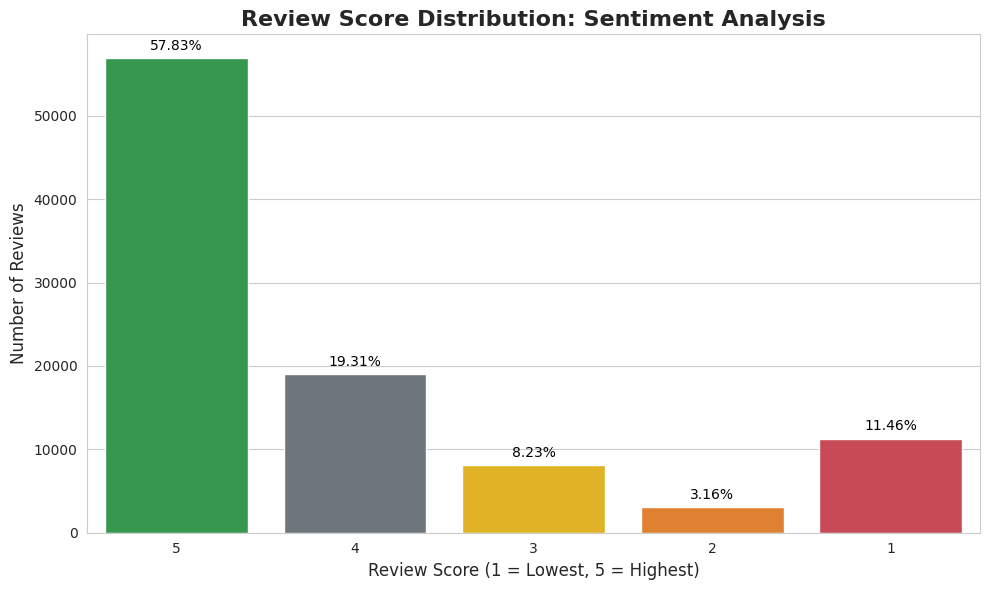


--- Review Score Summary ---
   review_score  count  percentage
0             5  56910   57.829489
1             4  19007   19.314094
2             3   8097    8.227822
3             2   3114    3.164313
4             1  11282   11.464282

Total Reviews: 98410
Average Score: 4.09


In [ ]:
# Calculate the value counts and convert to a DataFrame for plotting
score_counts = order_reviews_df['review_score'].value_counts().sort_index(ascending=False)
score_df = score_counts.reset_index()
score_df.columns = ['review_score', 'count']

# Calculate percentages for annotations
total_reviews = score_df['count'].sum()
score_df['percentage'] = (score_df['count'] / total_reviews) * 100

# Define a custom color palette based on sentiment:
# 5, 4 (Positive): Green shades
# 3 (Neutral): Yellow/Gray
# 2, 1 (Negative): Red shades
color_map = {
    5: '#28a745',  # Dark Green (Strong Positive)
    4: '#6c757d',  # Green-Gray (Positive)
    3: '#ffc107',  # Yellow (Neutral)
    2: '#fd7e14',  # Orange (Negative)
    1: '#dc3545'   # Red (Strong Negative)
}
# Map colors to the scores in the DataFrame
score_df['color'] = score_df['review_score'].map(color_map)

# Set the visualization style
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Create the bar plot
# Ensure scores are treated as categorical for correct X-axis labels
ax = sns.barplot(
    x='review_score',
    y='count',
    data=score_df,
    palette=score_df['color'].tolist(),
    order=sorted(score_df['review_score'].unique(), reverse=True) # Plot 5 to 1
)

# Add title and labels
plt.title('Review Score Distribution: Sentiment Analysis', fontsize=16, fontweight='bold')
plt.xlabel('Review Score (1 = Lowest, 5 = Highest)', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)

# Add percentage annotations on top of each bar
for index, row in score_df.iterrows():
    # Find the corresponding bar height for annotation
    bar_height = ax.patches[index].get_height()
    # Format the percentage text
    percentage_text = f'{row["percentage"]:.2f}%'

    # Place the text above the bar
    plt.text(
        ax.patches[index].get_x() + ax.patches[index].get_width() / 2., # X position
        bar_height + total_reviews * 0.01, # Y position (slightly above the bar)
        percentage_text,
        ha='center',
        fontsize=10,
        color='black'
    )

# Clean up layout
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Print summary statistics to the console
print("\n--- Review Score Summary ---")
print(score_df[['review_score', 'count', 'percentage']].sort_values(by='review_score', ascending=False))
print(f"\nTotal Reviews: {total_reviews}")
print(f"Average Score: {order_reviews_df['review_score'].mean():.2f}")

Analysis of Review Comments

In [ ]:
reviews_with_comment = (order_reviews_df['review_comment_message'] != 'no comment').sum()
total_reviews = len(order_reviews_df)
print("\nAnalysis of Review Comments:")
print(f"Total reviews: {total_reviews}")
print(f"Reviews with a comment: {reviews_with_comment}")
print(f"Reviews without a comment: {total_reviews - reviews_with_comment}")



Analysis of Review Comments:
Total reviews: 98410
Reviews with a comment: 40668
Reviews without a comment: 57742


Temporal Analysis - Review Response Time

In [ ]:
order_reviews_df['response_time'] = (order_reviews_df['review_answer_timestamp'] - order_reviews_df['review_creation_date'])

# Calculate summary statistics for response time
mean_response_time = order_reviews_df['response_time'].mean()
median_response_time = order_reviews_df['response_time'].median()

print("\nAnalysis of Review Response Time:")
print(f"Mean response time: {mean_response_time}")
print(f"Median response time: {median_response_time}")



Analysis of Review Response Time:
Mean response time: 3 days 03:36:07.432638959
Median response time: 1 days 16:10:33


Comment Length vs. Review Score

In [ ]:
# Calculate the length of the message column
order_reviews_df['comment_length'] = order_reviews_df['review_comment_message'].apply(lambda x: len(x) if x != 'no comment' else 0)

# Calculate average comment length for each review score (excluding 'no comment' = 0 length)
# We only care about reviews where a comment was actually left (length > 0)
avg_comment_length_by_score = order_reviews_df[order_reviews_df['comment_length'] > 0].groupby('review_score')['comment_length'].mean().round(2)
print("\nAverage Comment Length (Characters) by Review Score:")
print(avg_comment_length_by_score)


Average Comment Length (Characters) by Review Score:
review_score
1    99.98
2    96.92
3    83.26
4    61.73
5    51.87
Name: comment_length, dtype: float64


Visualization for Comment Length vs. Review Score

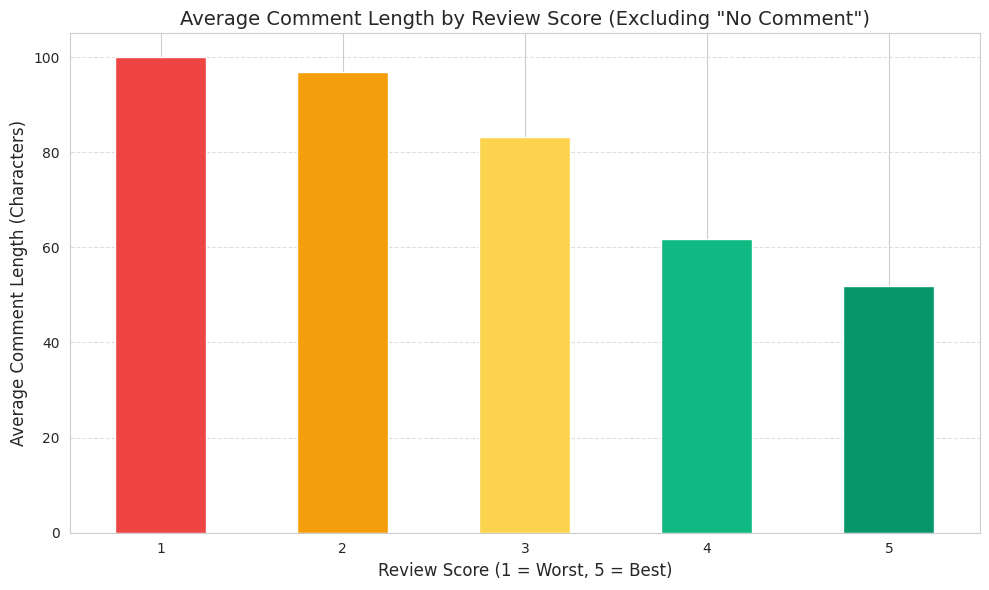

In [ ]:
plt.figure(figsize=(10, 6))
# Using a color palette to show the trend from low scores (red) to high scores (green)
colors = ['#EF4444', '#F59E0B', '#FCD34D', '#10B981', '#059669']
avg_comment_length_by_score.plot(kind='bar', color=colors)
plt.title('Average Comment Length by Review Score (Excluding "No Comment")', fontsize=14)
plt.xlabel('Review Score (1 = Worst, 5 = Best)', fontsize=12)
plt.ylabel('Average Comment Length (Characters)', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Reviews per Order (Checking for duplicate order reviews)

In [ ]:
reviews_per_order = order_reviews_df['order_id'].value_counts()
orders_with_multiple_reviews = reviews_per_order[reviews_per_order > 1]

print("\nAnalysis of Reviews per Order:")
print(f"Total number of unique orders reviewed: {len(reviews_per_order)}")
print(f"Number of orders with multiple reviews: {len(orders_with_multiple_reviews)}")
if len(orders_with_multiple_reviews) > 0:
    print("Top 5 Orders with the Most Reviews:")
    print(orders_with_multiple_reviews.head())


Analysis of Reviews per Order:
Total number of unique orders reviewed: 98167
Number of orders with multiple reviews: 243
Top 5 Orders with the Most Reviews:
order_id
84aa61a900410cfe26b57337d376a1ae    2
deab5b501cae4f6475a45bb4eaf79b61    2
21cb4961399b846b168d0358100f473b    2
250587cf0cafce7892b56a47a1697833    2
0db1181e0778609b581bf9a95b17f313    2
Name: count, dtype: int64


Visualization for Reviews per Order


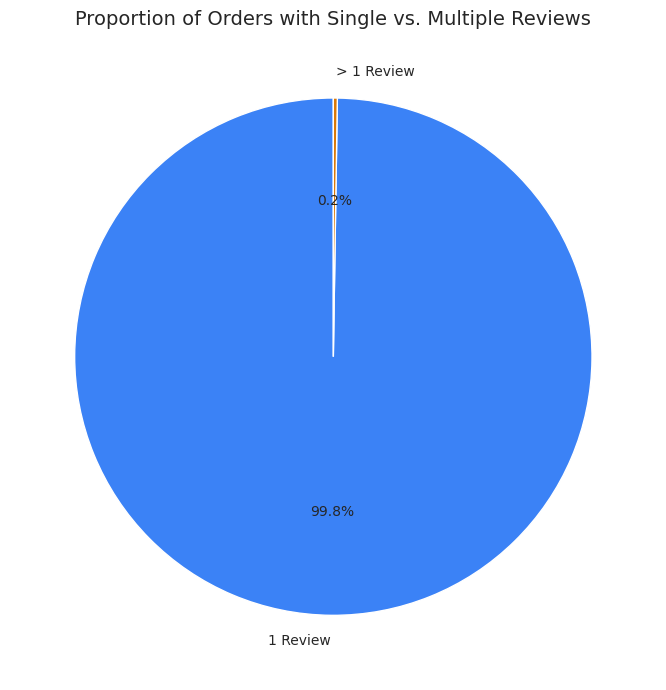

In [ ]:
plt.figure(figsize=(7, 7))
# Create categories: '1 Review' and '> 1 Review'
review_counts = reviews_per_order.apply(lambda x: '1 Review' if x == 1 else '> 1 Review').value_counts()
plt.pie(review_counts, labels=review_counts.index, autopct='%1.1f%%', startangle=90, colors=['#3B82F6', '#D97706'])
plt.title('Proportion of Orders with Single vs. Multiple Reviews', fontsize=14)
plt.tight_layout()
plt.show()

Monthly Time Series Trend

In [ ]:
# Set the creation date as index and resample
monthly_reviews = order_reviews_df.set_index('review_creation_date')

# Calculate monthly review volume and average score
monthly_volume = monthly_reviews.resample('M')['review_id'].count()
monthly_avg_score = monthly_reviews.resample('M')['review_score'].mean().round(2)

print("\nMonthly Time Series Analysis:")
print("Monthly Review Volume (Count):")
print(monthly_volume)
print("\nMonthly Average Review Score (1-5):")
print(monthly_avg_score)


Monthly Time Series Analysis:
Monthly Review Volume (Count):
review_creation_date
2016-10-31     176
2016-11-30     101
2016-12-31      45
2017-01-31     232
2017-02-28    1392
2017-03-31    2459
2017-04-30    2036
2017-05-31    3670
2017-06-30    3393
2017-07-31    3460
2017-08-31    4442
2017-09-30    4153
2017-10-31    4389
2017-11-30    4738
2017-12-31    7912
2018-01-31    6145
2018-02-28    6035
2018-03-31    7675
2018-04-30    7267
2018-05-31    7442
2018-06-30    6702
2018-07-31    5604
2018-08-31    8942
Freq: ME, Name: review_id, dtype: int64

Monthly Average Review Score (1-5):
review_creation_date
2016-10-31    4.05
2016-11-30    3.19
2016-12-31    2.36
2017-01-31    4.33
2017-02-28    4.29
2017-03-31    4.04
2017-04-30    4.04
2017-05-31    4.10
2017-06-30    4.13
2017-07-31    4.19
2017-08-31    4.23
2017-09-30    4.19
2017-10-31    4.18
2017-11-30    4.11
2017-12-31    3.93
2018-01-31    4.07
2018-02-28    4.01
2018-03-31    3.73
2018-04-30    3.92
2018-05-31    4.19
20

/tmp/ipython-input-3369262742.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_volume = monthly_reviews.resample('M')['review_id'].count()
/tmp/ipython-input-3369262742.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg_score = monthly_reviews.resample('M')['review_score'].mean().round(2)


Visualization for Monthly Time Series Trend - Monthly Review Volume

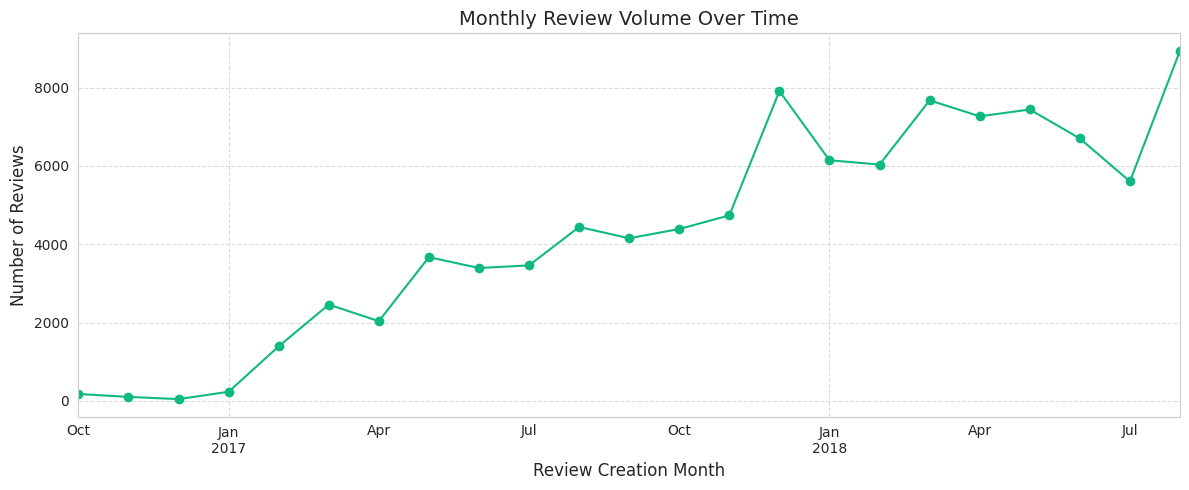

In [ ]:
plt.figure(figsize=(12, 5))
monthly_volume.plot(kind='line', marker='o', color='#10B981')
plt.title('Monthly Review Volume Over Time', fontsize=14)
plt.xlabel('Review Creation Month', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Visualization for Monthly Time Series Trend -  Monthly Average Review Score

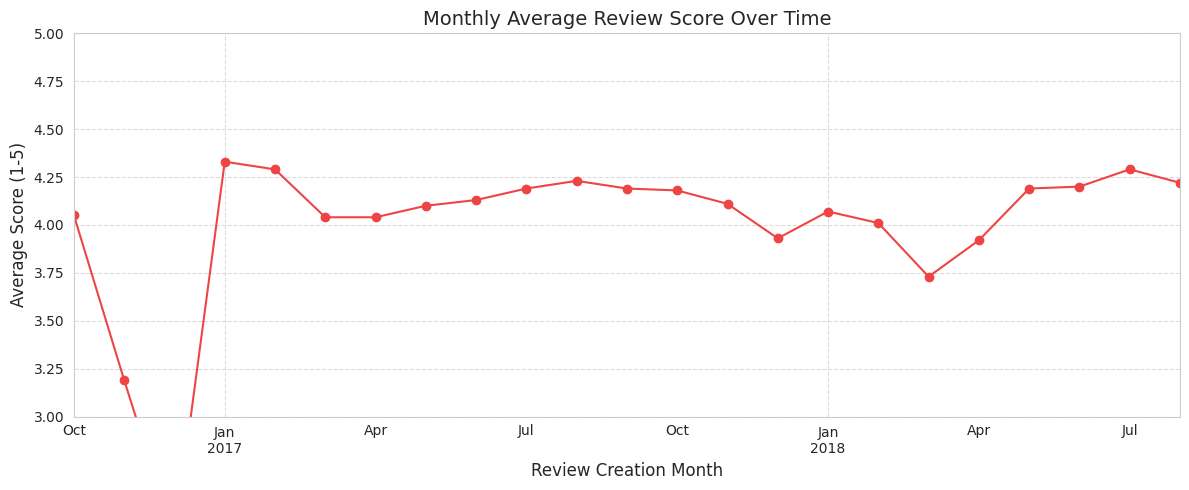

In [ ]:
plt.figure(figsize=(12, 5))
monthly_avg_score.plot(kind='line', marker='o', color='#EF4444')
plt.title('Monthly Average Review Score Over Time', fontsize=14)
plt.xlabel('Review Creation Month', fontsize=12)
plt.ylabel('Average Score (1-5)', fontsize=12)
plt.ylim(3.0, 5.0) # Set reasonable y-axis limits for score to focus on variance
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Review Response Time Analysis

In [ ]:
# Calculate the response time in hours (only for cases where the review was answered)
order_reviews_df['response_time_hours'] = (
    order_reviews_df['review_answer_timestamp'] - order_reviews_df['review_creation_date']
).dt.total_seconds() / 3600

# Filter out reviews where the answer time is before or the same as creation time (anomalies) or where answer time is missing
# A response time of 0 hours means the answer happened in the same second, which is fine.
# We will focus on positive response times.
answered_reviews = order_reviews_df[order_reviews_df['response_time_hours'] > 0].copy()

print("\nReview Response Time Analysis:")
print(f"Total answered reviews analyzed: {len(answered_reviews)}")
print(f"Average response time: {answered_reviews['response_time_hours'].mean()} hours")
print(f"Median response time: {answered_reviews['response_time_hours'].median()} hours")



Review Response Time Analysis:
Total answered reviews analyzed: 98410
Average response time: 75.60206462193317 hours
Median response time: 40.17583333333333 hours


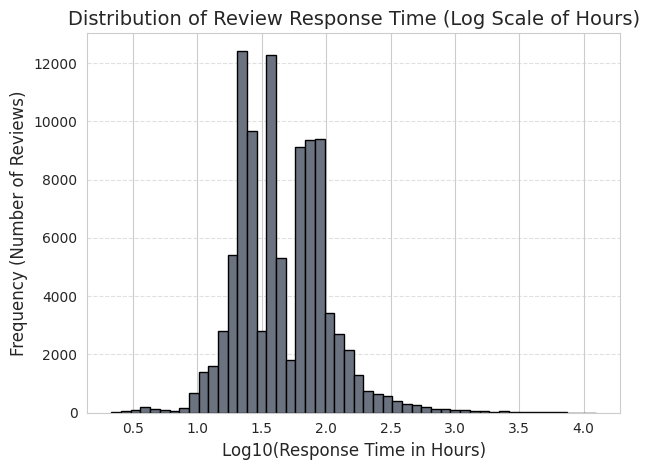

In [ ]:
# Plotting the distribution of the logarithm of response time to handle the long tail
log_response_time = np.log10(answered_reviews['response_time_hours'])
log_response_time.hist(bins=50, color='#6B7280', edgecolor='black')
plt.title('Distribution of Review Response Time (Log Scale of Hours)', fontsize=14)
plt.xlabel('Log10(Response Time in Hours)', fontsize=12)
plt.ylabel('Frequency (Number of Reviews)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Numerical columns in order_reviews_df: Index(['review_score', 'response_time', 'comment_length',
       'response_time_hours'],
      dtype='object')

--- Outlier Analysis for column: review_score ---


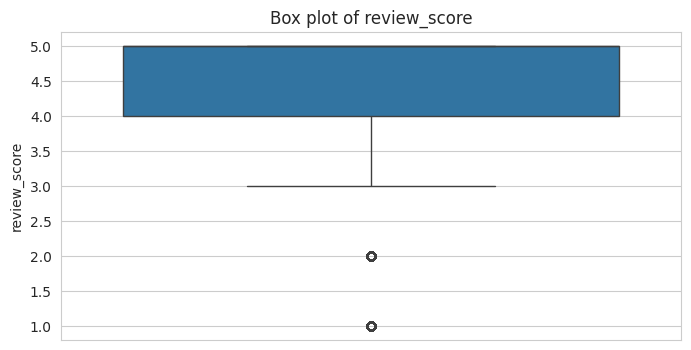

  Number of outliers: 14396
  Percentage of outliers: 14.63%
  Lower bound (IQR): 2.50
  Upper bound (IQR): 6.50

--- Outlier Analysis for column: response_time ---


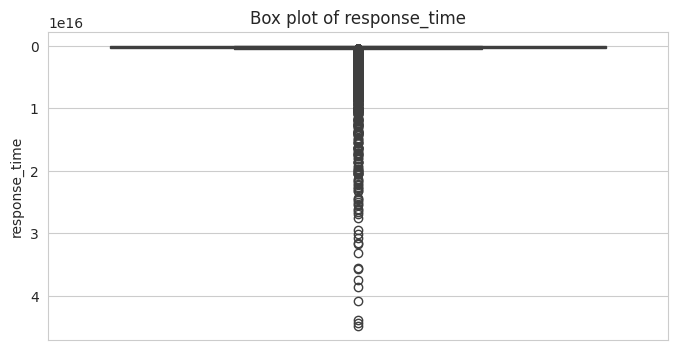

  Number of outliers: 6252
  Percentage of outliers: 6.35%


TypeError: unsupported format string passed to Timedelta.__format__

In [ ]:
# Identify numerical columns in order_reviews_df
numerical_cols_reviews = order_reviews_df.select_dtypes(include=np.number).columns

print("Numerical columns in order_reviews_df:", numerical_cols_reviews)

# Apply outlier detection and plotting for each numerical column
for col in numerical_cols_reviews:
    detect_and_plot_outliers_iqr(order_reviews_df, col)

Observations:
* Each row corresponds to exactly one review per order.
* review_score ranges from 1 to 5, with most orders having a rating.
* Many reviews lack textual comments (review_comment_title and review_comment_message have many nulls) which were later replaced by 'no comment' string.
* Review timestamps (review_creation_date, review_answer_timestamp) are stored as objects and will need datetime conversion for time series analysis.
* we found that there are 814 duplicated values in the review_id.
* This dataset can provide insights on customer satisfaction and correlate ratings with delivery times, sellers, or product categories during EDA.
* Number of outliers: 14396, but these outliers are part of rating which are given my customers and it can be highly negative or highly positive but these are essential for the ML.

## The code in the following cell loads the `olist_order_items_dataset.csv` file into a pandas DataFrame and displays the first few rows.

In [ ]:
# Load the order items dataset
order_items_dataset_path = os.path.join(path, "olist_order_items_dataset.csv")
order_items_df = pd.read_csv(order_items_dataset_path)

# Display the first few rows of the DataFrame
order_items_df.head()

order_id  order_item_id  \
0  00010242fe8c5a6d1ba2dd792cb16214              1   
1  00018f77f2f0320c557190d7a144bdd3              1   
2  000229ec398224ef6ca0657da4fc703e              1   
3  00024acbcdf0a6daa1e931b038114c75              1   
4  00042b26cf59d7ce69dfabb4e55b4fd9              1   

                         product_id                         seller_id  \
0  4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
1  e5f2d52b802189ee658865ca93d83a8f  dd7ddc04e1b6c2c614352b383efe2d36   
2  c777355d18b72b67abbeef9df44fd0fd  5b51032eddd242adc84c38acab88f23d   
3  7634da152a4610f1595efa32f14722fc  9d7a1d34a5052409006425275ba1c2b4   
4  ac6c3623068f30de03045865e4e10089  df560393f3a51e74553ab94004ba5c87   

   shipping_limit_date   price  freight_value  
0  2017-09-19 09:45:35   58.90          13.29  
1  2017-05-03 11:05:13  239.90          19.93  
2  2018-01-18 14:48:30  199.00          17.87  
3  2018-08-15 10:10:18   12.99          12.79  
4  2017-02-13 13:57:51  199.90          18.14

In [ ]:
# Get information about the order_items_df DataFrame
print(order_items_df.info())

# Display missing values information
print("\nMissing values in order_items_df:")
print(order_items_df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB
None

Missing values in order_items_df:
order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64


In [ ]:
order_items_df.rename(columns={"shipping_limit_date" : "shipping_deadline"}, inplace=True)
order_items_df['shipping_deadline'] = pd.to_datetime(order_items_df['shipping_deadline'])
print(f"Datatype after being handled carefully: \n{order_items_df.dtypes}")

Datatype after being handled carefully: 
order_id                     object
order_item_id                 int64
product_id                   object
seller_id                    object
shipping_deadline    datetime64[ns]
price                       float64
freight_value               float64
dtype: object


In [ ]:
# Duplicated Values
print(f"Duplicated values in order_reviews_df: {order_items_df.duplicated().sum()}")
print(f"Checking duplicates in the combination of order_id, item_is: {order_items_df.duplicated(subset=['order_id', 'order_item_id']).sum()}")


Duplicated values in order_reviews_df: 0
Checking duplicates in the combination of order_id, item_is: 0


Numerical columns in order_items_df: Index(['order_item_id', 'price', 'freight_value'], dtype='object')

--- Outlier Analysis for column: price ---


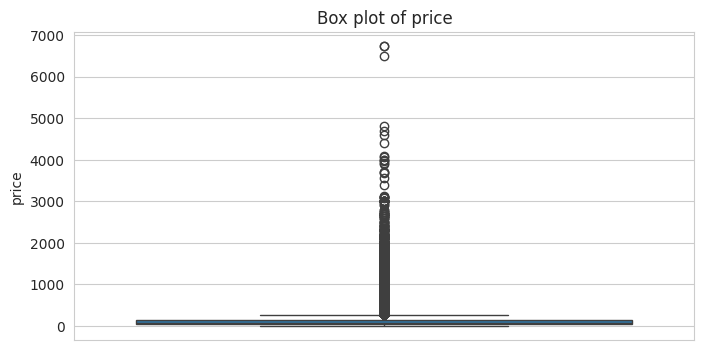

  Number of outliers: 8427
  Percentage of outliers: 7.48%
  Lower bound (IQR): -102.60
  Upper bound (IQR): 277.40

--- Outlier Analysis for column: freight_value ---


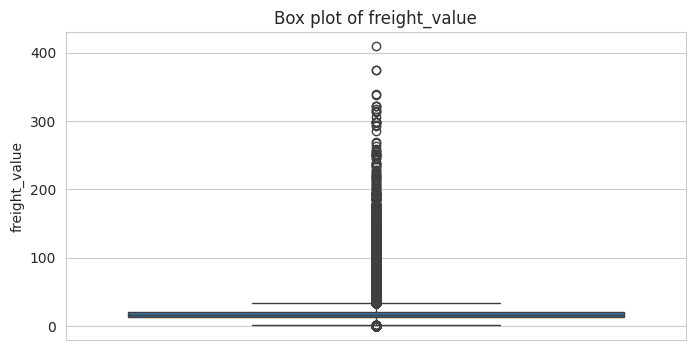

  Number of outliers: 12134
  Percentage of outliers: 10.77%
  Lower bound (IQR): 0.98
  Upper bound (IQR): 33.25


In [ ]:
# Identify numerical columns in order_items_df
numerical_cols_items = order_items_df.select_dtypes(include=np.number).columns

print("Numerical columns in order_items_df:", numerical_cols_items)

# Apply outlier detection and plotting for each numerical column
for col in numerical_cols_items:
    if col == 'order_item_id': # Exclude order_item_id from outlier detection
      continue
    detect_and_plot_outliers_iqr(order_items_df, col)

In [ ]:
# Let's find the outliers without removing them first
# Select only numerical columns for quantile calculation
numerical_order_items_df = order_items_df.select_dtypes(include=np.number)

Q1 = numerical_order_items_df.quantile(0.25)
Q3 = numerical_order_items_df.quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers for 'price' and 'freight_value' using their specific bounds
outliers_price = order_items_df[(order_items_df['price'] < lower_bound['price']) | (order_items_df['price'] > upper_bound['price'])]
outliers_freight = order_items_df[(order_items_df['freight_value'] < lower_bound['freight_value']) | (order_items_df['freight_value'] > upper_bound['freight_value'])]

print("--- Top 5 Price Outliers ---")
display(outliers_price.sort_values('price', ascending=False).head())

print("\n--- Top 5 Freight Value Outliers ---")
display(outliers_freight.sort_values('freight_value', ascending=False).head())

--- Top 5 Price Outliers ---


order_id  order_item_id  \
3556    0812eb902a67711a1cb742b3cdaa65ae              1   
112233  fefacc66af859508bf1a7934eab1e97f              1   
107841  f5136e38d1a14a4dbd87dff67da82701              1   
74336   a96610ab360d42a2e5335a3998b4718a              1   
11249   199af31afc78c699f0dbf71fb178d4d4              1   

                              product_id                         seller_id  \
3556    489ae2aa008f021502940f251d4cce7f  e3b4998c7a498169dc7bce44e6bb6277   
112233  69c590f7ffc7bf8db97190b6cb6ed62e  80ceebb4ee9b31afb6c6a916a574a1e2   
107841  1bdf5e6731585cf01aa8169c7028d6ad  ee27a8f15b1dded4d213a468ba4eb391   
74336   a6492cc69376c469ab6f61d8f44de961  59417c56835dd8e2e72f91f809cd4092   
11249   c3ed642d592594bb648ff4a04cee2747  59417c56835dd8e2e72f91f809cd4092   

         shipping_deadline   price  freight_value  
3556   2017-02-16 20:37:36  6735.0         194.31  
112233 2018-08-02 04:05:13  6729.0         193.21  
107841 2017-06-15 02:45:17  6499.0         227.66  
74336  2017-04-18 13:25:18  4799.0         151.34  
11249  2017-05-09 15:50:15  4690.0          74.34


--- Top 5 Freight Value Outliers ---


order_id  order_item_id  \
73486  a77e1550db865202c56b19ddc6dc4d53              1   
28044  3fde74c28a3d5d618c00f26d51baafa0              1   
3303   076d1555fb53a89b0ef4d529e527a0f6              1   
69797  9f49bd16053df810384e793386312674              1   
16731  264a7e199467906c0727394df82d1a6a              1   

                             product_id                         seller_id  \
73486  ec31d2a17b299511e7c8627be9337b9b  257e61d3251fb5efb9daadddbc2cf7ca   
28044  a3cd9517ebf5a50dca25acce54f3b171  6fa9202c10491e472dffd59a3e82b2a3   
3303   a3cd9517ebf5a50dca25acce54f3b171  6fa9202c10491e472dffd59a3e82b2a3   
69797  256a9c364b75753b97bee410c9491ad8  5c030029b5916fed0986310385ec9009   
16731  97c948ebc8c04b26b7bbb095d4228f2a  17f51e7198701186712e53a39c564617   

        shipping_deadline    price  freight_value  
73486 2018-04-25 06:55:13   979.00         409.68  
28044 2018-08-22 03:15:09  2338.08         375.28  
3303  2018-08-07 04:35:22  2338.08         375.28  
69797 2018-08-02 03:44:28  1149.00         339.59  
16731 2018-04-23 17:15:10  1050.00         338.30

By identifing outliers we can see that the outliers are not a result of a mistake by they are actually the outliers for expensive products. Since we cannot remove the outliers we will try to reduce it by using log transformation.

Log-transformed columns 'price_log' and 'freight_value_log' have been created.


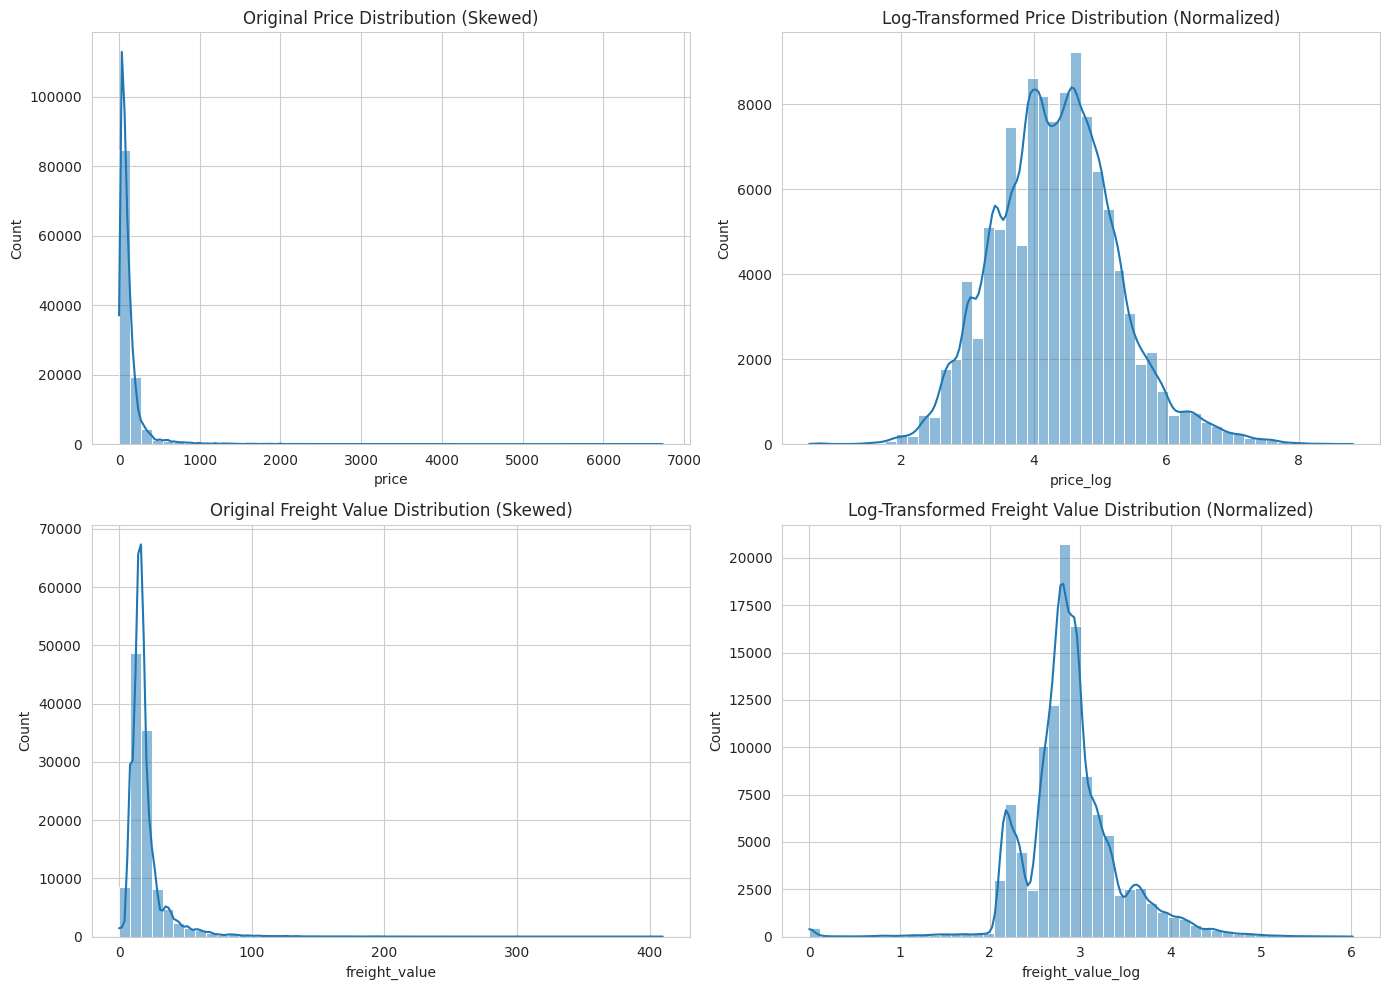

In [ ]:
order_items_df['price_log'] = np.log1p(order_items_df['price'])
order_items_df['freight_value_log'] = np.log1p(order_items_df['freight_value'])

print("Log-transformed columns 'price_log' and 'freight_value_log' have been created.")


# --- Step 2: Visualize the "Before and After" ---
# This will clearly show you why this method is so effective.
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Original distributions
sns.histplot(order_items_df['price'], bins=50, kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Original Price Distribution (Skewed)')

sns.histplot(order_items_df['freight_value'], bins=50, kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Original Freight Value Distribution (Skewed)')

# Log-transformed distributions
sns.histplot(order_items_df['price_log'], bins=50, kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Log-Transformed Price Distribution (Normalized)')

sns.histplot(order_items_df['freight_value_log'], bins=50, kde=True, ax=axes[1, 1])
axes[1, 1].set_title('Log-Transformed Freight Value Distribution (Normalized)')

plt.tight_layout()
plt.show()

Observations
* No missing values detected in this dataset.
* Each row represents an individual product item in an order:
* An order can have multiple rows (one per product).
* order_item_id is not a unique identifier by itself, but it helps identify the position of an item within a given order_id.
* price and freight_value will be critical for revenue and cost analysis in the EDA stage.
* Multiple outliers were identified in the price and freight_value but exactly they were the prices of the high-end/expensives products so we cannot remove it but in order to normalize it we transformed it using the logarithmic tranformation.

## Exploratory Data Analysis (EDA) for `olist_order_items_dataset.csv`

Order Structure and Item Multiplicity

In [ ]:
# Count the number of unique items per order
items_per_order = order_items_df['order_id'].value_counts()

# Calculate the distribution of items per order
items_distribution = items_per_order.value_counts().sort_index()

# Focus on the top 10 item counts for visualization
top_10_items = items_distribution.head(10)
other_items_count = items_distribution[10:].sum()
items_for_plot = pd.concat([top_10_items, pd.Series([other_items_count], index=['10+'])])

print("\nDistribution of Items per Order:")
print(items_for_plot)


Distribution of Items per Order:
1      88863
2       7516
3       1322
4        505
5        204
6        198
7         22
8          8
9          3
10         8
10+       17
dtype: int64


Visualization for Items per Order Distribution

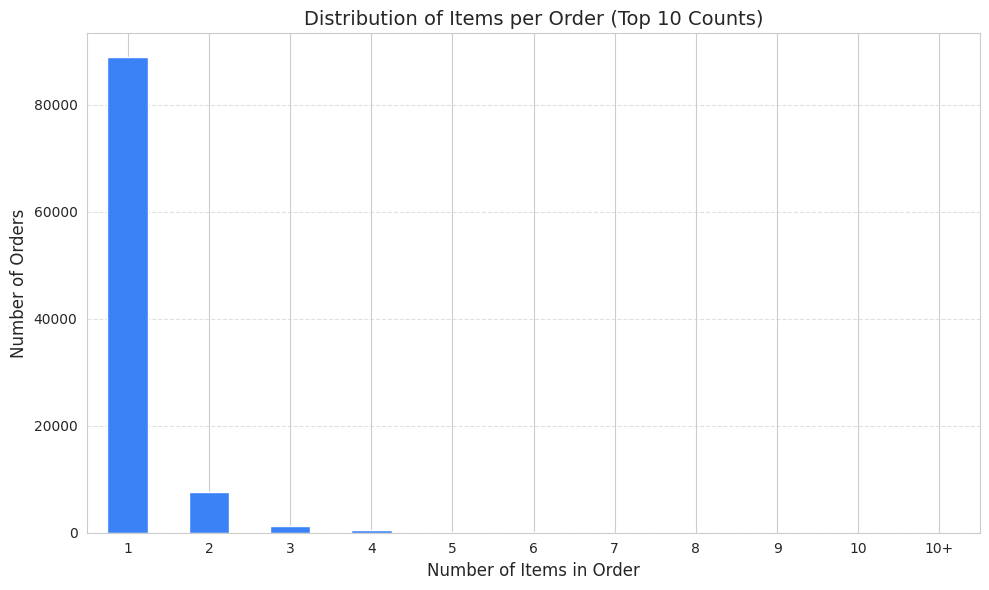

In [ ]:
plt.figure(figsize=(10, 6))
items_for_plot.plot(kind='bar', color='#3B82F6')
plt.title('Distribution of Items per Order (Top 10 Counts)', fontsize=14)
plt.xlabel('Number of Items in Order', fontsize=12)
plt.ylabel('Number of Orders', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Financial Metrics Distribution

In [ ]:
print("\nSummary Statistics for Price and Freight Value:")
print(order_items_df[['price', 'freight_value']].describe())


Summary Statistics for Price and Freight Value:
               price  freight_value
count  112650.000000  112650.000000
mean      120.653739      19.990320
std       183.633928      15.806405
min         0.850000       0.000000
25%        39.900000      13.080000
50%        74.990000      16.260000
75%       134.900000      21.150000
max      6735.000000     409.680000


Visualization for Price Distribution

Text(0, 0.5, 'Frequency')

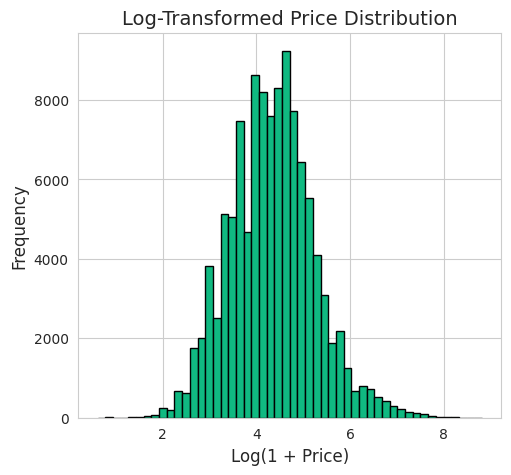

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
# Use log scale on price for better visualization due to right skewness
log_price = np.log1p(order_items_df['price'])
log_price.hist(bins=50, color='#10B981', edgecolor='black')
plt.title('Log-Transformed Price Distribution', fontsize=14)
plt.xlabel('Log(1 + Price)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

 Visualization for Freight Value Distribution

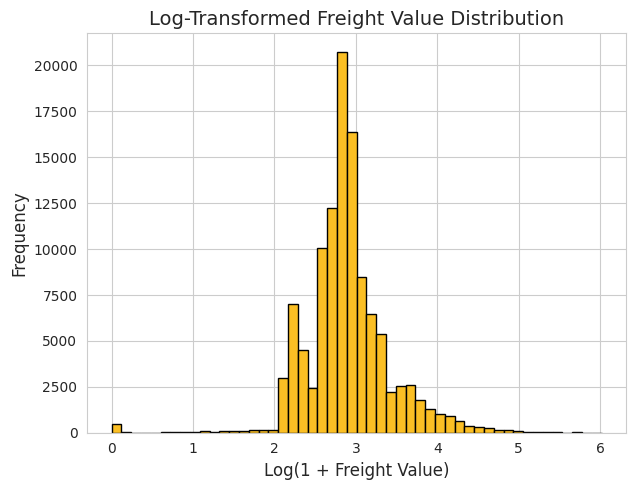

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 2)
# Use log scale on freight for better visualization
log_freight = np.log1p(order_items_df['freight_value'])
log_freight.hist(bins=50, color='#FBBF24', edgecolor='black')
plt.title('Log-Transformed Freight Value Distribution', fontsize=14)
plt.xlabel('Log(1 + Freight Value)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.tight_layout()
plt.show()


Relationship between Price and Freight


Bivariate Analysis: Price vs. Freight Value


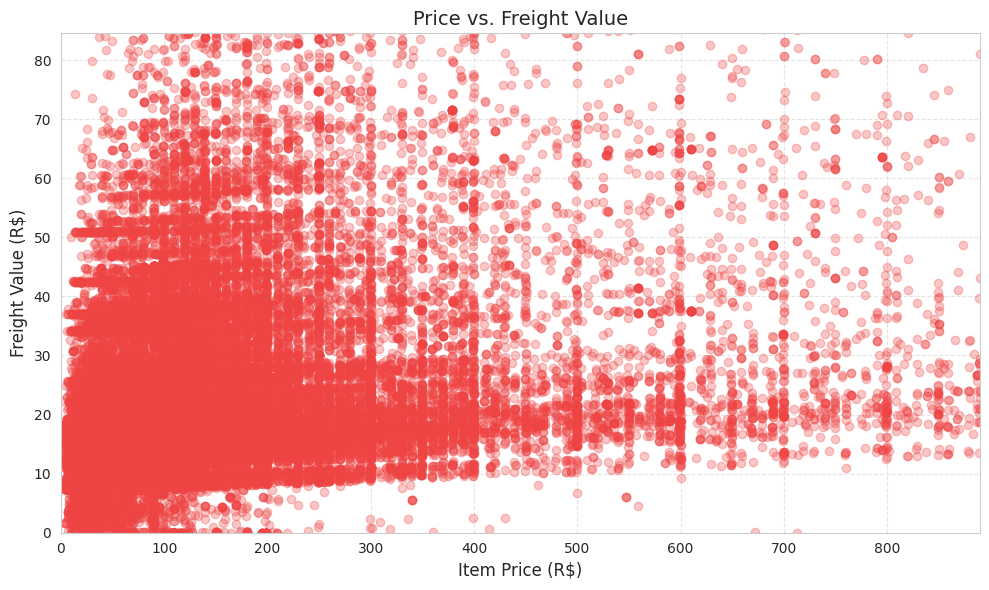

In [ ]:
print("\nBivariate Analysis: Price vs. Freight Value")

# --- Visualization for Price vs. Freight Value ---
plt.figure(figsize=(10, 6))
plt.scatter(order_items_df['price'], order_items_df['freight_value'], alpha=0.3, color='#EF4444')
plt.title('Price vs. Freight Value', fontsize=14)
plt.xlabel('Item Price (R$)', fontsize=12)
plt.ylabel('Freight Value (R$)', fontsize=12)
plt.grid(axis='both', linestyle='--', alpha=0.5)
# Set axis limits to focus on the majority of the data points, avoiding extreme outliers
plt.xlim(0, order_items_df['price'].quantile(0.99))
plt.ylim(0, order_items_df['freight_value'].quantile(0.99))
plt.tight_layout()
plt.show()

Top Sellers and Products (by Item Count)

In [ ]:
top_sellers = order_items_df['seller_id'].value_counts().head(5)
top_products = order_items_df['product_id'].value_counts().head(5)

print("\n4. Top 5 Sellers by Item Count:")
print(top_sellers)

print("\nTop 5 Products by Item Count:")
print(top_products)


4. Top 5 Sellers by Item Count:
seller_id
6560211a19b47992c3666cc44a7e94c0    2033
4a3ca9315b744ce9f8e9374361493884    1987
1f50f920176fa81dab994f9023523100    1931
cc419e0650a3c5ba77189a1882b7556a    1775
da8622b14eb17ae2831f4ac5b9dab84a    1551
Name: count, dtype: int64

Top 5 Products by Item Count:
product_id
aca2eb7d00ea1a7b8ebd4e68314663af    527
99a4788cb24856965c36a24e339b6058    488
422879e10f46682990de24d770e7f83d    484
389d119b48cf3043d311335e499d9c6b    392
368c6c730842d78016ad823897a372db    388
Name: count, dtype: int64


Visualization for Top Sellers by Item Count

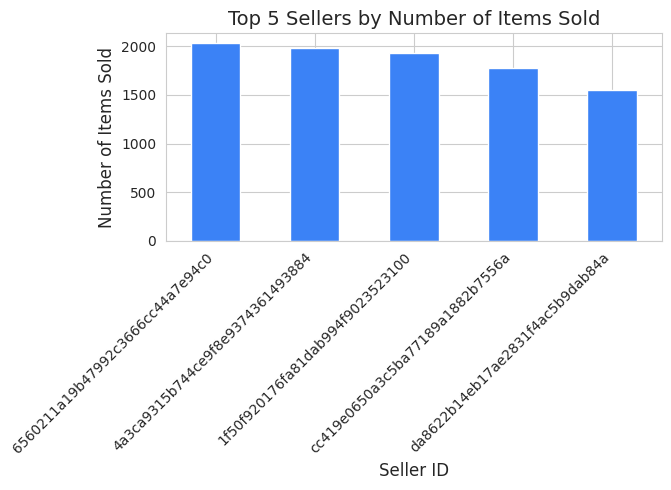

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
top_sellers.plot(kind='bar', color='#3B82F6')
plt.title('Top 5 Sellers by Number of Items Sold', fontsize=14)
plt.xlabel('Seller ID', fontsize=12)
plt.ylabel('Number of Items Sold', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

Visualization for Top Products by Item Count

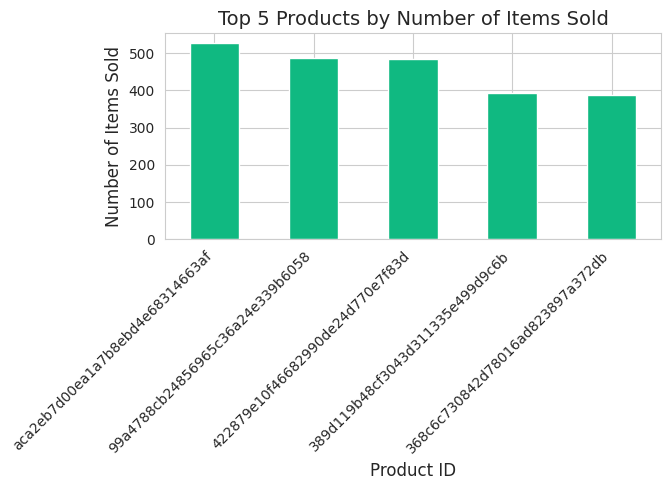

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 2)
top_products.plot(kind='bar', color='#10B981')
plt.title('Top 5 Products by Number of Items Sold', fontsize=14)
plt.xlabel('Product ID', fontsize=12)
plt.ylabel('Number of Items Sold', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Top Sellers and Products (by Item Count)

In [ ]:
top_sellers = order_items_df['seller_id'].value_counts().head(5)
top_products = order_items_df['product_id'].value_counts().head(5)

print("\nTop 5 Sellers by Item Count:")
print(top_sellers)

print("\nTop 5 Products by Item Count:")
print(top_products)


Top 5 Sellers by Item Count:
seller_id
6560211a19b47992c3666cc44a7e94c0    2033
4a3ca9315b744ce9f8e9374361493884    1987
1f50f920176fa81dab994f9023523100    1931
cc419e0650a3c5ba77189a1882b7556a    1775
da8622b14eb17ae2831f4ac5b9dab84a    1551
Name: count, dtype: int64

Top 5 Products by Item Count:
product_id
aca2eb7d00ea1a7b8ebd4e68314663af    527
99a4788cb24856965c36a24e339b6058    488
422879e10f46682990de24d770e7f83d    484
389d119b48cf3043d311335e499d9c6b    392
368c6c730842d78016ad823897a372db    388
Name: count, dtype: int64


 Visualization for Top Sellers and Products (Combined Bar Chart)

/tmp/ipython-input-2054376805.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_sellers.index, y=top_sellers.values, ax=axes[0], palette="cubehelix")
/tmp/ipython-input-2054376805.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_products.index, y=top_products.values, ax=axes[1], palette="cividis")


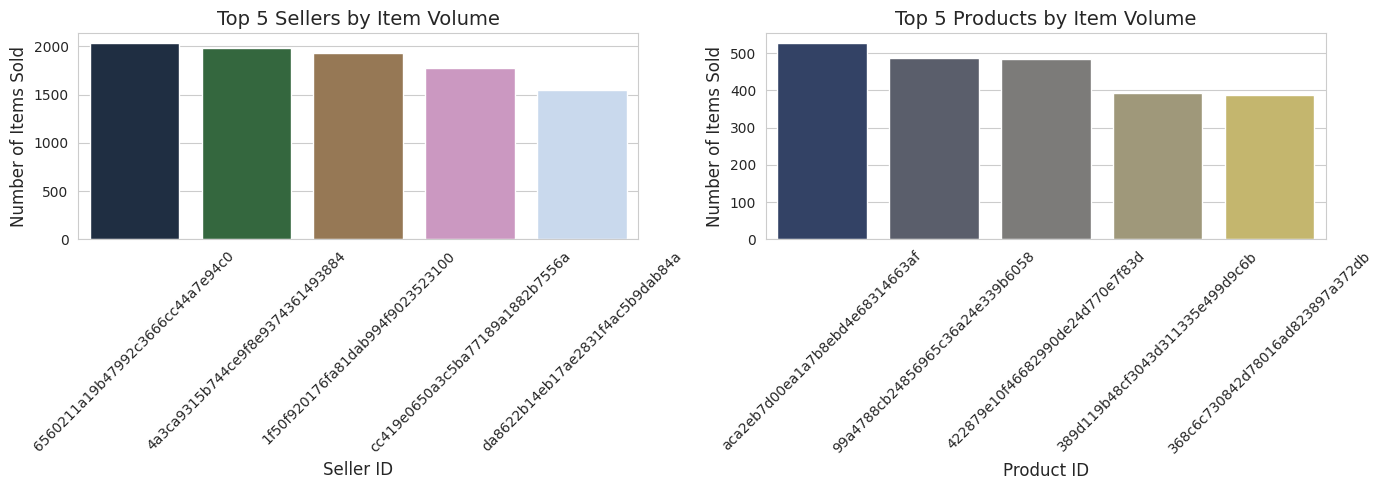

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.barplot(x=top_sellers.index, y=top_sellers.values, ax=axes[0], palette="cubehelix")
axes[0].set_title('Top 5 Sellers by Item Volume', fontsize=14)
axes[0].set_xlabel('Seller ID', fontsize=12)
axes[0].set_ylabel('Number of Items Sold', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)

sns.barplot(x=top_products.index, y=top_products.values, ax=axes[1], palette="cividis")
axes[1].set_title('Top 5 Products by Item Volume', fontsize=14)
axes[1].set_xlabel('Product ID', fontsize=12)
axes[1].set_ylabel('Number of Items Sold', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

DERIVED FEATURES

In [ ]:
# Ensure core price and freight columns are finite and fill NaN with 0 for calculation
order_items_df['price'] = order_items_df['price'].replace([np.inf, -np.inf], np.nan).fillna(0)
order_items_df['freight_value'] = order_items_df['freight_value'].replace([np.inf, -np.inf], np.nan).fillna(0)


In [ ]:
# New feature 1: Total Revenue per Item (Price + Freight)
order_items_df['total_item_revenue'] = order_items_df['price'] + order_items_df['freight_value']

# New feature 2: Freight-to-Price Ratio
# Add a small epsilon to price to avoid division by zero (for items with $0 price)
epsilon = 1e-6
order_items_df['freight_price_ratio'] = order_items_df['freight_value'] / (order_items_df['price'] + epsilon)

# Explicitly replace Inf values generated by ratio calculation with NaN
order_items_df['freight_price_ratio'] = order_items_df['freight_price_ratio'].replace([np.inf, -np.inf], np.nan)



Analysis of Freight-to-Price Ratio

In [ ]:
ratio_data = order_items_df[
    (order_items_df['freight_price_ratio'] < 5) &
    (order_items_df['price'] > 1)
]['freight_price_ratio'].dropna()

print("\nSummary Statistics for Freight-to-Price Ratio:")
print(ratio_data.describe())


Summary Statistics for Freight-to-Price Ratio:
count    112609.000000
mean          0.318259
std           0.310260
min           0.000000
25%           0.133995
50%           0.231273
75%           0.392832
max           4.810887
Name: freight_price_ratio, dtype: float64


Visualization for Freight-to-Price Ratio (VIOLIN PLOT)

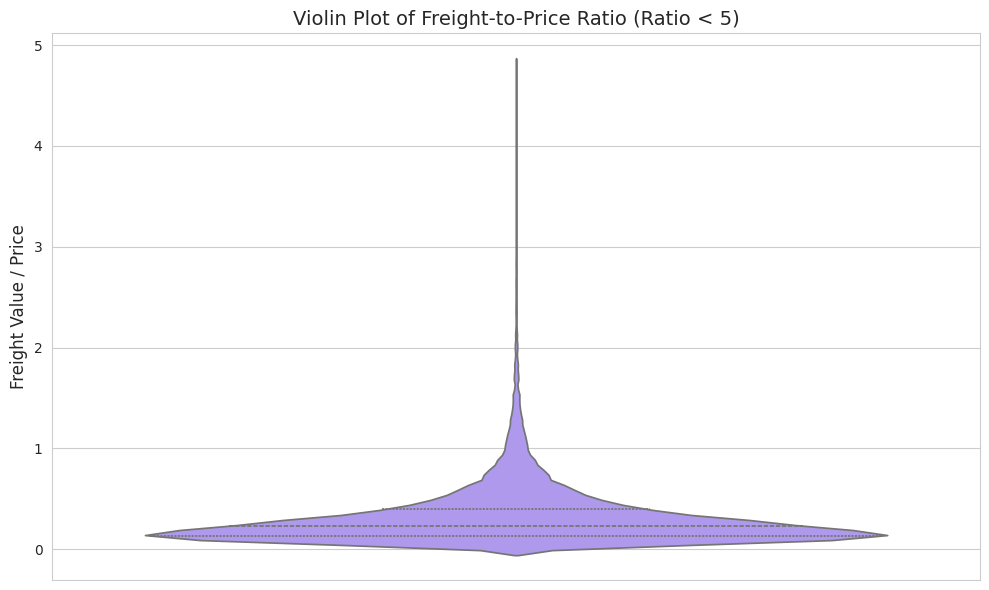

In [ ]:
plt.figure(figsize=(10, 6))
# Using a Violin Plot for a richer visualization of the distribution density
sns.violinplot(y=ratio_data, color="#A78BFA", inner="quartile")
plt.title('Violin Plot of Freight-to-Price Ratio (Ratio < 5)', fontsize=14)
plt.ylabel('Freight Value / Price', fontsize=12)
plt.tight_layout()
plt.show()

Distribution of Total Item Revenue

In [ ]:
revenue_cap = order_items_df['total_item_revenue'].quantile(0.99)
revenue_for_plot = order_items_df['total_item_revenue'].clip(upper=revenue_cap)
print("\nSummary Statistics for Total Item Revenue:")
print(order_items_df['total_item_revenue'].describe())


Summary Statistics for Total Item Revenue:
count    112650.000000
mean        140.644059
std         190.724394
min           6.080000
25%          55.220000
50%          92.320000
75%         157.937500
max        6929.310000
Name: total_item_revenue, dtype: float64


Visualization for Total Item Revenue

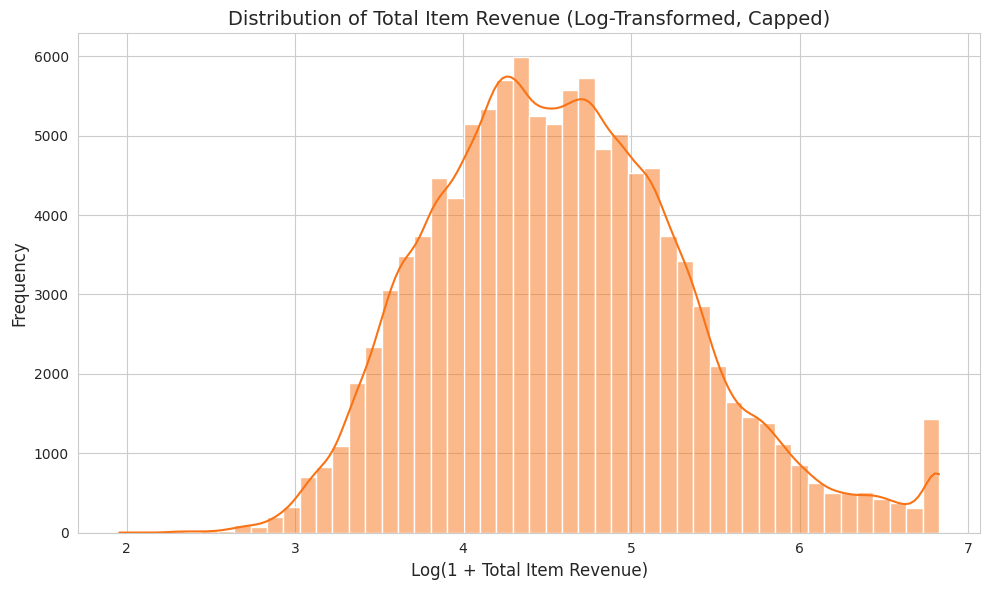

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(np.log1p(revenue_for_plot), bins=50, kde=True, color="#F97316")
plt.title('Distribution of Total Item Revenue (Log-Transformed, Capped)', fontsize=14)
plt.xlabel('Log(1 + Total Item Revenue)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.tight_layout()
plt.show()

Price Trend Over Time (Monthly)

In [ ]:
# Group by month and calculate the mean price
price_time_df = order_items_df.set_index('shipping_deadline').resample('M')['price'].mean().reset_index()

print("\nMonthly Price Trend Summary:")
print(price_time_df.describe())


Monthly Price Trend Summary:
         shipping_deadline       price
count                   44   26.000000
mean   2018-07-16 00:00:00  113.189616
min    2016-09-30 00:00:00   10.900000
25%    2017-08-23 06:00:00  112.878752
50%    2018-07-15 12:00:00  121.600100
75%    2019-06-07 12:00:00  126.070846
max    2020-04-30 00:00:00  146.489899
std                    NaN   28.404787


/tmp/ipython-input-2541429700.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  price_time_df = order_items_df.set_index('shipping_deadline').resample('M')['price'].mean().reset_index()


Visualization for Monthly Price Trend

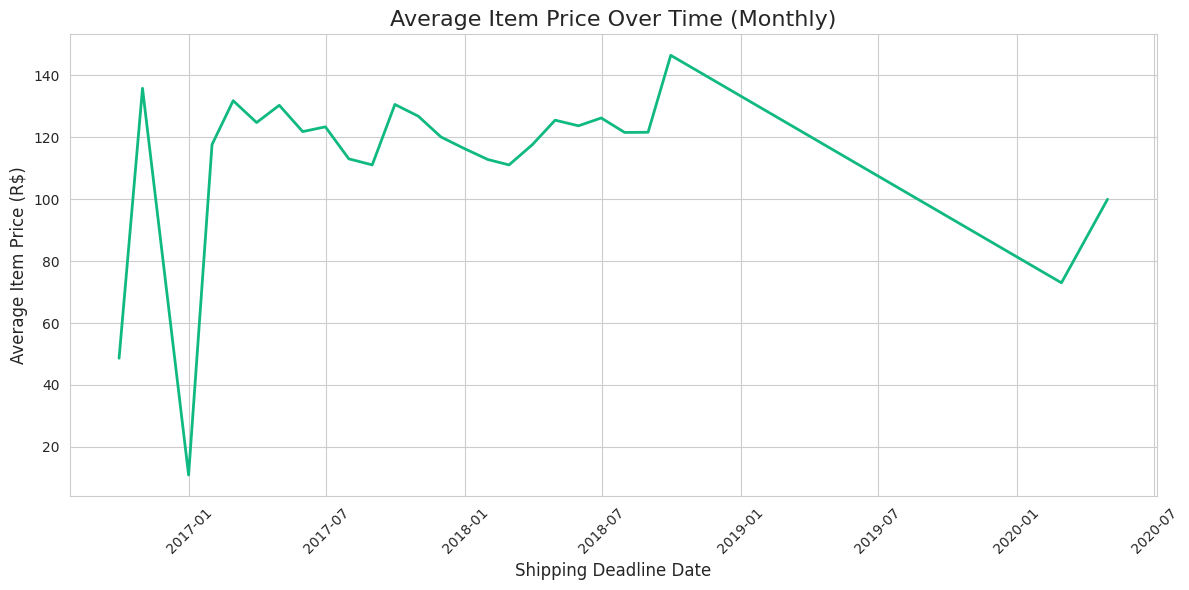

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=price_time_df, x='shipping_deadline', y='price', color='#10B981', linewidth=2)
plt.title('Average Item Price Over Time (Monthly)', fontsize=16)
plt.xlabel('Shipping Deadline Date', fontsize=12)
plt.ylabel('Average Item Price (R$)', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Seller Pricing Consistency (Price Standard Deviation)

In [ ]:
top_10_seller_ids = order_items_df['seller_id'].value_counts().head(10).index

# Filter data for only these top sellers
top_seller_df = order_items_df[order_items_df['seller_id'].isin(top_10_seller_ids)]

# Calculate mean price and standard deviation of price for each top seller
seller_price_stats = top_seller_df.groupby('seller_id')['price'].agg(['mean', 'std']).sort_values(by='std', ascending=False)
seller_price_stats = seller_price_stats.fillna(0) # Fill NaN std for sellers with only 1 item (if any)

print("\nTop 10 Sellers: Price Consistency (Mean vs. Std Dev):")
print(seller_price_stats)



Top 10 Sellers: Price Consistency (Mean vs. Std Dev):
                                        mean        std
seller_id                                              
955fee9216a65b617aa5c0531780ce60   90.174583  83.890235
1025f0e2d44d7041d6cf58b6550e0bfa   97.316912  82.740549
da8622b14eb17ae2831f4ac5b9dab84a  103.311779  68.695242
4a3ca9315b744ce9f8e9374361493884  100.892260  59.516612
7a67c85e85bb2ce8582c35f2203ad736  121.046567  54.462977
7c67e1448b00f6e969d365cea6b010ab  137.774113  47.199983
6560211a19b47992c3666cc44a7e94c0   60.651663  33.653670
cc419e0650a3c5ba77189a1882b7556a   58.754039  23.197700
ea8482cd71df3c1969d7b9473ff13abc   30.904007  18.491450
1f50f920176fa81dab994f9023523100   55.380223   6.932525


Visualization for Seller Pricing Consistency


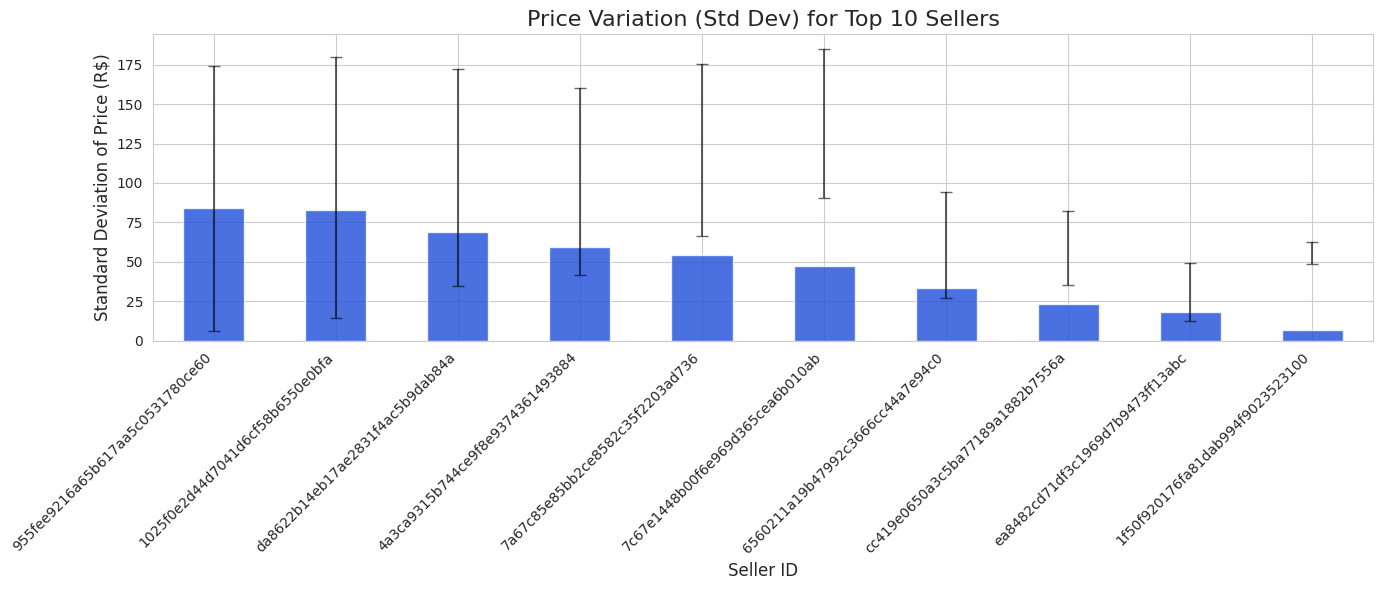

In [ ]:
plt.figure(figsize=(14, 6))
seller_price_stats['std'].sort_values(ascending=False).plot(kind='bar', color='#1D4ED8', alpha=0.8)
plt.errorbar(x=seller_price_stats.index, y=seller_price_stats['mean'], yerr=seller_price_stats['std'], fmt='none', capsize=4, color='black', alpha=0.6)
plt.title('Price Variation (Std Dev) for Top 10 Sellers', fontsize=16)
plt.xlabel('Seller ID', fontsize=12)
plt.ylabel('Standard Deviation of Price (R$)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
# Determine if an order has more than one item
# Use transform to broadcast the max item ID back to all rows of the order
item_count_per_order = order_items_df.groupby('order_id')['order_item_id'].transform('max')
order_items_df['is_multi_item'] = item_count_per_order > 1

# Group by the new flag and calculate mean metrics
multi_item_stats = order_items_df.groupby('is_multi_item')[['price', 'freight_value']].mean()

print("\nMulti-Item vs. Single-Item Order Economics (Mean Values):")
print(multi_item_stats)



Multi-Item vs. Single-Item Order Economics (Mean Values):
                    price  freight_value
is_multi_item                           
False          130.378012      20.368021
True            84.325994      18.579310


Visualization for Multi-Item Order Economics (Grouped Bar Chart)

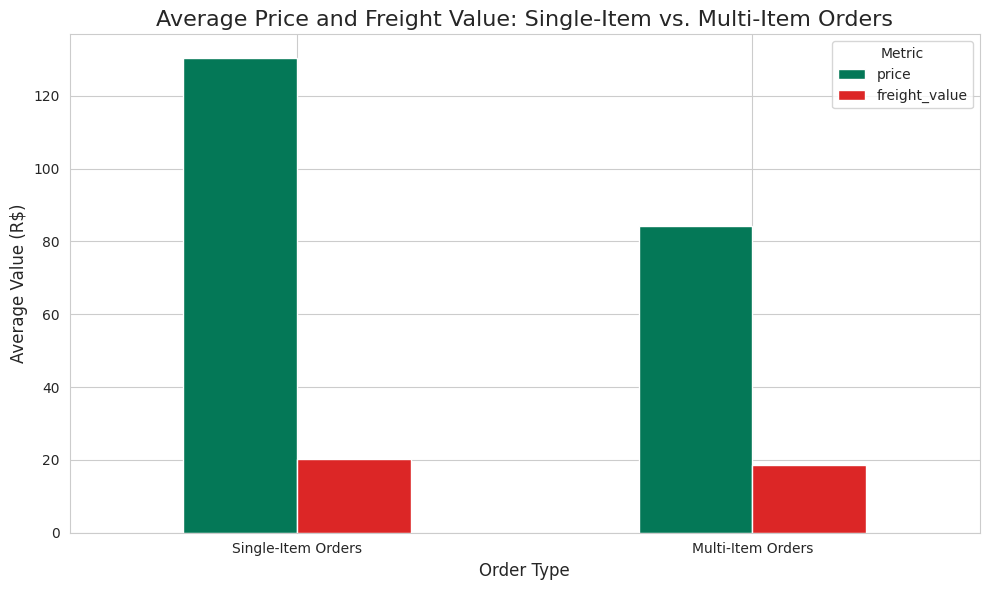

In [ ]:
multi_item_stats.index = ['Single-Item Orders', 'Multi-Item Orders']
multi_item_stats.plot(kind='bar', figsize=(10, 6), color=['#047857', '#DC2626'])
plt.title('Average Price and Freight Value: Single-Item vs. Multi-Item Orders', fontsize=16)
plt.xlabel('Order Type', fontsize=12)
plt.ylabel('Average Value (R$)', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Metric')
plt.tight_layout()
plt.show()

## The code in the following cell loads the `olist_products_dataset.csv` file into a pandas DataFrame and displays the first few rows.

In [ ]:
# Load the products dataset
products_dataset_path = os.path.join(path, "olist_products_dataset.csv")
products_df = pd.read_csv(products_dataset_path)

# Display the first few rows of the DataFrame
products_df.head()

product_id  product_category_name  \
0  1e9e8ef04dbcff4541ed26657ea517e5             perfumaria   
1  3aa071139cb16b67ca9e5dea641aaa2f                  artes   
2  96bd76ec8810374ed1b65e291975717f          esporte_lazer   
3  cef67bcfe19066a932b7673e239eb23d                  bebes   
4  9dc1a7de274444849c219cff195d0b71  utilidades_domesticas   

   product_name_lenght  product_description_lenght  product_photos_qty  \
0                 40.0                       287.0                 1.0   
1                 44.0                       276.0                 1.0   
2                 46.0                       250.0                 1.0   
3                 27.0                       261.0                 1.0   
4                 37.0                       402.0                 4.0   

   product_weight_g  product_length_cm  product_height_cm  product_width_cm  
0             225.0               16.0               10.0              14.0  
1            1000.0               30.0               18.0              20.0  
2             154.0               18.0                9.0              15.0  
3             371.0               26.0                4.0              26.0  
4             625.0               20.0               17.0              13.0

In [ ]:
# Get information about the products_df DataFrame
print(products_df.info())

# Display missing values information
print("\nMissing values in products_df:")
print(products_df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB
None

Missing values in products_df:
product_id                      0
product_category_name         610
product_name_lenght           610
product_description_lenght    610
product_photos_qty            610
produc

In [ ]:
products_df.rename(columns={
    "product_name_lenght" : "product_name_length",
    "product_description_lenght" : "product_description_length"
}, inplace=True)

In [ ]:
# Fill missing values in 'product_category_name' with 'unknown'
products_df['product_category_name'] = products_df['product_category_name'].fillna('unknown')

# Verify that missing values in 'product_category_name' have been handled
print("\nMissing values in products_df after filling 'product_category_name':")
print(products_df.isnull().sum())


Missing values in products_df after filling 'product_category_name':
product_id                      0
product_category_name           0
product_name_length           610
product_description_length    610
product_photos_qty            610
product_weight_g                2
product_length_cm               2
product_height_cm               2
product_width_cm                2
dtype: int64


In [ ]:
# Calculate the median of 'product_name_length', 'product_description_length', 'product_photos_qty', 'product_weight_g', 'product_length_cm', 'product_height_cm', and 'product_width_cm'
median_name_length = products_df['product_name_length'].median()
median_description_length = products_df['product_description_length'].median()
median_photos_qty = products_df['product_photos_qty'].median()
median_weight_g = products_df['product_weight_g'].median()
median_length_cm = products_df['product_length_cm'].median()
median_height_cm = products_df['product_height_cm'].median()
median_width_cm = products_df['product_width_cm'].median()


# Impute missing values in 'product_name_length', 'product_description_length', and 'product_photos_qty' with their medians
products_df['product_name_length'] = products_df['product_name_length'].fillna(median_name_length)
products_df['product_description_length'] = products_df['product_description_length'].fillna(median_description_length)
products_df['product_photos_qty'] = products_df['product_photos_qty'].fillna(median_photos_qty)

# Impute missing values in 'product_weight_g', 'product_length_cm', 'product_height_cm', and 'product_width_cm' with their medians
products_df['product_weight_g'] = products_df['product_weight_g'].fillna(median_weight_g)
products_df['product_length_cm'] = products_df['product_length_cm'].fillna(median_length_cm)
products_df['product_height_cm'] = products_df['product_height_cm'].fillna(median_height_cm)
products_df['product_width_cm'] = products_df['product_width_cm'].fillna(median_width_cm)


# Verify that missing values in 'product_name_length' have been handled
print("\nMissing values in products_df after imputing numerical columns:")
print(products_df.isnull().sum())


Missing values in products_df after imputing numerical columns:
product_id                    0
product_category_name         0
product_name_length           0
product_description_length    0
product_photos_qty            0
product_weight_g              0
product_length_cm             0
product_height_cm             0
product_width_cm              0
dtype: int64


In [ ]:
# Duplicated Values
print(f"Duplicated values in order_reviews_df: {products_df.duplicated().sum()}")
print(f"Duplicated values in order_reviews_df['product_id']: {products_df['product_id'].duplicated().sum()}")

Duplicated values in order_reviews_df: 0
Duplicated values in order_reviews_df['product_id']: 0


Numerical columns in order_items_df: Index(['product_name_length', 'product_description_length',
       'product_photos_qty', 'product_weight_g', 'product_length_cm',
       'product_height_cm', 'product_width_cm'],
      dtype='object')

--- Outlier Analysis for column: product_name_length ---


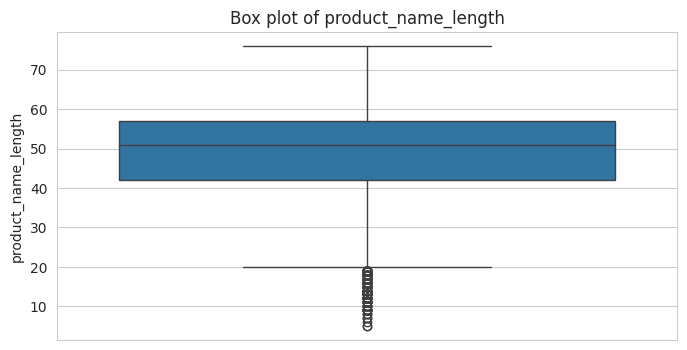

  Number of outliers: 290
  Percentage of outliers: 0.88%
  Lower bound (IQR): 19.50
  Upper bound (IQR): 79.50

--- Outlier Analysis for column: product_description_length ---


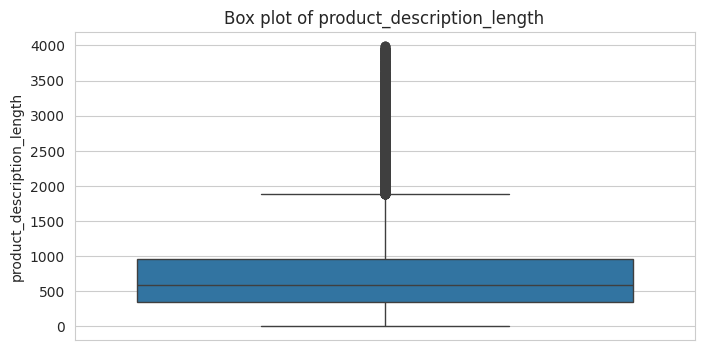

  Number of outliers: 2174
  Percentage of outliers: 6.60%
  Lower bound (IQR): -581.50
  Upper bound (IQR): 1886.50

--- Outlier Analysis for column: product_photos_qty ---


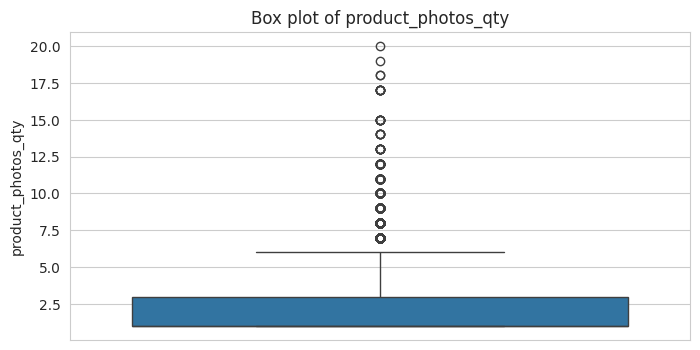

  Number of outliers: 849
  Percentage of outliers: 2.58%
  Lower bound (IQR): -2.00
  Upper bound (IQR): 6.00

--- Outlier Analysis for column: product_weight_g ---


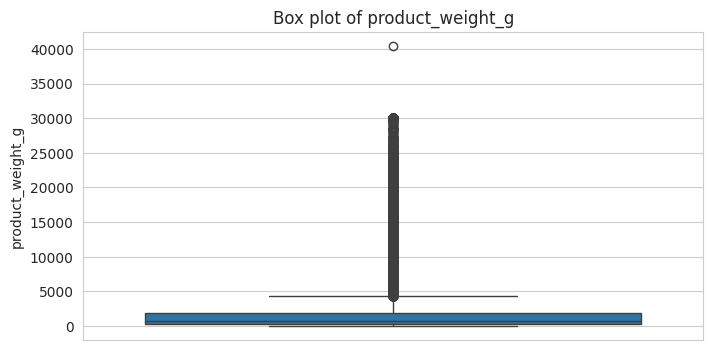

  Number of outliers: 4551
  Percentage of outliers: 13.81%
  Lower bound (IQR): -2100.00
  Upper bound (IQR): 4300.00

--- Outlier Analysis for column: product_length_cm ---


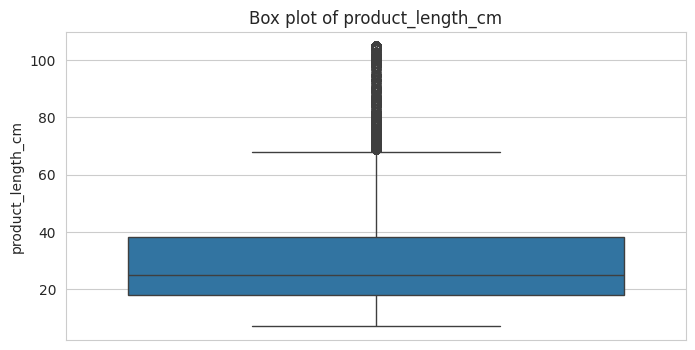

  Number of outliers: 1380
  Percentage of outliers: 4.19%
  Lower bound (IQR): -12.00
  Upper bound (IQR): 68.00

--- Outlier Analysis for column: product_height_cm ---


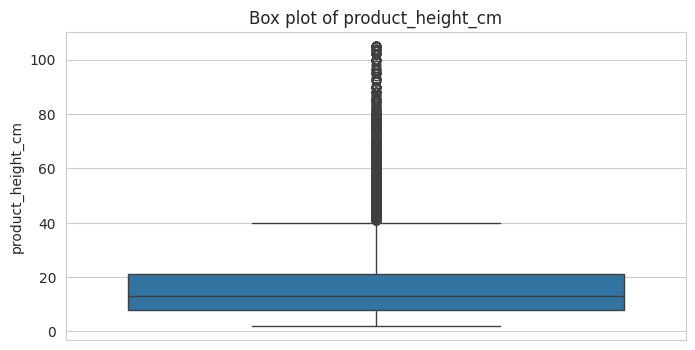

  Number of outliers: 1892
  Percentage of outliers: 5.74%
  Lower bound (IQR): -11.50
  Upper bound (IQR): 40.50

--- Outlier Analysis for column: product_width_cm ---


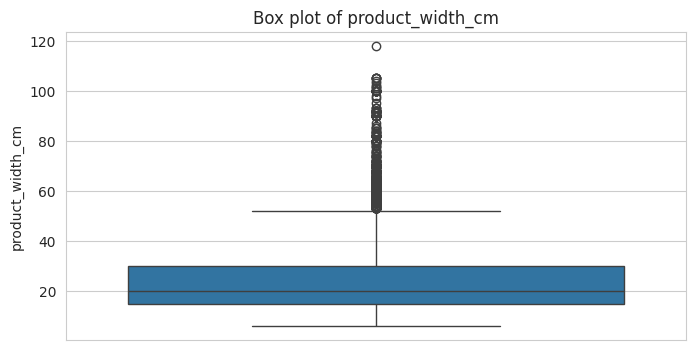

  Number of outliers: 912
  Percentage of outliers: 2.77%
  Lower bound (IQR): -7.50
  Upper bound (IQR): 52.50


In [ ]:
# Identify numerical columns in order_items_df
numerical_cols_items = products_df.select_dtypes(include=np.number).columns

print("Numerical columns in order_items_df:", numerical_cols_items)

# Apply outlier detection and plotting for each numerical column
for col in numerical_cols_items:
    detect_and_plot_outliers_iqr(products_df, col)

In [ ]:
products_df['product_weight_g_log'] = np.log1p(products_df['product_weight_g'])

# Optional but recommended: Create and transform volume
products_df['product_volume_cm3'] = products_df['product_length_cm'] * products_df['product_height_cm'] * products_df['product_width_cm']
products_df['product_volume_cm3_log'] = np.log1p(products_df['product_volume_cm3'])

print("Log-transformed columns for weight and volume have been created.")

# --- 2. Cap the Product Description Length ---
# Calculate the 99th percentile
desc_len_cap = products_df['product_description_length'].quantile(0.99)
print(f"Product description length will be capped at: {desc_len_cap:.0f} characters.")

# Create a new capped column
products_df['product_description_length_capped'] = products_df['product_description_length'].clip(upper=desc_len_cap)

print("Capped column for description length has been created.")

# --- 3. Do Nothing for Photos Qty and Name Length ---
print("No changes made to 'product_photos_qty' or 'product_name_length'.")

# Display the new columns
print("\nDataFrame with new transformed/capped columns:")
display(products_df[['product_weight_g', 'product_weight_g_log', 'product_volume_cm3', 'product_volume_cm3_log', 'product_description_length', 'product_description_length_capped']].head())


Log-transformed columns for weight and volume have been created.
Product description length will be capped at: 3274 characters.
Capped column for description length has been created.
No changes made to 'product_photos_qty' or 'product_name_length'.

DataFrame with new transformed/capped columns:


product_weight_g  product_weight_g_log  product_volume_cm3  \
0             225.0              5.420535              2240.0   
1            1000.0              6.908755             10800.0   
2             154.0              5.043425              2430.0   
3             371.0              5.918894              2704.0   
4             625.0              6.439350              4420.0   

   product_volume_cm3_log  product_description_length  \
0                7.714677                       287.0   
1                9.287394                       276.0   
2                7.796058                       250.0   
3                7.902857                       261.0   
4                8.394121                       402.0   

   product_description_length_capped  
0                              287.0  
1                              276.0  
2                              250.0  
3                              261.0  
4                              402.0

Observations
* The dataset includes product identifiers, product categories (in Portuguese), and physical attributes such as length, height, width, and weight.
* Around 1.85% of entries have missing values in category and product description-related columns, should be addressed by filling it with either unknown or with median values.
* Only a negligible number of missing values are present in the physical dimension columns.
* Some products share the same category ID, which will be translated into English using the product_category dataset.
* Product dimensions and weight will be valuable for analyzing shipping costs and understanding product characteristics in later EDA.

In [ ]:
products_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 13 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   product_id                         32951 non-null  object 
 1   product_category_name              32951 non-null  object 
 2   product_name_length                32951 non-null  float64
 3   product_description_length         32951 non-null  float64
 4   product_photos_qty                 32951 non-null  float64
 5   product_weight_g                   32951 non-null  float64
 6   product_length_cm                  32951 non-null  float64
 7   product_height_cm                  32951 non-null  float64
 8   product_width_cm                   32951 non-null  float64
 9   product_weight_g_log               32951 non-null  float64
 10  product_volume_cm3                 32951 non-null  float64
 11  product_volume_cm3_log             32951 non-null  flo

## Exploratory Data Analysis (EDA) for `olist_products_dataset.csv`

In [ ]:
products_df.describe()

product_name_length  product_description_length  product_photos_qty  \
count         32951.000000                32951.000000        32951.000000   
mean             48.523656                  768.227945            2.166975   
std              10.156155                  629.658469            1.728063   
min               5.000000                    4.000000            1.000000   
25%              42.000000                  344.000000            1.000000   
50%              51.000000                  595.000000            1.000000   
75%              57.000000                  961.000000            3.000000   
max              76.000000                 3992.000000           20.000000   

       product_weight_g  product_length_cm  product_height_cm  \
count      32951.000000       32951.000000       32951.000000   
mean        2276.376802          30.814725          16.937422   
std         4281.926387          16.914005          13.637175   
min            0.000000           7.000000           2.000000   
25%          300.000000          18.000000           8.000000   
50%          700.000000          25.000000          13.000000   
75%         1900.000000          38.000000          21.000000   
max        40425.000000         105.000000         105.000000   

       product_width_cm  product_weight_g_log  product_volume_cm3  \
count      32951.000000          32951.000000        32951.000000   
mean          23.196534              6.727443        16563.485843   
std           12.078707              1.348575        27056.334089   
min            6.000000              0.000000          168.000000   
25%           15.000000              5.707110         2880.000000   
50%           20.000000              6.552508         6840.000000   
75%           30.000000              7.550135        18480.000000   
max          118.000000             10.607228       296208.000000   

       product_volume_cm3_log  product_description_length_capped  
count            32951.000000                       32951.000000  
mean                 8.884659                         764.401202  
std                  1.309124                         612.662317  
min                  5.129899                           4.000000  
25%                  7.965893                         344.000000  
50%                  8.830689                         595.000000  
75%                  9.824498                         961.000000  
max                 12.598821                        3274.500000

Categorical Analysis: Product Categories

In [ ]:
print("\nProduct Category Analysis:")
unique_categories = products_df['product_category_name'].nunique()
print(f"Total number of unique product categories: {unique_categories}")

top_10_categories = products_df['product_category_name'].value_counts().head(10)
print("\nTop 10 Most Frequent Product Categories:")
print(top_10_categories)


Product Category Analysis:
Total number of unique product categories: 74

Top 10 Most Frequent Product Categories:
product_category_name
cama_mesa_banho           3029
esporte_lazer             2867
moveis_decoracao          2657
beleza_saude              2444
utilidades_domesticas     2335
automotivo                1900
informatica_acessorios    1639
brinquedos                1411
relogios_presentes        1329
telefonia                 1134
Name: count, dtype: int64


Visualize top 10 categories

/tmp/ipython-input-3440845846.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_10_categories.values, y=top_10_categories.index, palette='viridis')


Bar chart of top 10 categories saved as 'top_10_categories.png'


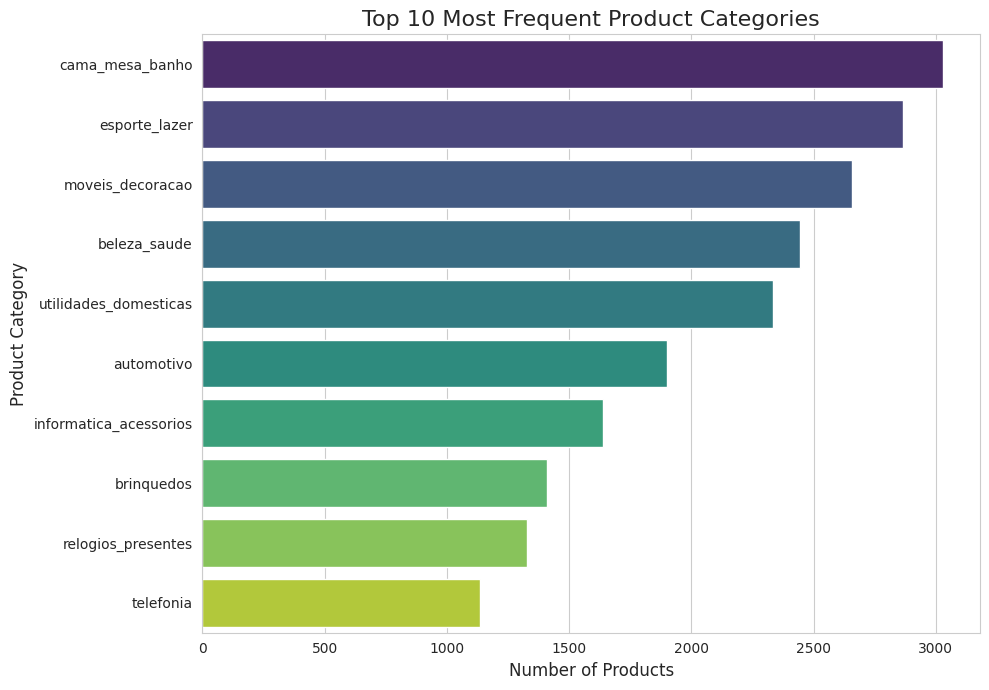

In [ ]:
plt.figure(figsize=(10, 7))
sns.barplot(x=top_10_categories.values, y=top_10_categories.index, palette='viridis')
plt.title('Top 10 Most Frequent Product Categories', fontsize=16)
plt.xlabel('Number of Products', fontsize=12)
plt.ylabel('Product Category', fontsize=12)
plt.tight_layout()
plt.savefig('top_10_categories.png')
print("Bar chart of top 10 categories saved as 'top_10_categories.png'")

Numerical Analysis: Distributions of transformed features


Numerical Feature Distributions:
Histograms of numerical distributions saved as 'numerical_distributions.png'


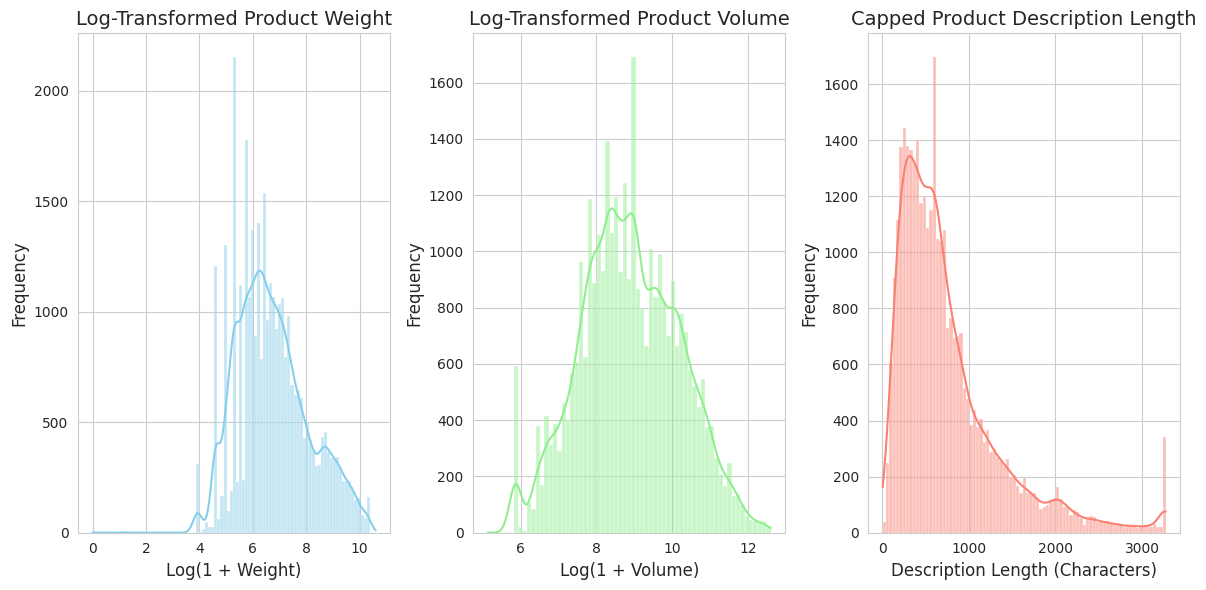

In [ ]:
print("\nNumerical Feature Distributions:")

# Visualize distributions of weight, volume, and description length
fig, axes = plt.subplots(1, 3, figsize=(12, 6))

sns.histplot(products_df['product_weight_g_log'], kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('Log-Transformed Product Weight', fontsize=14)
axes[0].set_xlabel('Log(1 + Weight)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)

sns.histplot(products_df['product_volume_cm3_log'], kde=True, ax=axes[1], color='lightgreen')
axes[1].set_title('Log-Transformed Product Volume', fontsize=14)
axes[1].set_xlabel('Log(1 + Volume)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)

sns.histplot(products_df['product_description_length_capped'], kde=True, ax=axes[2], color='salmon')
axes[2].set_title('Capped Product Description Length', fontsize=14)
axes[2].set_xlabel('Description Length (Characters)', fontsize=12)
axes[2].set_ylabel('Frequency', fontsize=12)

plt.tight_layout()
plt.savefig('numerical_distributions.png')
print("Histograms of numerical distributions saved as 'numerical_distributions.png'")


Bivariate Analysis: Product Weight vs. Volume


Bivariate Analysis: Product Weight vs. Volume
Scatter plot of weight vs. volume saved as 'weight_volume_scatter.png'


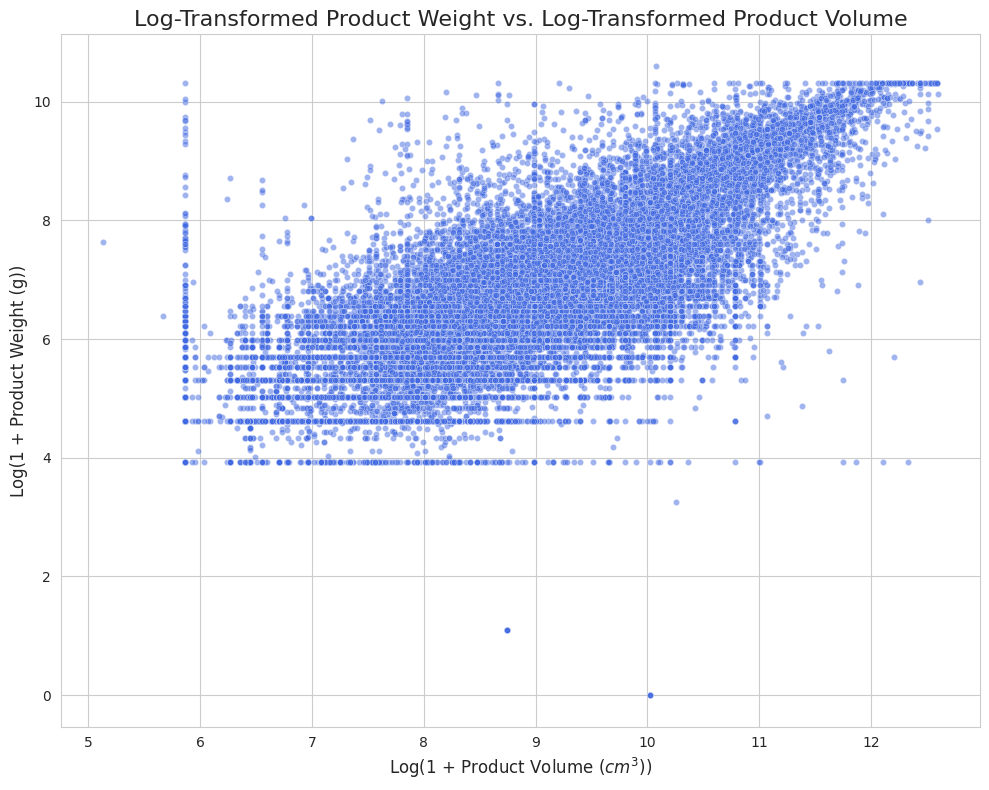

In [ ]:
print("\nBivariate Analysis: Product Weight vs. Volume")

plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=products_df,
    x='product_volume_cm3_log',
    y='product_weight_g_log',
    alpha=0.5,
    color='royalblue',
    s=20
)
plt.title('Log-Transformed Product Weight vs. Log-Transformed Product Volume', fontsize=16)
plt.xlabel('Log(1 + Product Volume ($cm^3$))', fontsize=12)
plt.ylabel('Log(1 + Product Weight (g))', fontsize=12)
plt.tight_layout()
plt.savefig('weight_volume_scatter.png')
print("Scatter plot of weight vs. volume saved as 'weight_volume_scatter.png'")

Product Photos Quantity Analysis


Product Photos Quantity Analysis:

Distribution of Product Photo Quantities:
product_photos_qty
1.0     17099
2.0      6263
3.0      3860
4.0      2428
5.0      1484
6.0       968
7.0       343
8.0       192
9.0       105
10.0       95
11.0       46
12.0       35
13.0        9
14.0        5
15.0        8
17.0        7
18.0        2
19.0        1
20.0        1
Name: count, dtype: int64


/tmp/ipython-input-3314850975.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=photo_counts.index, y=photo_counts.values, palette='coolwarm')


Bar chart of photo quantities saved as 'photo_quantity_distribution.png'


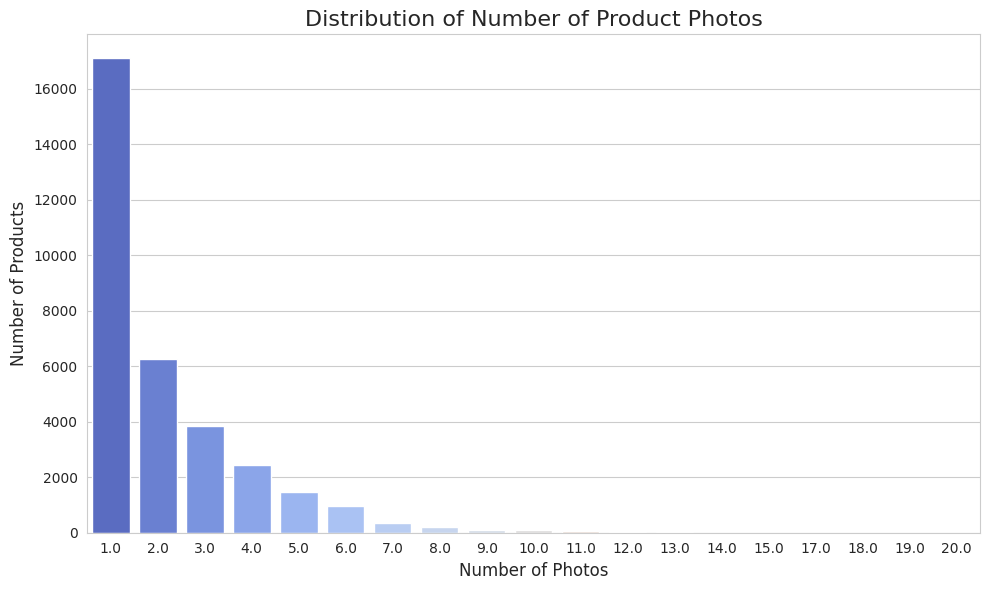

In [ ]:
print("\nProduct Photos Quantity Analysis:")
photo_counts = products_df['product_photos_qty'].value_counts().sort_index()
print("\nDistribution of Product Photo Quantities:")
print(photo_counts)

# Visualize photo quantity distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=photo_counts.index, y=photo_counts.values, palette='coolwarm')
plt.title('Distribution of Number of Product Photos', fontsize=16)
plt.xlabel('Number of Photos', fontsize=12)
plt.ylabel('Number of Products', fontsize=12)
plt.tight_layout()
plt.savefig('photo_quantity_distribution.png')
print("Bar chart of photo quantities saved as 'photo_quantity_distribution.png'")

In [ ]:
# --- NEW DERIVED FEATURES FOR EXTENDED EDA ---
# 1. Density Proxy: Weight / Volume (Log-transformed ratio)
# Adding a small epsilon to volume to prevent division by zero for very small items
products_df['product_density_proxy'] = products_df['product_weight_g'] / (products_df['product_volume_cm3'] + 1e-6)
products_df['product_density_proxy_log'] = np.log1p(products_df['product_density_proxy'])

# 2. Packaging Ratio: Efficiency of shape (Volume to the power of 1/3)
# This is often used to approximate how 'cube-like' an object is.
products_df['packaging_efficiency'] = products_df['product_length_cm'] * products_df['product_width_cm'] * products_df['product_height_cm'] / (products_df['product_length_cm'] + products_df['product_width_cm'] + products_df['product_height_cm'])
products_df['packaging_efficiency'] = products_df['packaging_efficiency'].replace([np.inf, -np.inf], np.nan).fillna(0)


Analysis of Product Density (Weight/Volume)


Product Density Analysis (Log-Transformed Weight/Volume):
count    32951.000000
mean         0.153166
std          0.179154
min          0.000000
25%          0.064079
50%          0.110244
75%          0.178873
max          4.456987
Name: product_density_proxy_log, dtype: float64


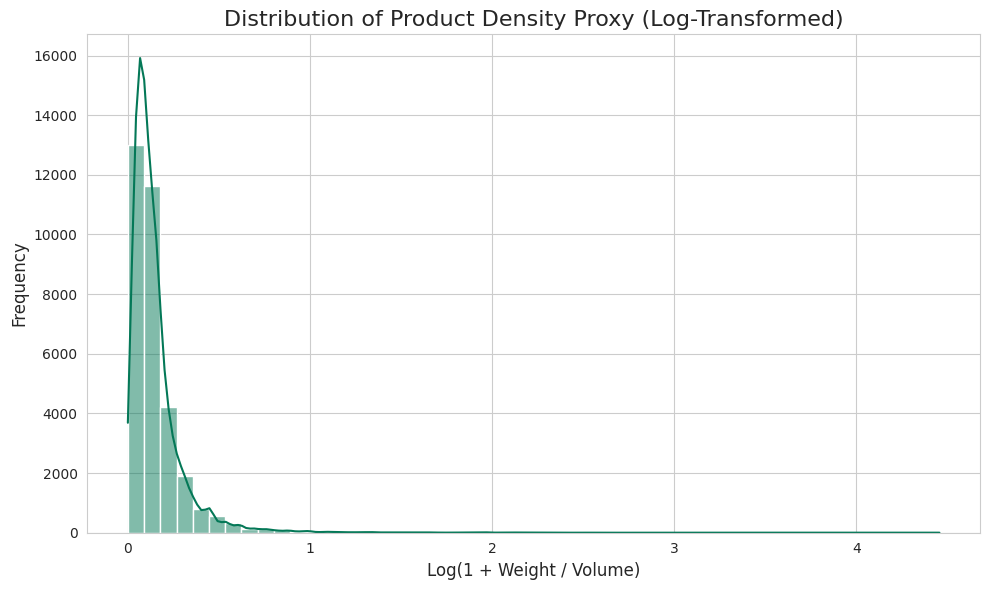

In [ ]:
print("\nProduct Density Analysis (Log-Transformed Weight/Volume):")
density_stats = products_df['product_density_proxy_log'].describe()
print(density_stats)

# --- Visualization for Product Density Distribution ---
plt.figure(figsize=(10, 6))
sns.histplot(products_df['product_density_proxy_log'], bins=50, kde=True, color='#047857')
plt.title('Distribution of Product Density Proxy (Log-Transformed)', fontsize=16)
plt.xlabel('Log(1 + Weight / Volume)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.tight_layout()
plt.show()


Top 5 Categories by Density


6. Top 5 Categories by Average Product Density:
product_category_name
livros_tecnicos                      0.402991
livros_importados                    0.301824
fashion_roupa_feminina               0.300770
dvds_blu_ray                         0.265451
construcao_ferramentas_construcao    0.262024
Name: product_density_proxy_log, dtype: float64


/tmp/ipython-input-1178120986.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_5_dense_categories.values, y=top_5_dense_categories.index, palette='rocket')


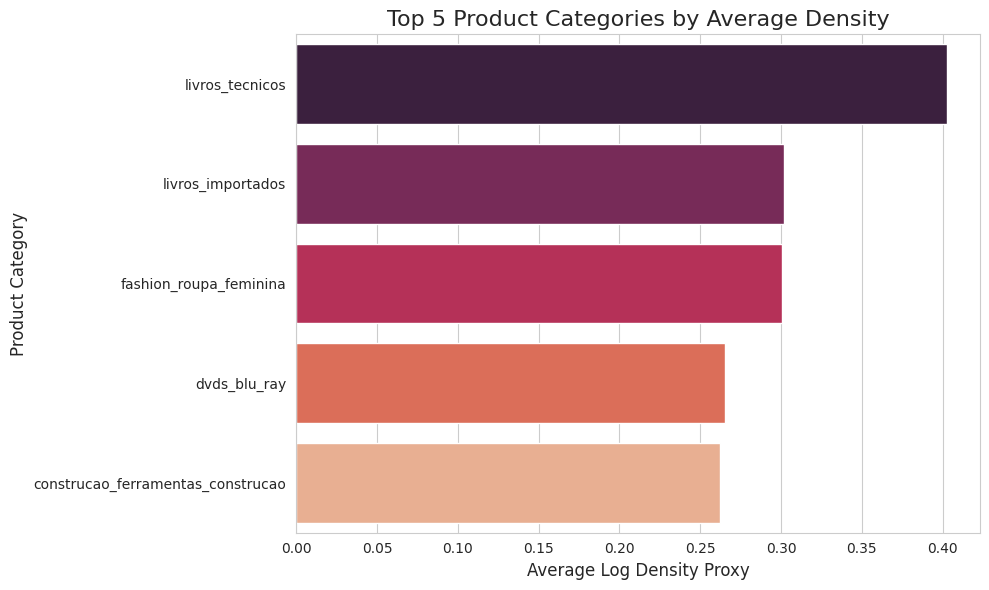

In [ ]:
# Which categories contain the most dense (heavy for their size) products?
top_5_dense_categories = products_df.groupby('product_category_name')['product_density_proxy_log'].mean().sort_values(ascending=False).head(5)
print("\n6. Top 5 Categories by Average Product Density:")
print(top_5_dense_categories)

# --- Visualization for Top 5 Categories by Density ---
plt.figure(figsize=(10, 6))
sns.barplot(x=top_5_dense_categories.values, y=top_5_dense_categories.index, palette='rocket')
plt.title('Top 5 Product Categories by Average Density', fontsize=16)
plt.xlabel('Average Log Density Proxy', fontsize=12)
plt.ylabel('Product Category', fontsize=12)
plt.tight_layout()
plt.show()

Correlation Analysis: Descriptive Lengths


Correlation between Name Length and Description Length: 0.10


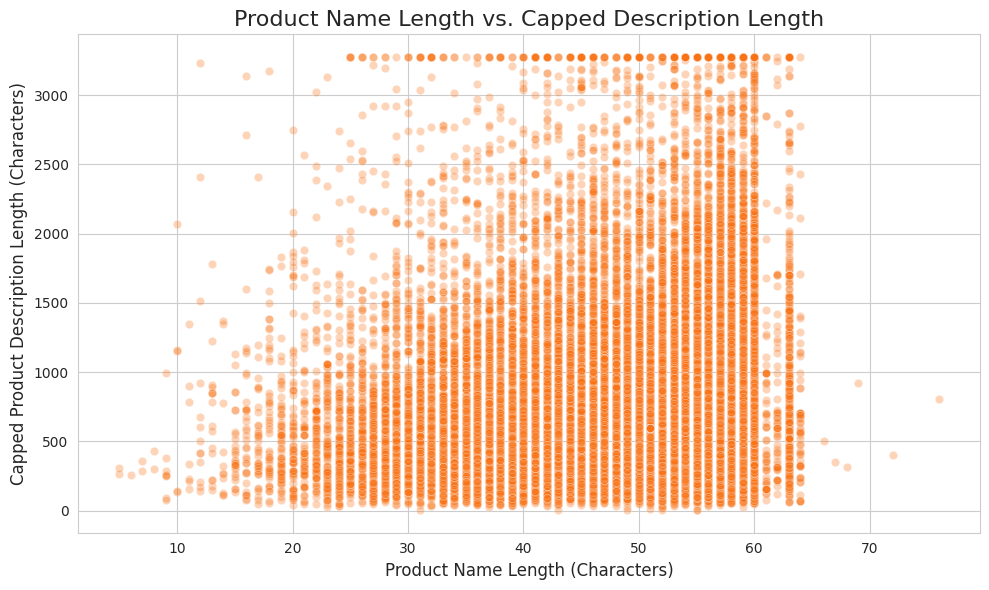

In [ ]:
# Is there a trade-off between the length of the product name and its description?
correlation = products_df[['product_name_length', 'product_description_length']].corr().iloc[0, 1]
print(f"\nCorrelation between Name Length and Description Length: {correlation:.2f}")

# --- Visualization for Name Length vs. Description Length ---
# Using capped description length to reduce outlier impact on visualization
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=products_df,
    x='product_name_length',
    y='product_description_length_capped',
    alpha=0.3,
    color='#F97316'
)
plt.title('Product Name Length vs. Capped Description Length', fontsize=16)
plt.xlabel('Product Name Length (Characters)', fontsize=12)
plt.ylabel('Capped Product Description Length (Characters)', fontsize=12)
plt.tight_layout()
plt.show()


Packaging Efficiency Analysis


Packaging Efficiency Summary:
count    32951.000000
mean       166.966376
std        169.437765
min          8.000000
25%         61.860465
50%        108.000000
75%        213.514300
max       1481.040000
Name: packaging_efficiency, dtype: float64


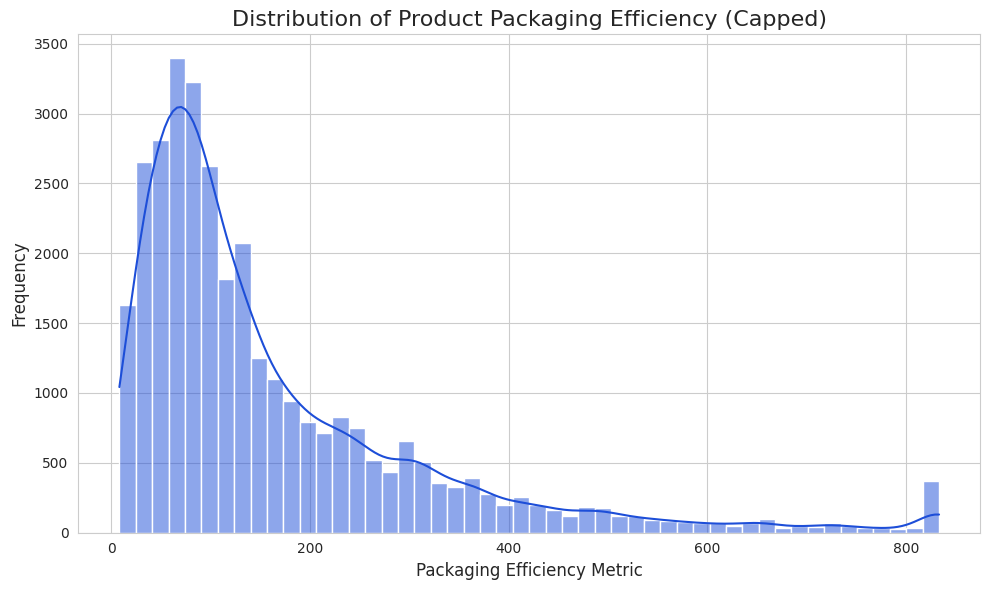

In [ ]:
print("\nPackaging Efficiency Summary:")
packaging_stats = products_df['packaging_efficiency'].describe()
print(packaging_stats)

# --- Visualization for Packaging Efficiency Distribution ---
# Plotting the raw value, capped at the 99th percentile for clearer visualization
packaging_cap = products_df['packaging_efficiency'].quantile(0.99)
plt.figure(figsize=(10, 6))
sns.histplot(products_df['packaging_efficiency'].clip(upper=packaging_cap), bins=50, kde=True, color='#1D4ED8')
plt.title('Distribution of Product Packaging Efficiency (Capped)', fontsize=16)
plt.xlabel('Packaging Efficiency Metric', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.tight_layout()
plt.show()

Dominant Dimension Analysis

In [ ]:
# Identify which dimension (L, H, or W) is the single largest constraint for shipping
dimensions = ['product_length_cm', 'product_height_cm', 'product_width_cm']

def get_dominant_dimension(row):
    max_val = row[dimensions].max()
    if row['product_length_cm'] == max_val:
        return 'Length'
    elif row['product_height_cm'] == max_val:
        return 'Height'
    else:
        return 'Width'

products_df['dominant_dimension'] = products_df.apply(get_dominant_dimension, axis=1)
dominant_counts = products_df['dominant_dimension'].value_counts()
print("\nDominant Dimension Distribution:")
print(dominant_counts)


Dominant Dimension Distribution:
dominant_dimension
Length    26710
Height     3618
Width      2623
Name: count, dtype: int64


Visualization for Dominant Dimension Distribution (Pie Chart)

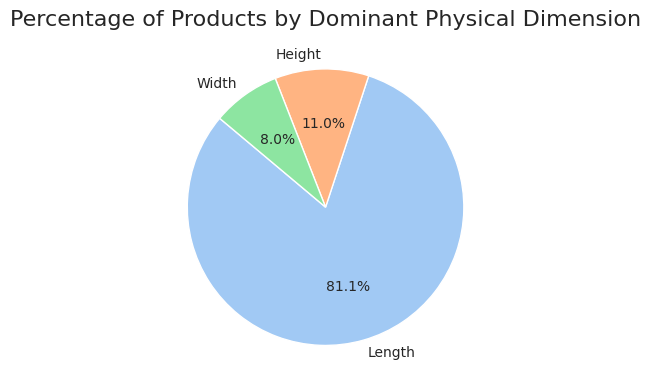

In [ ]:
plt.figure(figsize=(4, 4))
plt.pie(
    dominant_counts,
    labels=dominant_counts.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=sns.color_palette("pastel")
)
plt.title('Percentage of Products by Dominant Physical Dimension', fontsize=16)
plt.tight_layout()
plt.show()

Product Shape Classification

In [ ]:
# Classify products into general shapes for logistics planning
# Criteria: Use a 1.5x factor tolerance for rough classification
def classify_product_shape(row):
    l, h, w = row['product_length_cm'], row['product_height_cm'], row['product_width_cm']
    dims = sorted([l, h, w])
    shortest, middle, longest = dims[0], dims[1], dims[2]

    if longest / shortest < 1.5:
        return 'Cube-like' # All dimensions are close to equal
    elif longest / shortest > 3:
        return 'Long or Flat' # One dimension is significantly larger than the others
    else:
        return 'Standard Box' # Moderate variance, fits typical packaging

products_df['product_shape'] = products_df.apply(classify_product_shape, axis=1)
shape_counts = products_df['product_shape'].value_counts()
print("\nProduct Shape Classification:")
print(shape_counts)


Product Shape Classification:
product_shape
Standard Box    14093
Long or Flat    10942
Cube-like        7916
Name: count, dtype: int64


Visualization for Product Shape Classification (Bar Chart)

/tmp/ipython-input-899737627.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=shape_counts.index, y=shape_counts.values, palette='Blues_r')


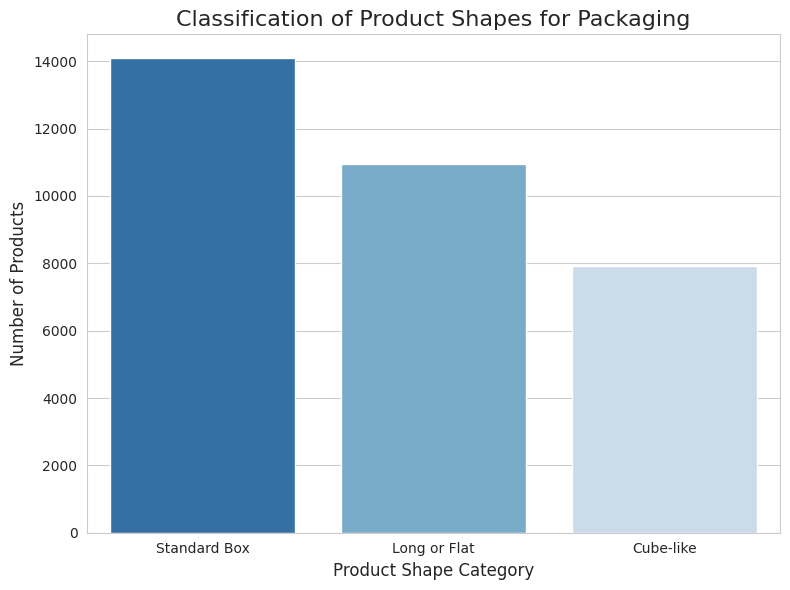

In [ ]:
plt.figure(figsize=(8, 6))
sns.barplot(x=shape_counts.index, y=shape_counts.values, palette='Blues_r')
plt.title('Classification of Product Shapes for Packaging', fontsize=16)
plt.xlabel('Product Shape Category', fontsize=12)
plt.ylabel('Number of Products', fontsize=12)
plt.tight_layout()
plt.show()


Product Name Length Distribution by Photo Quantity:


/tmp/ipython-input-1398797437.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


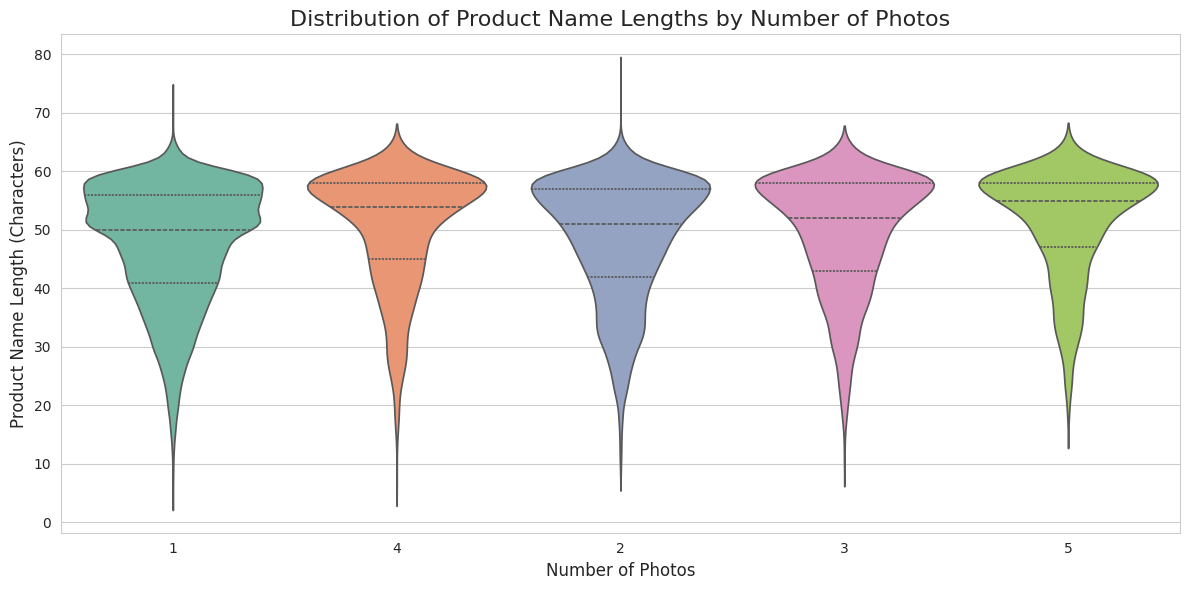

In [ ]:
# Analyze how product name length varies by the number of photos provided
# Limit to max 5 photos for clearer visualization
products_name_photo = products_df[products_df['product_photos_qty'] <= 5].copy()
products_name_photo['product_photos_qty'] = products_name_photo['product_photos_qty'].astype(int).astype(str)

print("\nProduct Name Length Distribution by Photo Quantity:")

# --- Visualization for Product Naming vs. Photo Quantity (Violin Plot) ---
plt.figure(figsize=(12, 6))
sns.violinplot(
    data=products_name_photo,
    x='product_photos_qty',
    y='product_name_length',
    palette='Set2',
    inner='quartile' # Show median and quartiles clearly
)
plt.title('Distribution of Product Name Lengths by Number of Photos', fontsize=16)
plt.xlabel('Number of Photos', fontsize=12)
plt.ylabel('Product Name Length (Characters)', fontsize=12)
plt.tight_layout()
plt.show()


Category Feature Relationship Analysis (PairPlot on Averages):


<Figure size 800x600 with 0 Axes>

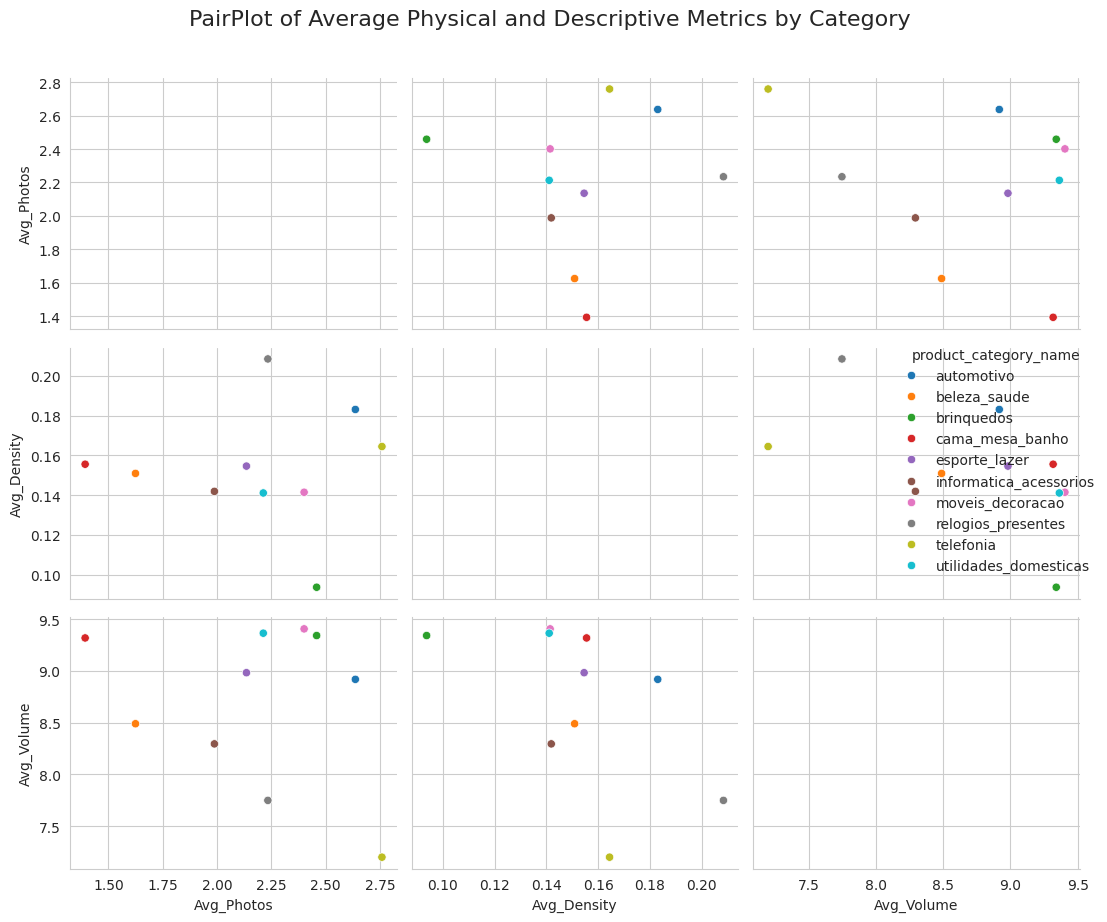

In [ ]:
# Determine Top 10 categories for comparison
top_10_categories = products_df['product_category_name'].value_counts().head(10).index
products_top_10 = products_df[products_df['product_category_name'].isin(top_10_categories)].copy()
# Visualizing the relationship between average density, volume, and photos for top categories
category_summary_metrics = products_top_10.groupby('product_category_name').agg(
    Avg_Photos=('product_photos_qty', 'mean'),
    Avg_Density=('product_density_proxy_log', 'mean'),
    Avg_Volume=('product_volume_cm3_log', 'mean')
).reset_index()

print("\nCategory Feature Relationship Analysis (PairPlot on Averages):")

# Visualization for Category Feature Relationship (PairPlot)
plt.figure(figsize=(8, 6))
sns.pairplot(
    category_summary_metrics,
    vars=['Avg_Photos', 'Avg_Density', 'Avg_Volume'],
    hue='product_category_name',
    diag_kind='kde',
    palette='tab10',
    height=3
)
plt.suptitle('PairPlot of Average Physical and Descriptive Metrics by Category', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

Category-Agnostic Feature Correlation (PairPlot)


19. Raw Feature Correlation Analysis (PairPlot):


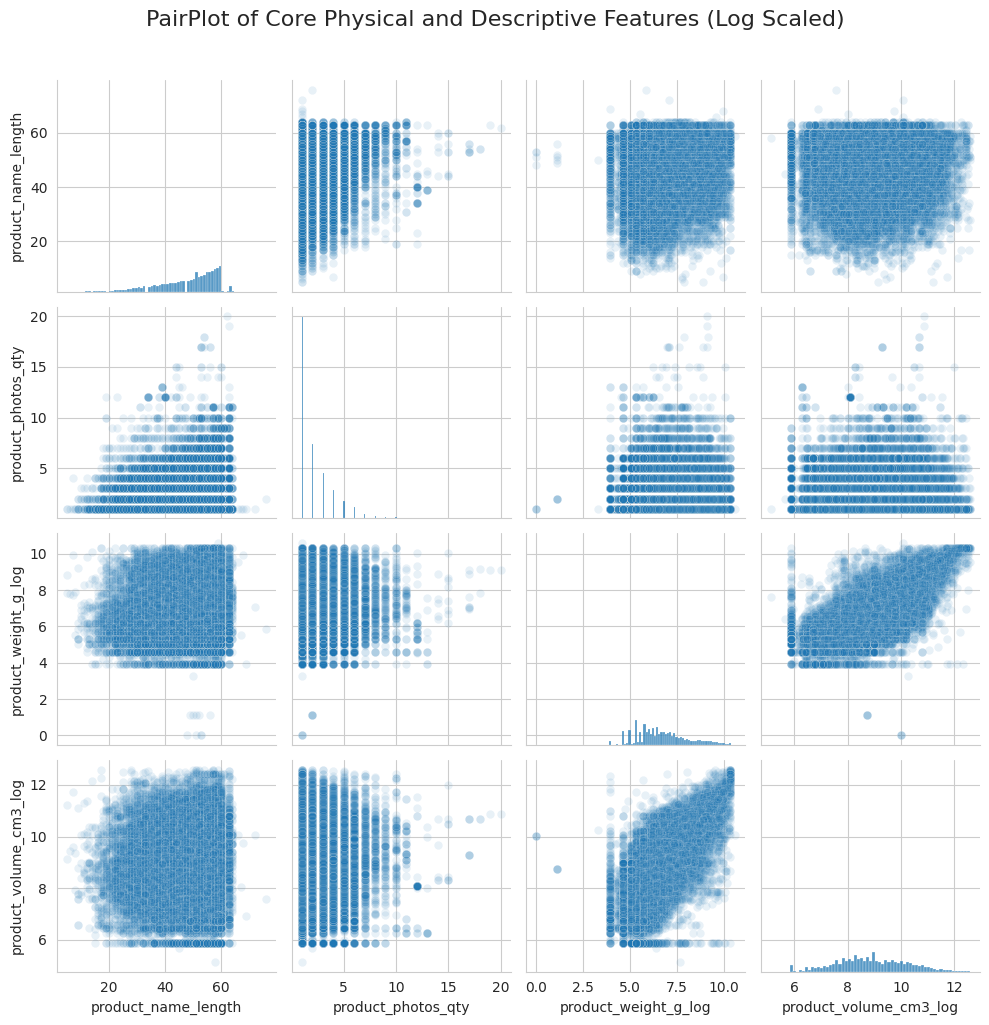

In [ ]:
# Final, comprehensive visualization of correlations between core numerical features
raw_features_for_correlation = products_df[[
    'product_name_length',
    'product_photos_qty',
    'product_weight_g_log',
    'product_volume_cm3_log'
]].copy()

print("\n19. Raw Feature Correlation Analysis (PairPlot):")

# --- Visualization for Raw Feature Correlation (PairPlot) ---
sns.pairplot(
    raw_features_for_correlation,
    diag_kind='hist',
    plot_kws={'alpha': 0.1} # Use low alpha for huge dataset
)
plt.suptitle('PairPlot of Core Physical and Descriptive Features (Log Scaled)', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()


## The code in the following cell loads the `olist_geolocation_dataset.csv` file into a pandas DataFrame and displays the first few rows.

In [ ]:
# Load the geolocation dataset
geolocation_dataset_path = os.path.join(path, "olist_geolocation_dataset.csv")
geolocation_df = pd.read_csv(geolocation_dataset_path)

# Display the first few rows of the DataFrame
geolocation_df.head()

geolocation_zip_code_prefix  geolocation_lat  geolocation_lng  \
0                         1037       -23.545621       -46.639292   
1                         1046       -23.546081       -46.644820   
2                         1046       -23.546129       -46.642951   
3                         1041       -23.544392       -46.639499   
4                         1035       -23.541578       -46.641607   

  geolocation_city geolocation_state  
0        sao paulo                SP  
1        sao paulo                SP  
2        sao paulo                SP  
3        sao paulo                SP  
4        sao paulo                SP

In [ ]:
# Get information about the geolocation_df DataFrame
geolocation_df_info = geolocation_df.info()

# Display missing values information
print("\nMissing values in geolocation_df:")
print(geolocation_df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 5 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   geolocation_zip_code_prefix  1000163 non-null  int64  
 1   geolocation_lat              1000163 non-null  float64
 2   geolocation_lng              1000163 non-null  float64
 3   geolocation_city             1000163 non-null  object 
 4   geolocation_state            1000163 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 38.2+ MB

Missing values in geolocation_df:
geolocation_zip_code_prefix    0
geolocation_lat                0
geolocation_lng                0
geolocation_city               0
geolocation_state              0
dtype: int64


In [ ]:
# Check for duplicated rows in the geolocation_df
print(f"Number of duplicated rows in geolocation_df: {geolocation_df.duplicated().sum()}")

Number of duplicated rows in geolocation_df: 261831


In [ ]:
# Remove duplicate rows based on the subset of specified columns
geolocation_df.drop_duplicates(subset=['geolocation_zip_code_prefix', 'geolocation_lat', 'geolocation_lng'], keep='first', inplace=True)

# Verify that duplicates based on the subset have been removed
print(f"Number of duplicated rows based on zip code, lat, and lng after removing duplicates: {geolocation_df.duplicated(subset=['geolocation_zip_code_prefix', 'geolocation_lat', 'geolocation_lng']).sum()}")

Number of duplicated rows based on zip code, lat, and lng after removing duplicates: 0


Numerical columns in order_items_df: Index(['geolocation_zip_code_prefix', 'geolocation_lat', 'geolocation_lng'], dtype='object')

--- Outlier Analysis for column: geolocation_zip_code_prefix ---


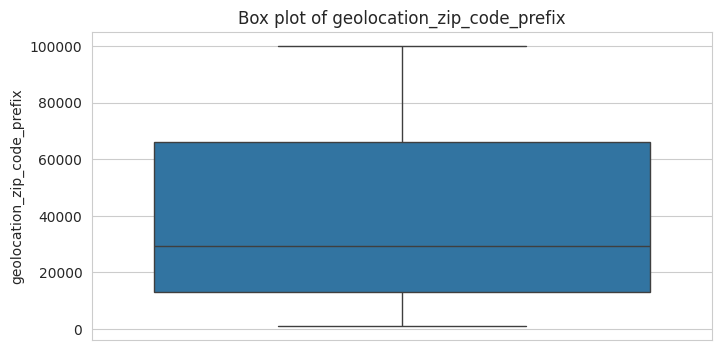

  Number of outliers: 0
  Percentage of outliers: 0.00%
  Lower bound (IQR): -66472.00
  Upper bound (IQR): 145568.00

--- Outlier Analysis for column: geolocation_lat ---


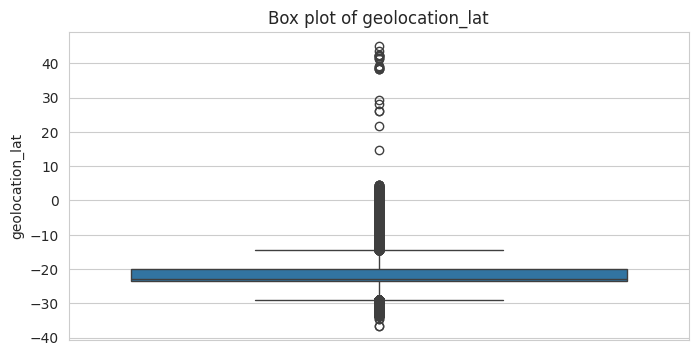

  Number of outliers: 128772
  Percentage of outliers: 17.88%
  Lower bound (IQR): -29.13
  Upper bound (IQR): -14.39

--- Outlier Analysis for column: geolocation_lng ---


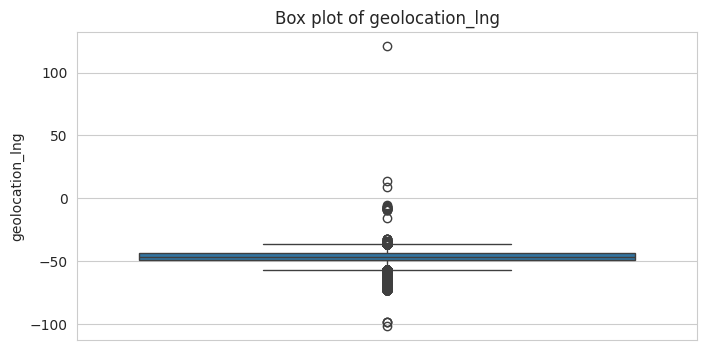

  Number of outliers: 27451
  Percentage of outliers: 3.81%
  Lower bound (IQR): -56.60
  Upper bound (IQR): -36.10


In [ ]:
# Identify numerical columns in order_items_df
numerical_cols_items = geolocation_df.select_dtypes(include=np.number).columns

print("Numerical columns in order_items_df:", numerical_cols_items)

# Apply outlier detection and plotting for each numerical column
for col in numerical_cols_items:
    detect_and_plot_outliers_iqr(geolocation_df, col)

In [ ]:
# Define the approximate geographical boundaries for Brazil
LAT_MIN, LAT_MAX = -34, 6
LON_MIN, LON_MAX = -74, -34

# Find coordinates that fall outside these boundaries
geo_outliers = geolocation_df[
    (geolocation_df['geolocation_lat'] < LAT_MIN) | (geolocation_df['geolocation_lat'] > LAT_MAX) |
    (geolocation_df['geolocation_lng'] < LON_MIN) | (geolocation_df['geolocation_lng'] > LON_MAX)
]

num_outliers = len(geo_outliers)

if num_outliers > 0:
    print(f"--- Geographic Outlier Analysis ---")
    print(f"Found {num_outliers} coordinates outside the plausible boundaries of Brazil.")
    print("\nDisplaying some of the detected outliers:")
    display(geo_outliers)

    geolocation_df_cleaned = geolocation_df.drop(geo_outliers.index)
    print(f"\n{num_outliers} outlier rows have been removed.")

else:
    print("No geographic outliers found outside the plausible boundaries of Brazil.")


--- Geographic Outlier Analysis ---
Found 33 coordinates outside the plausible boundaries of Brazil.

Displaying some of the detected outliers:


geolocation_zip_code_prefix  geolocation_lat  geolocation_lng  \
387565                        18243        28.008978       -15.536867   
513631                        28165        41.614052        -8.411675   
513643                        28155       -34.586422       -58.732101   
513754                        28155        42.439286        13.820214   
514429                        28333        38.381672        -6.328200   
516682                        28595        43.684961        -7.411080   
538512                        29654        29.409252       -98.484121   
538557                        29654        21.657547      -101.466766   
585242                        35179        25.995203       -98.078544   
585260                        35179        25.995245       -98.078533   
695375                        45936       -34.622400       -58.901888   
695377                        45936        38.323939        -6.775035   
697048                        46560        38.991963        -4.947823   
698466                        47310        38.268205        -7.803886   
715892                        53990        -3.845491       -32.413367   
715893                        53990        -3.853092       -32.423525   
715896                        53990        -3.846930       -32.415821   
715900                        53990        -3.848319       -32.412384   
715912                        53990        -3.844080       -32.405985   
715914                        53990        -3.852505       -32.402779   
727755                        57319        45.065933         9.341528   
732362                        58441        41.385328        -8.717342   
769333                        68275        41.146203        -8.577855   
769351                        68275        42.166805        -6.898531   
769391                        68275        42.167251        -6.898559   
769924                        68379        38.713128        -9.135741   
770534                        68447        42.428884        -6.873344   
822529                        78131        38.816816        -9.394625   
860562                        83252        42.184003        -8.723762   
865611                        83810        39.057629        -9.400037   
965687                        95130        14.585073       121.105394   
992584                        98780       -36.605374       -64.283946   
993075                        98780       -36.603837       -64.287433   

               geolocation_city geolocation_state  
387565  bom retiro da esperanca                SP  
513631      vila nova de campos                RJ  
513643              santa maria                RJ  
513754              santa maria                RJ  
514429                   raposo                RJ  
516682                  portela                RJ  
538512   santo antônio do canaã                ES  
538557   santo antonio do canaa                ES  
585242       santana do paraíso                MG  
585260       santana do paraiso                MG  
695375                  itabata                BA  
695377                 itabatan                BA  
697048                 ibiajara                BA  
698466       santana do sobrado                BA  
715892      fernando de noronha                PE  
715893      fernando de noronha                PE  
715896      fernando de noronha                PE  
715900      fernando de noronha                PE  
715912      fernando de noronha                PE  
715914      fernando de noronha                PE  
727755               pau d'arco                AL  
732362         são josé da mata                PB  
769333          porto trombetas                PA  
769351          porto trombetas                PA  
769391          porto trombetas                PA  
769924       castelo dos sonhos                PA  
770534         vila dos cabanos                PA  
822529            varzea grande                MT  
860562       ilha


33 outlier rows have been removed.


Observations:
* Each zip code prefix is associated with one city and one state.
* This dataset enables mapping customer and seller locations geographically.
* Unique states provide insights into regional coverage and potential logistics challenges.

In [ ]:
geolocation_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 720154 entries, 0 to 1000161
Data columns (total 5 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   geolocation_zip_code_prefix  720154 non-null  int64  
 1   geolocation_lat              720154 non-null  float64
 2   geolocation_lng              720154 non-null  float64
 3   geolocation_city             720154 non-null  object 
 4   geolocation_state            720154 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 49.1+ MB


## Exploratory Data Analysis (EDA) for `olist_geolocation_dataset.csv`

State and City Granularity Analysis

In [ ]:
print("\nState and City Granularity Analysis:")
total_records = len(geolocation_df)
unique_zip_prefixes = geolocation_df['geolocation_zip_code_prefix'].nunique()
unique_cities = geolocation_df['geolocation_city'].nunique()
unique_states = geolocation_df['geolocation_state'].nunique()

print(f"Total Unique Location Records: {total_records}")
print(f"Total Unique Zip Code Prefixes: {unique_zip_prefixes}")
print(f"Total Unique Cities: {unique_cities}")
print(f"Total Unique States: {unique_states}")

# Calculate average number of lat/lng entries per unique ZIP prefix
avg_entries_per_zip = total_records / unique_zip_prefixes
print(f"\nAverage geographical entries per unique ZIP prefix (Granularity): {avg_entries_per_zip:.2f}")



State and City Granularity Analysis:
Total Unique Location Records: 720154
Total Unique Zip Code Prefixes: 19015
Total Unique Cities: 7965
Total Unique States: 27

Average geographical entries per unique ZIP prefix (Granularity): 37.87


Top 10 States by Location Entries


Top 10 States by Number of Location Entries (Data Density):
geolocation_state
SP    274573
MG    100522
RJ     77618
RS     47654
PR     44501
SC     29368
BA     27428
GO     15055
PE     13094
ES     12361
Name: count, dtype: int64


/tmp/ipython-input-1961501569.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_10_states.index, y=top_10_states.values, palette='crest')


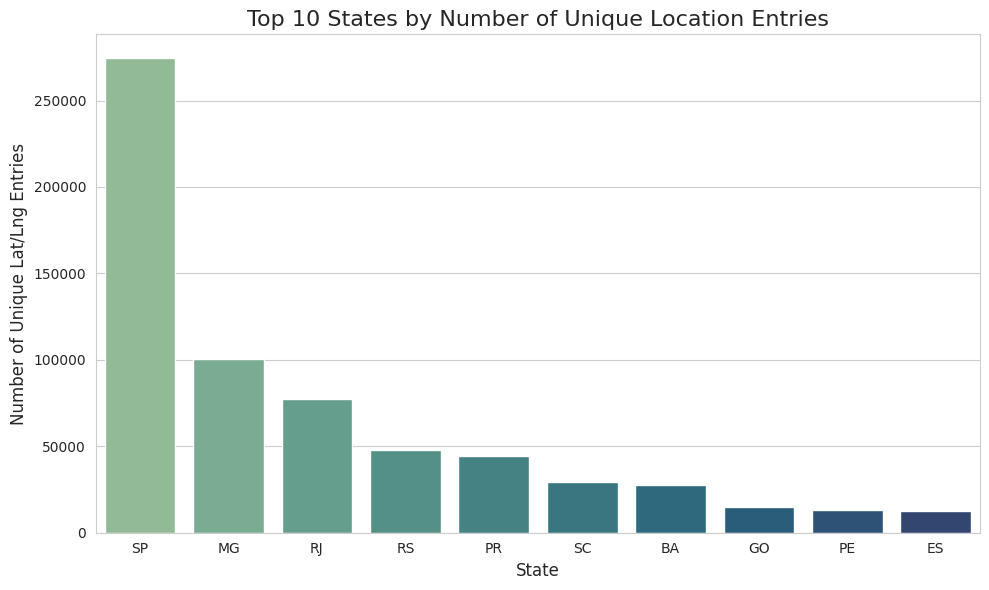

In [ ]:
top_10_states = geolocation_df['geolocation_state'].value_counts().head(10)
print("\nTop 10 States by Number of Location Entries (Data Density):")
print(top_10_states)

# --- Visualization for Top 10 States (Bar Chart) ---
plt.figure(figsize=(10, 6))
sns.barplot(x=top_10_states.index, y=top_10_states.values, palette='crest')
plt.title('Top 10 States by Number of Unique Location Entries', fontsize=16)
plt.xlabel('State', fontsize=12)
plt.ylabel('Number of Unique Lat/Lng Entries', fontsize=12)
plt.tight_layout()
plt.show()

Top 10 Cities by Location Entries


Top 10 Cities by Number of Location Entries (Hub Identification):
geolocation_city
sao paulo         77227
rio de janeiro    35176
belo horizonte    19474
são paulo         14561
curitiba          11262
porto alegre       8702
salvador           8083
guarulhos          7411
brasilia           6667
osasco             4993
Name: count, dtype: int64


/tmp/ipython-input-1279330881.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_10_cities.values, y=top_10_cities.index, palette='magma')


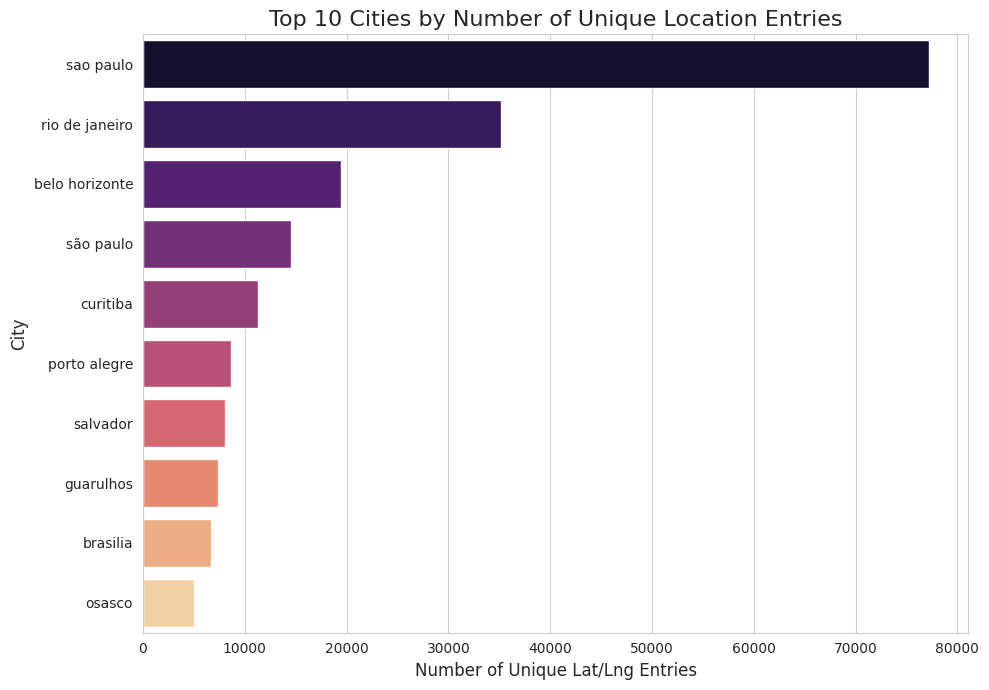

In [ ]:
top_10_cities = geolocation_df['geolocation_city'].value_counts().head(10)
print("\nTop 10 Cities by Number of Location Entries (Hub Identification):")
print(top_10_cities)

# --- Visualization for Top 10 Cities (Horizontal Bar Chart) ---
plt.figure(figsize=(10, 7))
sns.barplot(x=top_10_cities.values, y=top_10_cities.index, palette='magma')
plt.title('Top 10 Cities by Number of Unique Location Entries', fontsize=16)
plt.xlabel('Number of Unique Lat/Lng Entries', fontsize=12)
plt.ylabel('City', fontsize=12)
plt.tight_layout()
plt.show()

Geographical Density Map (Scatter Plot)


Geographical Density Map (Sampling 100,000 Points):


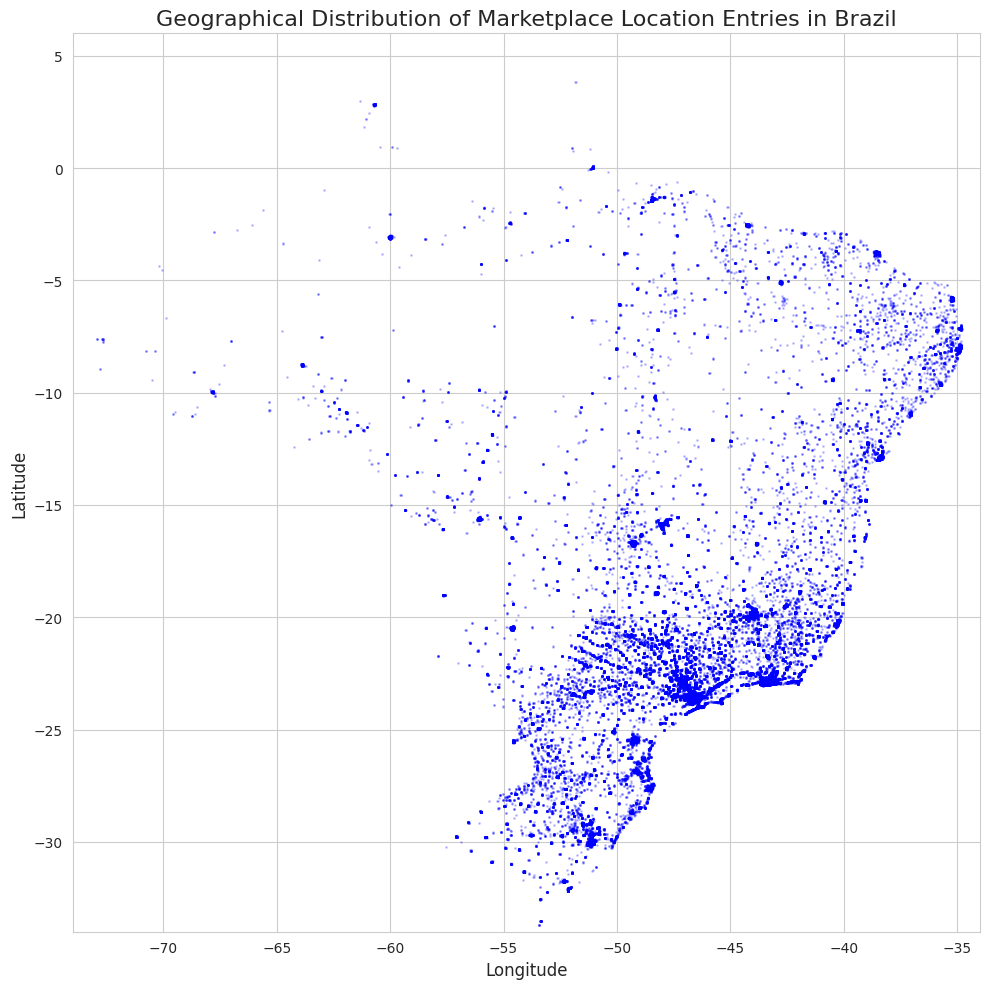

In [ ]:
# Downsample for faster plotting of highly dense data points
sample_df = geolocation_df.sample(n=100000, random_state=42)

print("\nGeographical Density Map (Sampling 100,000 Points):")

# --- Visualization for Geographical Density Map (Scatter Plot) ---
plt.figure(figsize=(10, 10))
plt.scatter(
    sample_df['geolocation_lng'],
    sample_df['geolocation_lat'],
    alpha=0.2,
    s=1,
    color='blue'
)

# Highlight high-density areas (Southeastern Brazil)
plt.xlim(LON_MIN, LON_MAX)
plt.ylim(LAT_MIN, LAT_MAX)
plt.title('Geographical Distribution of Marketplace Location Entries in Brazil', fontsize=16)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.tight_layout()
plt.show()

Visualization for Zoomed-In Density Map (Hexbin Plot)


Zoomed-In Density Map: Hexbin Plot for SP


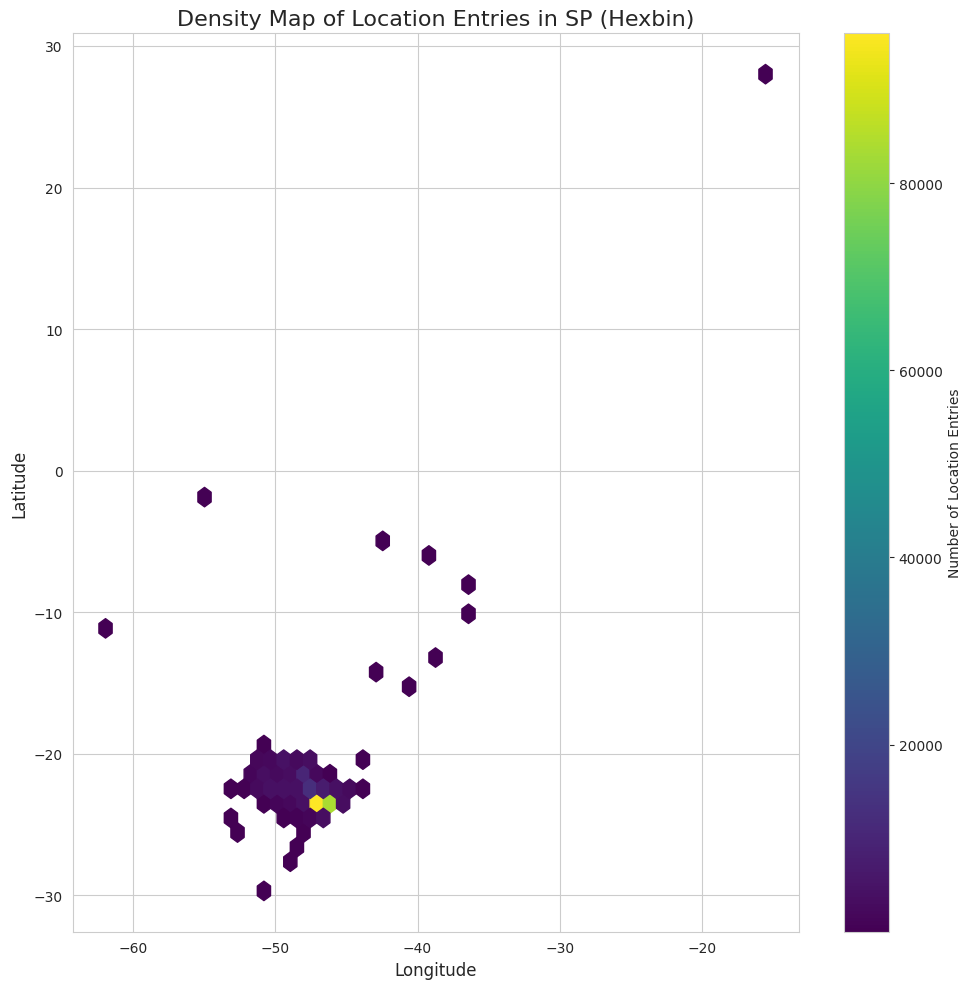

In [ ]:
top_state_abbr = top_10_states.index[0] # Get the abbreviation of the top state (e.g., 'SP')
top_state_df = geolocation_df[geolocation_df['geolocation_state'] == top_state_abbr]

print(f"\nZoomed-In Density Map: Hexbin Plot for {top_state_abbr}")

# --- Visualization for Zoomed-In Density Map (Hexbin Plot) ---
plt.figure(figsize=(10, 10))
plt.hexbin(
    top_state_df['geolocation_lng'],
    top_state_df['geolocation_lat'],
    gridsize=50,
    cmap='viridis',
    mincnt=1
)
plt.colorbar(label='Number of Location Entries')
plt.title(f'Density Map of Location Entries in {top_state_abbr} (Hexbin)', fontsize=16)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.tight_layout()
plt.show()

Geographic Granularity: ZIP Prefixes per City by State


Geographic Granularity (Zip Codes per City) for Top 10 States:
                   zip_per_city_ratio
geolocation_state                    
SP                           6.093090
RJ                           5.720165
PE                           2.232210
GO                           2.039578
ES                           1.981132
RS                           1.645349
PR                           1.616692
BA                           1.528505
SC                           1.479714
MG                           1.311798


/tmp/ipython-input-4161032336.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=granularity_df_top.index, y=granularity_df_top['zip_per_city_ratio'], palette='RdYlGn')


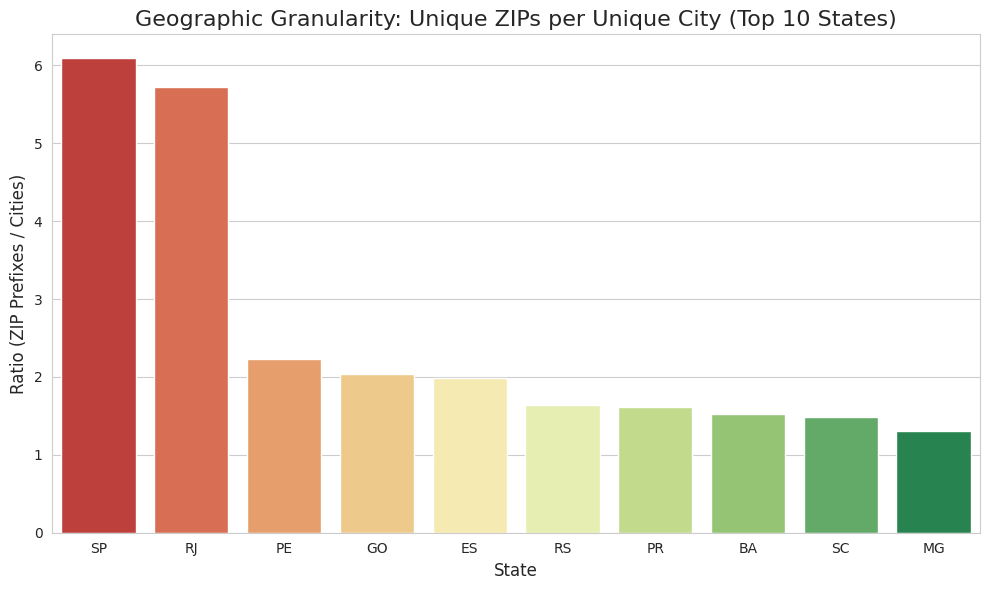

In [ ]:
# Group by state and calculate the number of unique cities and unique zip prefixes
granularity_df = geolocation_df.groupby('geolocation_state').agg(
    unique_cities=('geolocation_city', 'nunique'),
    unique_zips=('geolocation_zip_code_prefix', 'nunique')
)

# Calculate the ratio: unique Zips per unique City
granularity_df['zip_per_city_ratio'] = granularity_df['unique_zips'] / granularity_df['unique_cities']

# Filter to the top 10 most populated states for readability
granularity_df_top = granularity_df.loc[top_10_states.index].sort_values(by='zip_per_city_ratio', ascending=False)

print("\nGeographic Granularity (Zip Codes per City) for Top 10 States:")
print(granularity_df_top[['zip_per_city_ratio']])

# --- Visualization for Granularity Ratio (Bar Chart) ---
plt.figure(figsize=(10, 6))
sns.barplot(x=granularity_df_top.index, y=granularity_df_top['zip_per_city_ratio'], palette='RdYlGn')
plt.title('Geographic Granularity: Unique ZIPs per Unique City (Top 10 States)', fontsize=16)
plt.xlabel('State', fontsize=12)
plt.ylabel('Ratio (ZIP Prefixes / Cities)', fontsize=12)
plt.tight_layout()
plt.show()

Choropleth Map Preparation (Proxy for visualization)


State Density Analysis (Choropleth Proxy Data):
  state  location_count  density_percentage
0    SP          274573           38.126984
1    MG          100522           13.958403
2    RJ           77618           10.777972
3    RS           47654            6.617196
4    PR           44501            6.179373


/tmp/ipython-input-1885406491.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='state', y='density_percentage', data=state_density.head(10), palette='plasma')


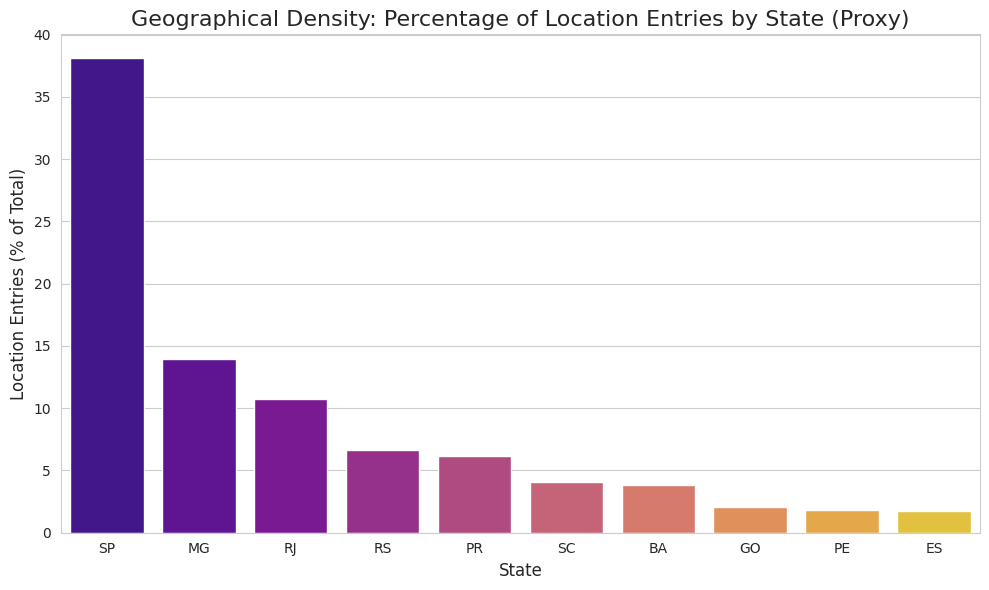

In [ ]:
# Since plotting an actual choropleth map requires external GeoJSON files (which we cannot load),
# we will create a data visualization proxy by summarizing the data needed for a choropleth.
state_density = geolocation_df['geolocation_state'].value_counts().reset_index()
state_density.columns = ['state', 'location_count']
total_locations = state_density['location_count'].sum()
state_density['density_percentage'] = (state_density['location_count'] / total_locations) * 100

print("\nState Density Analysis (Choropleth Proxy Data):")
print(state_density.head())

# --- Visualization for State Density (Ranked Bar Chart - Choropleth Proxy) ---
plt.figure(figsize=(10, 6))
sns.barplot(x='state', y='density_percentage', data=state_density.head(10), palette='plasma')
plt.title('Geographical Density: Percentage of Location Entries by State (Proxy)', fontsize=16)
plt.xlabel('State', fontsize=12)
plt.ylabel('Location Entries (% of Total)', fontsize=12)
plt.tight_layout()
plt.show()


Top City Pinpoint Map (Bubble Map)


Top City Pinpoint Map Data (Bubble Map Proxy):
  geolocation_city        lat        lng  count        size
8        sao paulo -23.570162 -46.624621  77227  112.545174
6   rio de janeiro -22.906053 -43.334033  35176  104.681477
0   belo horizonte -19.905132 -43.959508  19474   98.768869
9        são paulo -23.573116 -46.629682  14561   95.861707
2         curitiba -25.455428 -49.273265  11262   93.292783
5     porto alegre -30.050439 -51.186968   8702   90.714231
7         salvador -12.958740 -38.462674   8083   89.976421
3        guarulhos -23.442365 -46.491820   7411   89.108556
1         brasilia -15.815803 -47.986687   6667   88.050752
4           osasco -23.534893 -46.789608   4993   85.159925


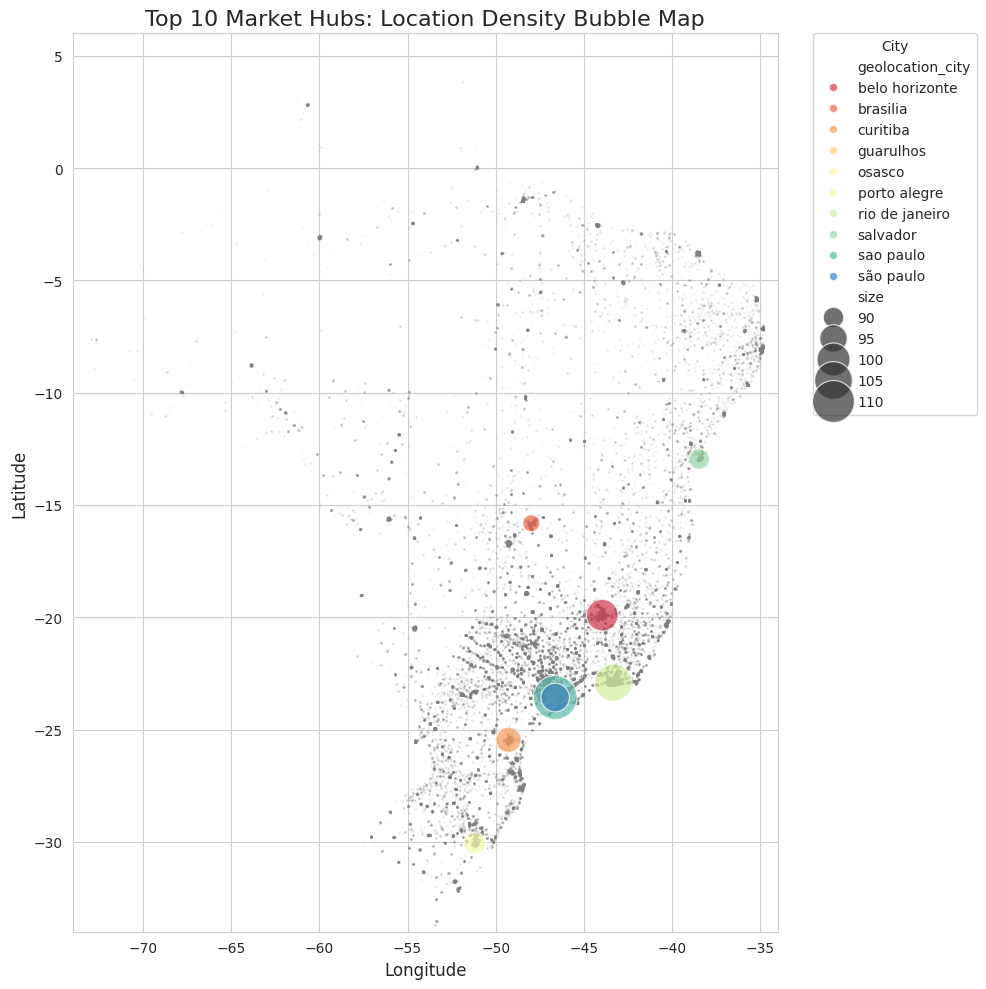

In [ ]:
# Calculate the average coordinates for the top 10 cities to use as plot centers
top_10_city_names = top_10_cities.index.to_list()

city_coords = geolocation_df[geolocation_df['geolocation_city'].isin(top_10_city_names)].groupby('geolocation_city').agg(
    lat=('geolocation_lat', 'mean'),
    lng=('geolocation_lng', 'mean'),
    count=('geolocation_zip_code_prefix', 'count')
).reset_index()

# Scale the bubble size for visualization (log scale for better distinction)
city_coords['size'] = np.log1p(city_coords['count']) * 10  # Arbitrary scaling factor

print("\nTop City Pinpoint Map Data (Bubble Map Proxy):")
print(city_coords.sort_values(by='count', ascending=False))

# --- Visualization for Top City Pinpoint Map (Bubble Map) ---
plt.figure(figsize=(10, 10))
# Plot all background points lightly (same as Section 4, but lighter)
plt.scatter(
    sample_df['geolocation_lng'],
    sample_df['geolocation_lat'],
    alpha=0.05,
    s=1,
    color='gray'
)
# Plot the top cities with scaled bubbles
sns.scatterplot(
    data=city_coords,
    x='lng',
    y='lat',
    size='size',
    hue='geolocation_city',
    sizes=(50, 1000),
    alpha=0.7,
    palette='Spectral'
)
plt.xlim(LON_MIN, LON_MAX)
plt.ylim(LAT_MIN, LAT_MAX)
plt.title('Top 10 Market Hubs: Location Density Bubble Map', fontsize=16)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.legend(title='City', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
plt.show()

Geographical Spread by State (Latitude Distribution)


Geographical Spread (Latitude Distribution) by Top State:


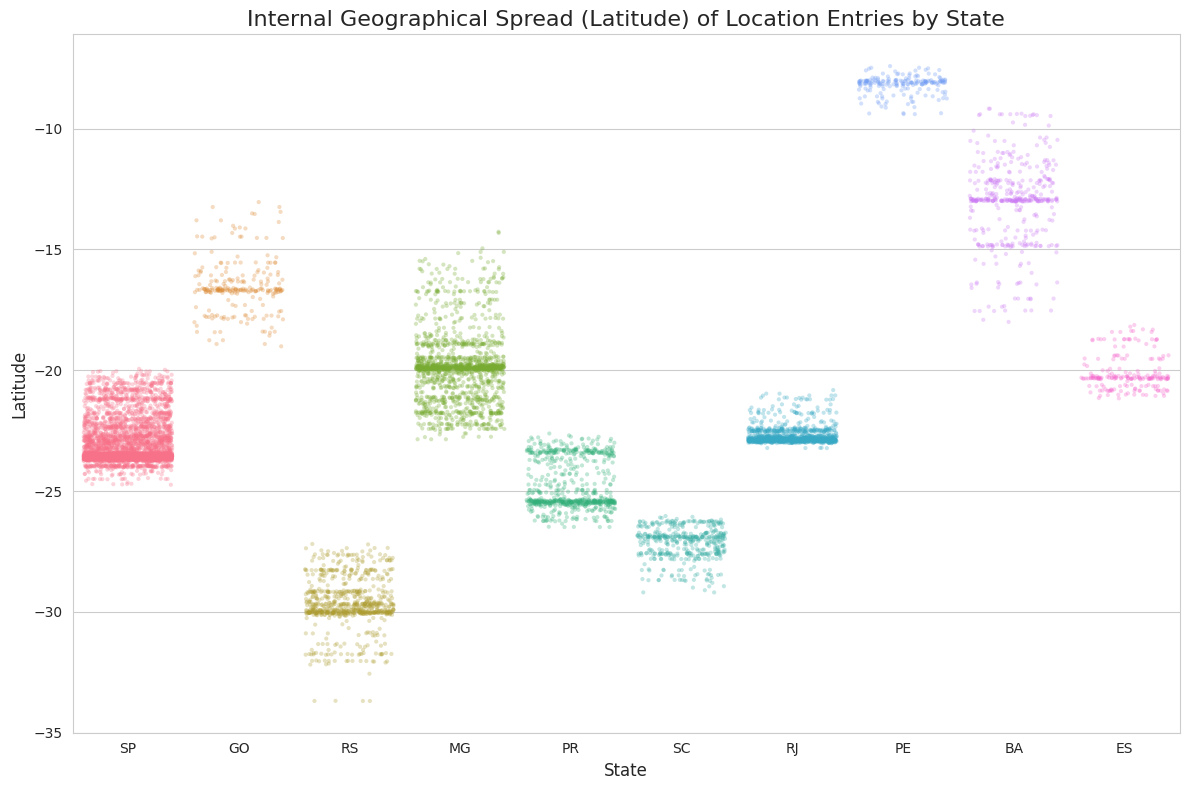

In [ ]:
# Filter data to only include the top 10 states for cleaner visualization
top_states_df = geolocation_df[geolocation_df['geolocation_state'].isin(top_10_states.index)].copy()

print("\nGeographical Spread (Latitude Distribution) by Top State:")

# --- Visualization for Geographical Spread (Strip Plot) ---
plt.figure(figsize=(12, 8))
sns.stripplot(
    data=top_states_df.sample(n=min(len(top_states_df), 10000), random_state=42), # Sample for performance
    x='geolocation_state',
    y='geolocation_lat',
    hue='geolocation_state',
    jitter=0.4,
    size=3,
    alpha=0.3,
    palette='husl',
    legend=False
)
plt.title('Internal Geographical Spread (Latitude) of Location Entries by State', fontsize=16)
plt.xlabel('State', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.tight_layout()
plt.show()

Data Integrity: Multiple Cities per ZIP Prefix


Data Integrity: ZIP Prefixes Mapping to Multiple Cities
Total Unique ZIP Prefixes: 19015
ZIP Prefixes mapped to >1 unique city: 8315
Percentage of Ambiguous ZIP Prefixes: 43.73%


/tmp/ipython-input-2502408014.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=multi_city_zips_counts.index, y=multi_city_zips_counts.values, palette='copper')


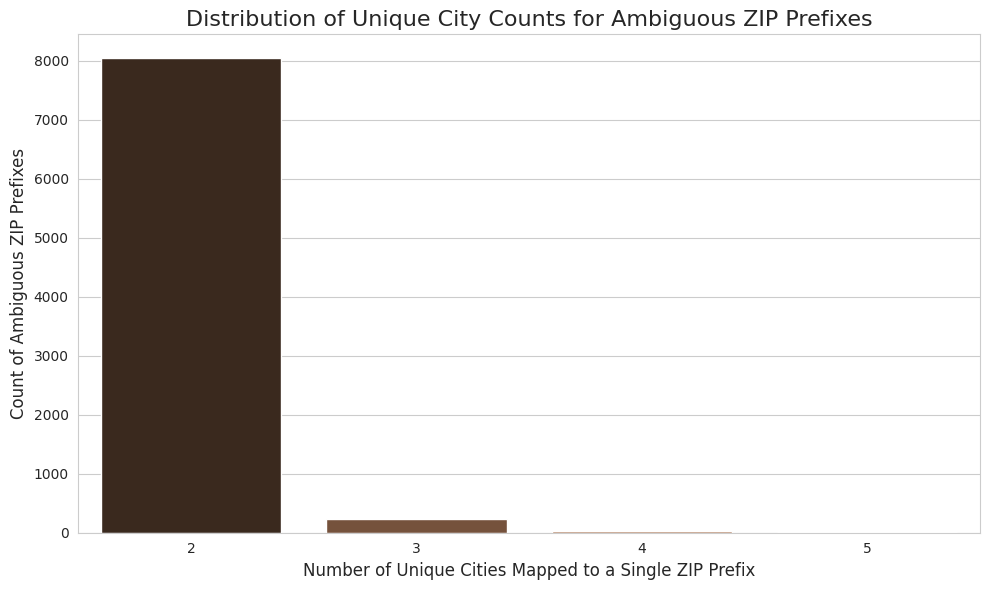

In [ ]:
# Identify ZIP prefixes that map to more than one unique city name
zip_city_counts = geolocation_df.groupby('geolocation_zip_code_prefix')['geolocation_city'].nunique()
multi_city_zips = zip_city_counts[zip_city_counts > 1]

print("\nData Integrity: ZIP Prefixes Mapping to Multiple Cities")
print(f"Total Unique ZIP Prefixes: {unique_zip_prefixes}")
print(f"ZIP Prefixes mapped to >1 unique city: {len(multi_city_zips)}")
print(f"Percentage of Ambiguous ZIP Prefixes: {(len(multi_city_zips) / unique_zip_prefixes * 100):.2f}%")

# Visualize the distribution of the number of unique cities per ambiguous ZIP
multi_city_zips_counts = multi_city_zips.value_counts().sort_index()

# --- Visualization for Data Integrity (Bar Chart) ---
plt.figure(figsize=(10, 6))
sns.barplot(x=multi_city_zips_counts.index, y=multi_city_zips_counts.values, palette='copper')
plt.title('Distribution of Unique City Counts for Ambiguous ZIP Prefixes', fontsize=16)
plt.xlabel('Number of Unique Cities Mapped to a Single ZIP Prefix', fontsize=12)
plt.ylabel('Count of Ambiguous ZIP Prefixes', fontsize=12)
plt.tight_layout()
plt.show()

Geographical Compactness of Top Cities (Bounding Box Analysis)


11. Geographical Compactness of Top Cities (Bounding Box Area):
Lower BBOX Area suggests a more geographically concentrated location.
     geolocation_city  entry_count   bbox_area
1030         brasilia         6667  106.585879
833    belo horizonte        19474    9.722752
5478     porto alegre         8702    2.374965
7213        são paulo        14561    0.795278
5843   rio de janeiro        35176    0.240239
6671        sao paulo        77227    0.234109
2078         curitiba        11262    0.050373
6014         salvador         8083    0.043576
2836        guarulhos         7411    0.030116
4869           osasco         4993    0.008361


/tmp/ipython-input-4044684979.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


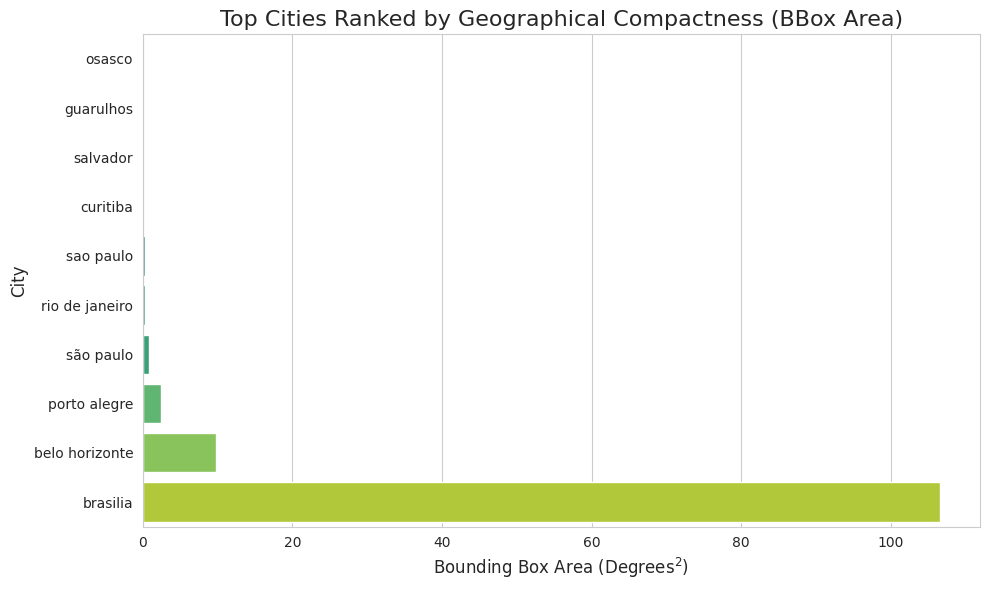

In [ ]:
# Group by city and calculate the min/max lat/lng for each city
city_bounds = geolocation_df.groupby('geolocation_city').agg(
    min_lat=('geolocation_lat', 'min'),
    max_lat=('geolocation_lat', 'max'),
    min_lng=('geolocation_lng', 'min'),
    max_lng=('geolocation_lng', 'max')
)

# Calculate the difference in lat/lng (proxy for spread/area)
city_bounds['lat_span'] = city_bounds['max_lat'] - city_bounds['min_lat']
city_bounds['lng_span'] = city_bounds['max_lng'] - city_bounds['min_lng']

# Calculate the "bounding box area" (proxy for compactness)
city_bounds['bbox_area'] = city_bounds['lat_span'] * city_bounds['lng_span']

# Merge with city counts to normalize by data density (entries per unit area)
city_counts_series = geolocation_df['geolocation_city'].value_counts()
city_compactness = city_bounds.join(city_counts_series.rename('entry_count')).reset_index()

# Filter to the top 10 most active cities
top_city_compactness = city_compactness[city_compactness['geolocation_city'].isin(top_10_cities.index)].sort_values(by='bbox_area', ascending=False)

print("\n11. Geographical Compactness of Top Cities (Bounding Box Area):")
print("Lower BBOX Area suggests a more geographically concentrated location.")
print(top_city_compactness[['geolocation_city', 'entry_count', 'bbox_area']].head(10))

# --- Visualization for Compactness (Bar Chart) ---
plt.figure(figsize=(10, 6))
sns.barplot(
    x='bbox_area',
    y='geolocation_city',
    data=top_city_compactness.sort_values(by='bbox_area', ascending=True),
    palette='viridis'
)
plt.title('Top Cities Ranked by Geographical Compactness (BBox Area)', fontsize=16)
plt.xlabel('Bounding Box Area (Degrees$^2$)', fontsize=12)
plt.ylabel('City', fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
# Create the interactive scatter map
fig = px.scatter_mapbox(
    city_coords,
    lat="lat",
    lon="lng",
        color="geolocation_city",
        size="count",
        hover_name="geolocation_city",
        zoom=3,
        height=600,
        title="Interactive Map of Top Market Hubs (Bubble Size = Location Count)"
)

# Set map style and center it roughly on Brazil
fig.update_layout(
        mapbox_style="carto-positron",
        mapbox_zoom=3,
        mapbox_center={"lat": -15.78, "lon": -47.92}, # Center near Brasília
        margin={"r":0,"t":40,"l":0,"b":0}
    )

# Show the figure (this may only output the JSON representation in some environments)
fig.show()

IndentationError: unexpected indent (ipython-input-2490633029.py, line 2)

## The code in the following cell loads the `product_category_name_translation.csv` file into a pandas DataFrame and displays the entire DataFrame.

In [ ]:
# Load the product category name translation dataset
category_name_translation_dataset_path = os.path.join(path, "product_category_name_translation.csv")
category_name_translation_df = pd.read_csv(category_name_translation_dataset_path)

# Display the entire DataFrame
category_name_translation_df

In [ ]:
# Get information about the category_name_translation_df DataFrame
print(category_name_translation_df.info())

# Display missing values information
print("\nMissing values in category_name_translation_df:")
print(category_name_translation_df.isnull().sum())

In [ ]:
print(f"Duplicated values in category_name_translation_df: {category_name_translation_df.duplicated().sum()}")
print(f"Duplicated values in category_name_translation_df['product_category_name']: {category_name_translation_df['product_category_name'].duplicated().sum()}")

Observations:
* The dataset contains two columns: the original Portuguese category names and their English translations.
* There are no missing values and duplicate values.
* This will allow us to join with the products dataset to translate product categories for better readability in analysis.

## The code in the following cell loads the `olist_orders_dataset.csv` file into a pandas DataFrame and displays the first few rows.

In [ ]:
# Load the orders dataset
orders_dataset_path = os.path.join(path, "olist_orders_dataset.csv")
orders_df = pd.read_csv(orders_dataset_path)

# Display the first few rows of the DataFrame
orders_df.head()

In [ ]:
# Get information about the orders_df DataFrame
print(orders_df.info())

# Display missing values information
print("\nMissing values in orders_df:")
print(orders_df.isnull().sum())



In [ ]:
date_cols = [
    "order_purchase_timestamp",
    "order_approved_at",
    "order_delivered_carrier_date",
    "order_delivered_customer_date",
    "order_estimated_delivery_date"
]

for col in date_cols:
    orders_df[col] = pd.to_datetime(orders_df[col])

In [ ]:
# Define the conditions for invalid orders
invalid_order_conditions = (
    (orders_df['order_approved_at'] < orders_df['order_purchase_timestamp']) |
    (orders_df['order_delivered_carrier_date'] < orders_df['order_approved_at']) |
    (orders_df['order_delivered_customer_date'] < orders_df['order_delivered_carrier_date']) |
    (orders_df['order_estimated_delivery_date'] < orders_df['order_purchase_timestamp'])
)

# Filter out the invalid orders
orders_df = orders_df[~invalid_order_conditions].reset_index(drop=True)

# Display the number of remaining orders
print(f"Number of orders after removing invalid ones: {len(orders_df)}")

In [ ]:
# Identify numerical columns in order_items_df
numerical_cols_items = products_df.select_dtypes(include=np.number).columns

print("Numerical columns in order_items_df:", numerical_cols_items)

# Apply outlier detection and plotting for each numerical column
for col in numerical_cols_items:
    detect_and_plot_outliers_iqr(products_df, col)

## The code in the following cell loads the `olist_order_payments_dataset.csv` file into a pandas DataFrame and displays the first few rows.

In [ ]:
# Load the order payments dataset
order_payments_dataset_path = os.path.join(path, "olist_order_payments_dataset.csv")
order_payments_df = pd.read_csv(order_payments_dataset_path)

# Display the first few rows of the DataFrame
order_payments_df.head()

In [ ]:
# Get information about the order_payments_df DataFrame
order_payments_df_info = order_payments_df.info()

# Display missing values information
print("\nMissing values in order_payments_df:")
print(order_payments_df.isnull().sum())

In [ ]:
# Identify numerical columns in order_items_df
numerical_cols_items = products_df.select_dtypes(include=np.number).columns

print("Numerical columns in order_items_df:", numerical_cols_items)

# Apply outlier detection and plotting for each numerical column
for col in numerical_cols_items:
    detect_and_plot_outliers_iqr(products_df, col)

General Approach
For each dataset, you should ask:

Univariate Analysis: What does each column look like on its own? (Distributions, counts, etc.)

Bivariate/Multivariate Analysis: How do the columns relate to each other?

Connecting Datasets: What insights emerge when I merge this with another dataset?

1. customers_df - The "Who"
This dataset tells you about your customers' locations and helps identify repeat business.

Key Questions:

Where are most of my customers located (by state and city)?

What percentage of my customers are one-time buyers vs. repeat purchasers?

Visualizations & Analysis:

Customer Geography:

Bar Chart: Show the number of customers per state (customer_state).

Choropleth Map: The map you just created is the perfect visualization here.

Customer Loyalty:

Group by customer_unique_id and count their orders.

Bar Chart: Visualize the number of customers who made 1, 2, 3, or more purchases. This will show you the level of customer retention.

2. orders_df - The "When and How"
This is the core transactional dataset. The timestamps are a goldmine.

Key Questions:

How do sales trend over time (monthly, weekly)?

What are the busiest times of day or days of the week for purchases?

What is the distribution of order statuses (order_status)?

How long does each step of the fulfillment process take (e.g., purchase to approval, approval to shipment, shipment to delivery)?

Visualizations & Analysis:

Time Series Analysis:

Line Chart: Plot the count of orders over time (order_purchase_timestamp) to see growth and seasonality.

Bar Charts: Show order counts by month, day of the week, and hour of the day.

Order Fulfillment:

Bar Chart: Show the counts for each order_status.

Histograms: Calculate the time differences (in days or hours) between the various timestamp columns and plot their distributions. This will highlight bottlenecks in the process.

3. order_reviews_df - The "Feedback"
This dataset is crucial for understanding customer satisfaction.

Key Questions:

What is the overall distribution of review scores?

How does the review score relate to the delivery time?

How long does it take for a customer to leave a review after receiving their order?

Visualizations & Analysis:

Score Distribution:

Bar Chart: Plot the counts of each review_score (1 to 5). You will likely see a U-shaped or J-shaped distribution.

Connecting to Orders (Crucial!):

Merge with orders_df.

Box Plot: Show the distribution of delivery_delay for each review_score. This is one of the most powerful analyses you can do—it will likely show that lower scores are strongly correlated with late deliveries.

4. order_payments_df - The "Money"
This dataset tells you how customers are paying.

Key Questions:

What are the most popular payment methods (payment_type)?

For credit card payments, what is the distribution of payment installments?

What is the distribution of payment values?

Visualizations & Analysis:

Payment Methods:

Pie Chart or Bar Chart: Show the percentage/count of each payment_type.

Payment Behavior:

Bar Chart: Show the counts for payment_installments.

Histogram/Box Plot: Show the distribution of payment_value.

5. products_df & order_items_df - The "What"
These datasets describe the products being sold and link them to orders.

Key Questions:

What are the best-selling product categories?

What is the distribution of product attributes (weight, size, photos, description length)?

Is there a relationship between price/freight value and product category?

Visualizations & Analysis:

Product Popularity (Merge products and order_items):

Bar Chart: Show the top 20 best-selling product_category_name.

Product Attributes:

Histograms: Show the distributions of product_weight_g, product_description_length, etc. (using your log-transformed versions where appropriate).

Pricing Analysis:

Box Plot: Show the distribution of price for different product_category_name. This will show you which categories contain the most expensive items.

6. sellers_df - The "Sellers"
This dataset provides information about the merchants on the platform.

Key Questions:

Where are the sellers concentrated geographically?

Who are the top sellers by number of items sold?

Is there a correlation between a seller's location and customer satisfaction?

Visualizations & Analysis:

Seller Geography:

Bar Chart: Show the number of sellers by seller_state.

Seller Performance (Merge with order_items and reviews):

Bar Chart: Show the top 20 sellers by total items sold or total revenue.

Box Plot: Group by seller_state and show the distribution of review_score to see if sellers in certain regions perform better.